In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from wordcloud import WordCloud
from PIL import ImageDraw

In [2]:
df = pd.read_pickle("df_complete")

In [3]:
df.shape

(1920, 18)

In [4]:
df.columns

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Country code', 'Speech', 'Polarity_score', 'Overall Scores',
       'Safety and Security', 'Ongoing Conflict', 'Militarian'],
      dtype='object')

In [5]:
# Download necessary nltk data (if not already done)
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Define a set of common UN-related words to ignore
common_un_words = set([
    'nations', 'united', 'international', 'development', 'world', 
    'security', 'global', 'africa', 'peace', 'people', 'humanity', 
    'cooperation', 'dialogue', 'assembly', 'agenda', 'rights',
    'countries', 'country', 'globalization', 
    'governments', 'leaders', 'economy', 'justice', 'goals'
])

# Merge common UN words with English stopwords
stop_words = set(stopwords.words('english')).union(common_un_words)

# Function to clean speech text and remove common UN-related words
def clean_speech(text):
    # Initial cleaning
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    text = text.lower()  # Convert to lowercase

    # Tokenize and remove stop words
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    
    # Join words back into cleaned speech
    return ' '.join(cleaned_words)

# Apply cleaning function to the dataset
df['cleaned_speech'] = df['Speech'].apply(clean_speech)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Shantanu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shantanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


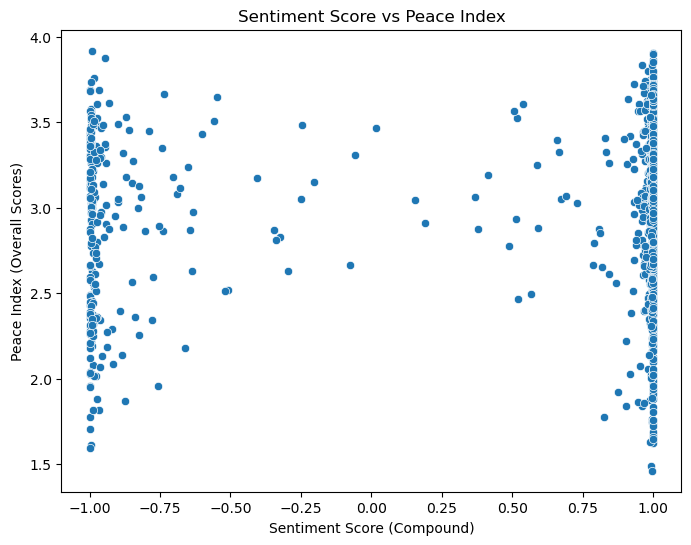

In [6]:
# Set up sentiment analysis
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis on cleaned speeches
df['sentiment_score'] = df['cleaned_speech'].apply(lambda x: sia.polarity_scores(x)['compound'])

# EDA 1: Correlation between sentiment score and peace index
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='sentiment_score', y='Overall Scores')
plt.title('Sentiment Score vs Peace Index')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Peace Index (Overall Scores)')
plt.show()

In [7]:
# EDA 2: Topic modeling (LDA) on speeches
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Convert cleaned speeches to document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_speech'])

# LDA topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
human council states sustainable efforts need climate support new law
Topic 1:
today new human years time states war economic change peoples
Topic 2:
sustainable climate change efforts challenges support economic human community new
Topic 3:
region state arab efforts states terrorism political support israel council
Topic 4:
african support efforts republic government general economic political national community


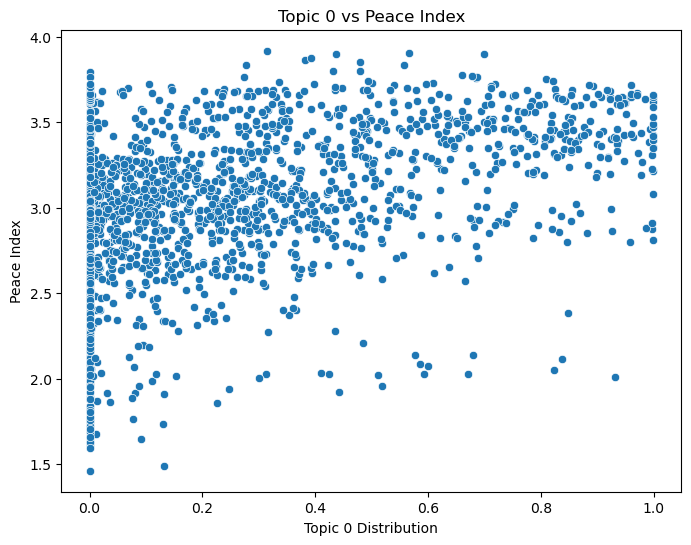

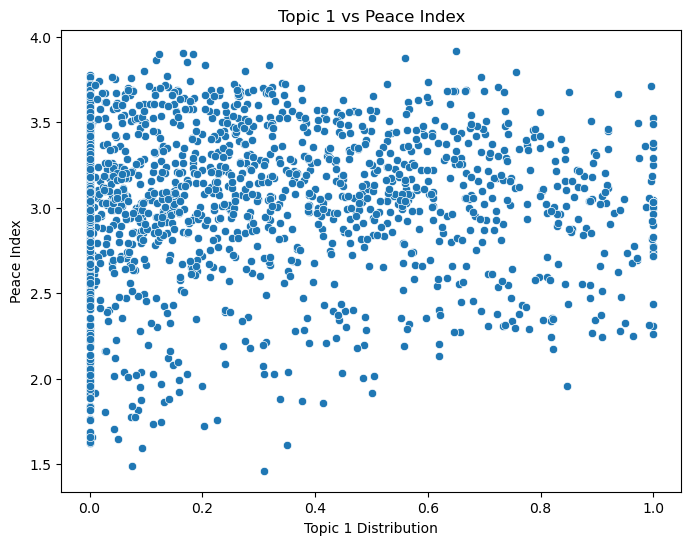

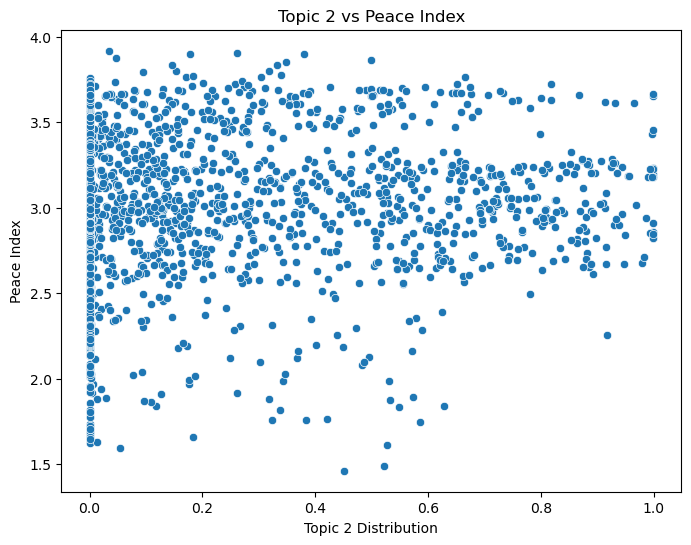

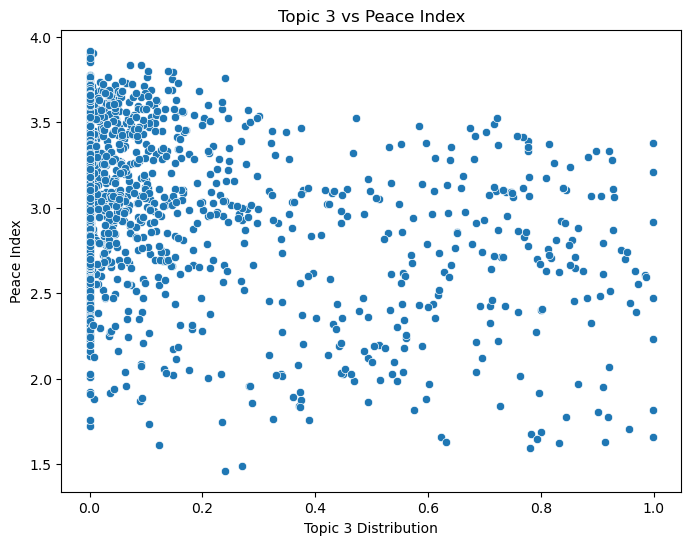

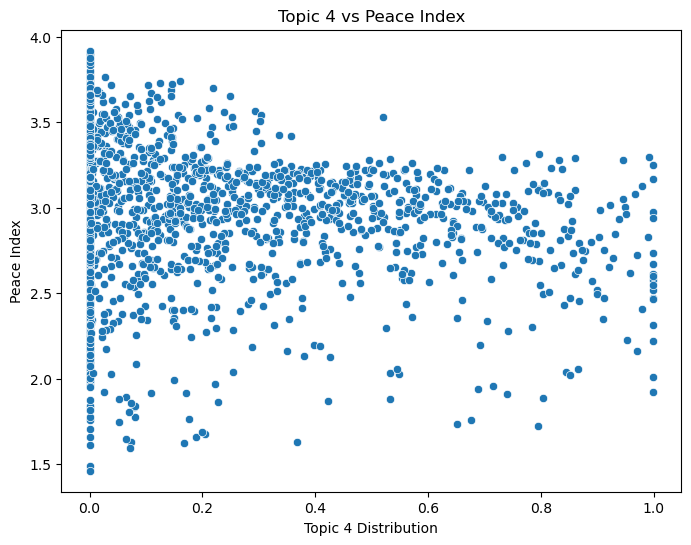

In [8]:
# EDA 3: Correlation of topic distribution and peace index
topic_dist = lda.transform(dtm)
df_topics = pd.DataFrame(topic_dist, columns=[f'Topic_{i}' for i in range(topic_dist.shape[1])])
df_with_topics = pd.concat([df, df_topics], axis=1)

# Plot correlation between topics and peace index
for i in range(topic_dist.shape[1]):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_with_topics[f'Topic_{i}'], y=df_with_topics['Overall Scores'])
    plt.title(f'Topic {i} vs Peace Index')
    plt.xlabel(f'Topic {i} Distribution')
    plt.ylabel('Peace Index')
    plt.show()

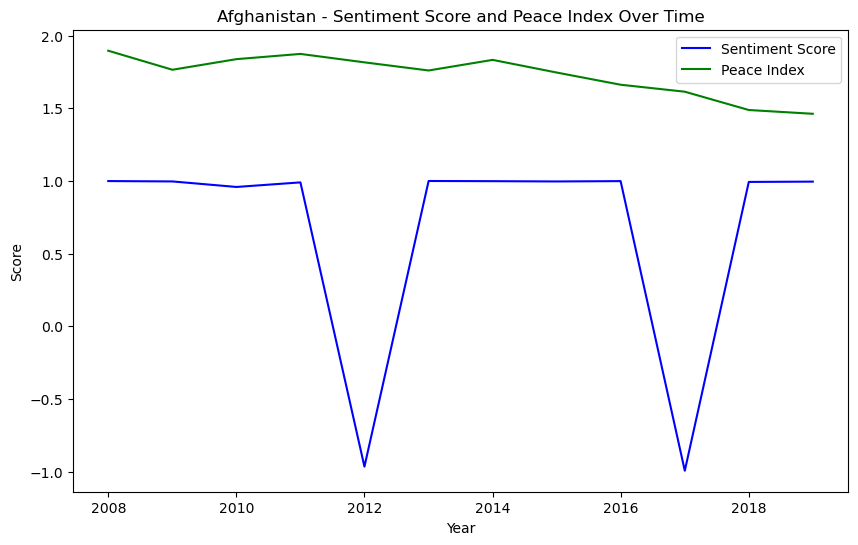

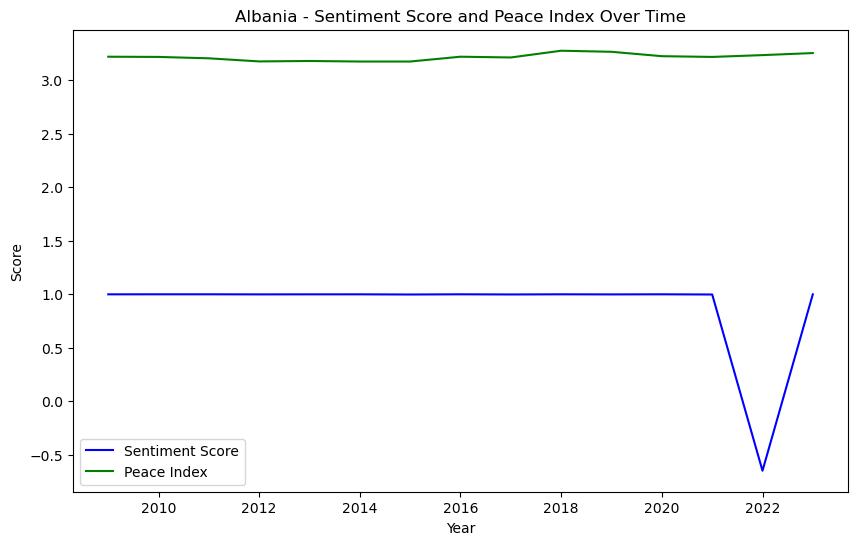

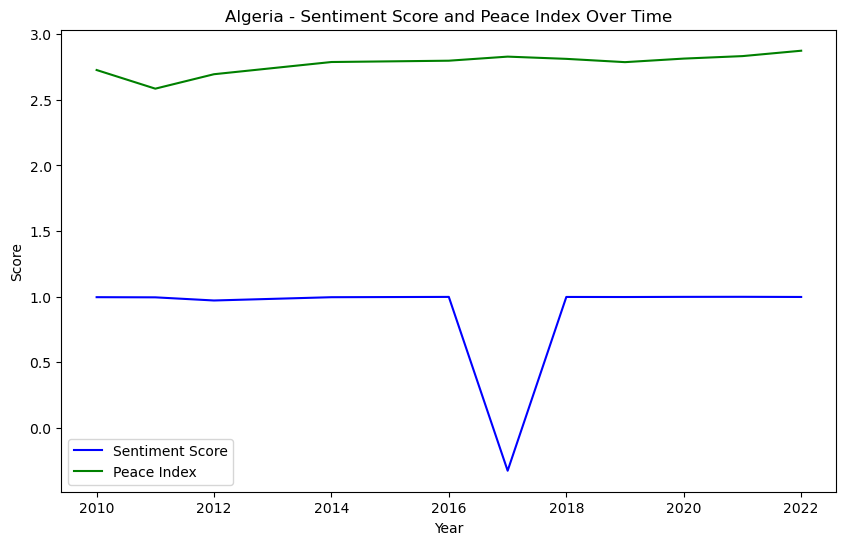

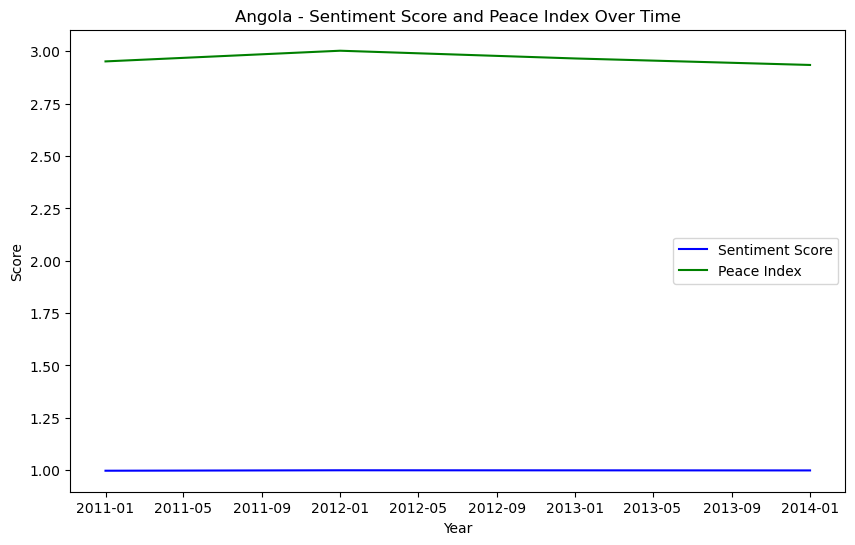

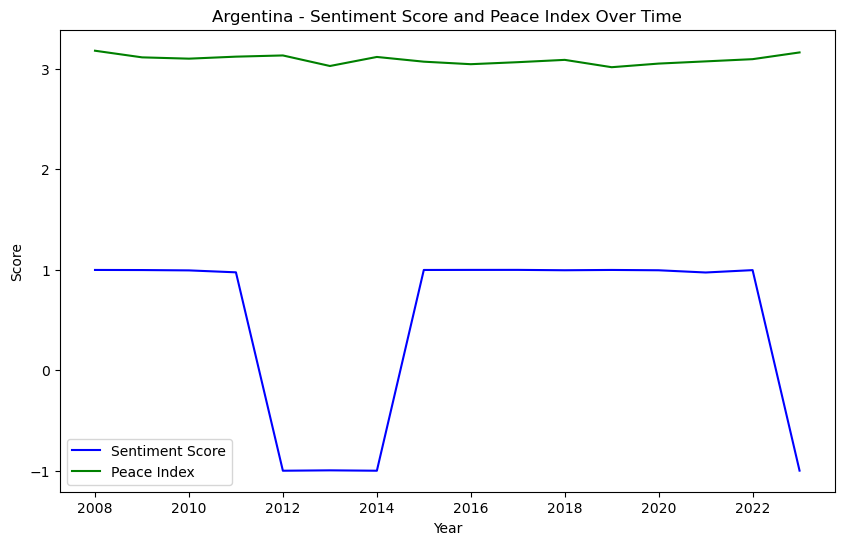

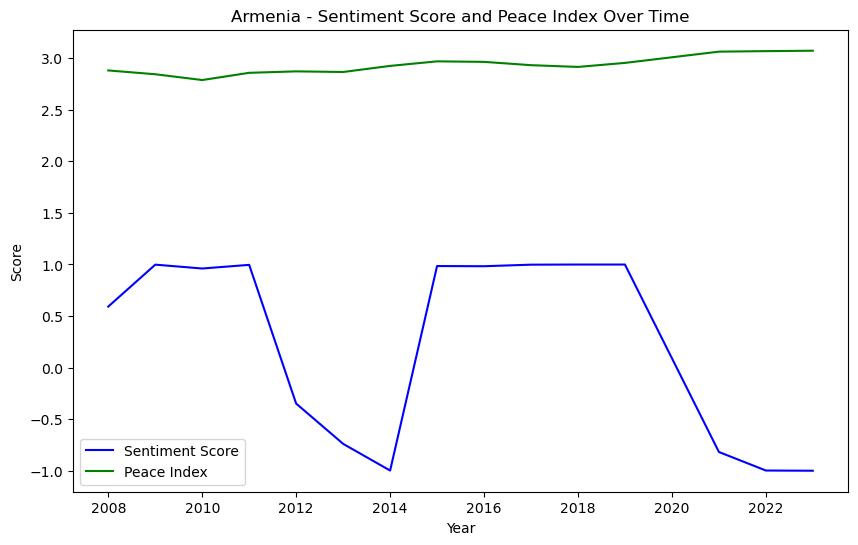

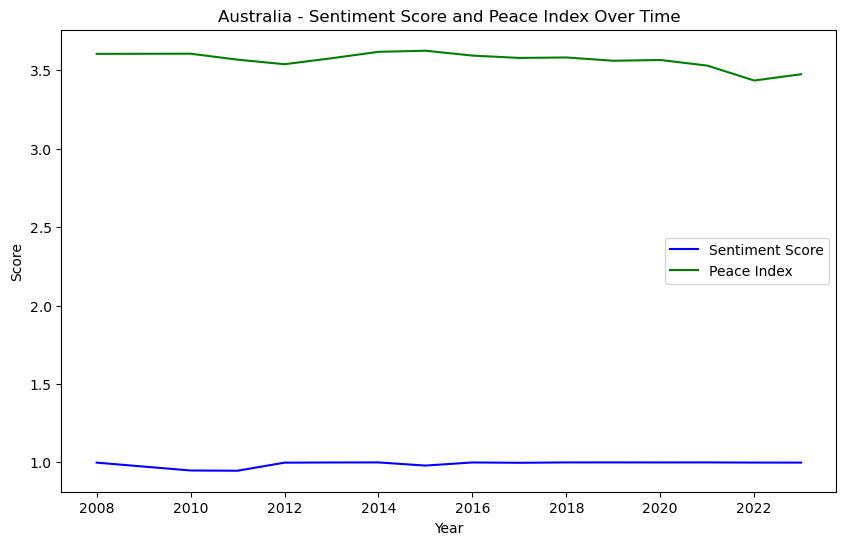

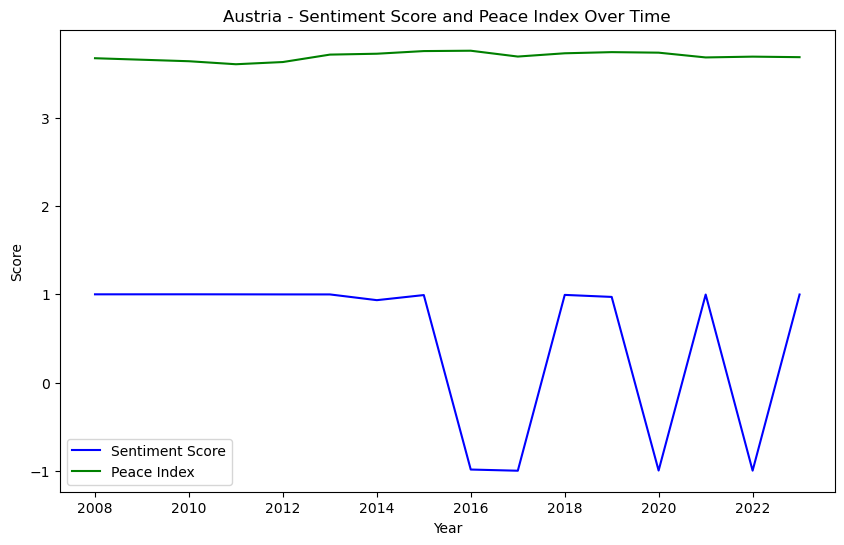

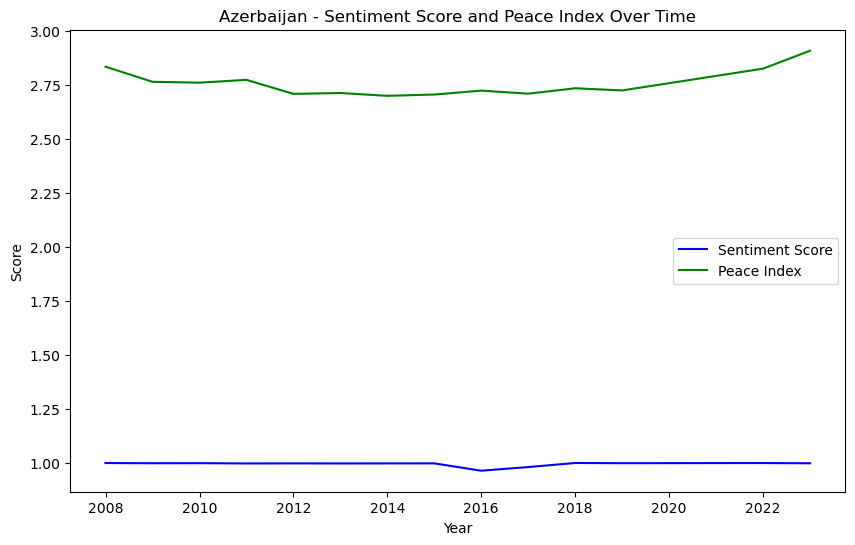

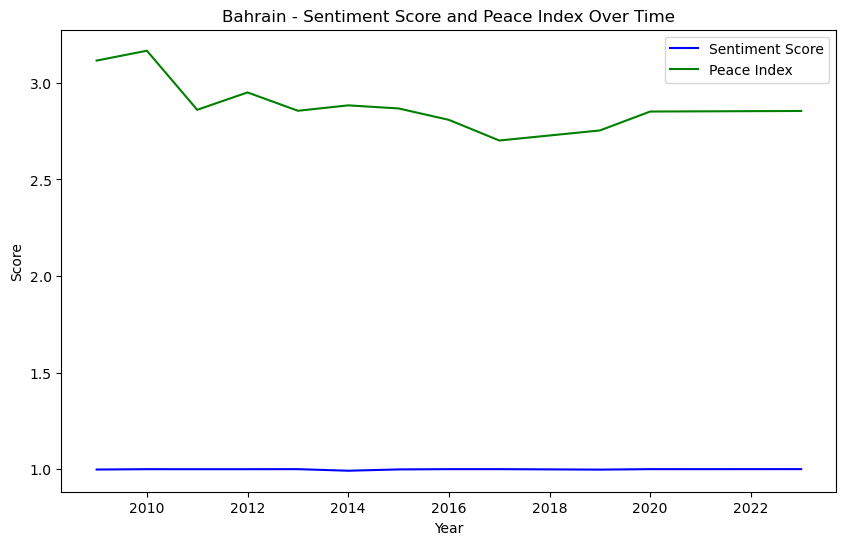

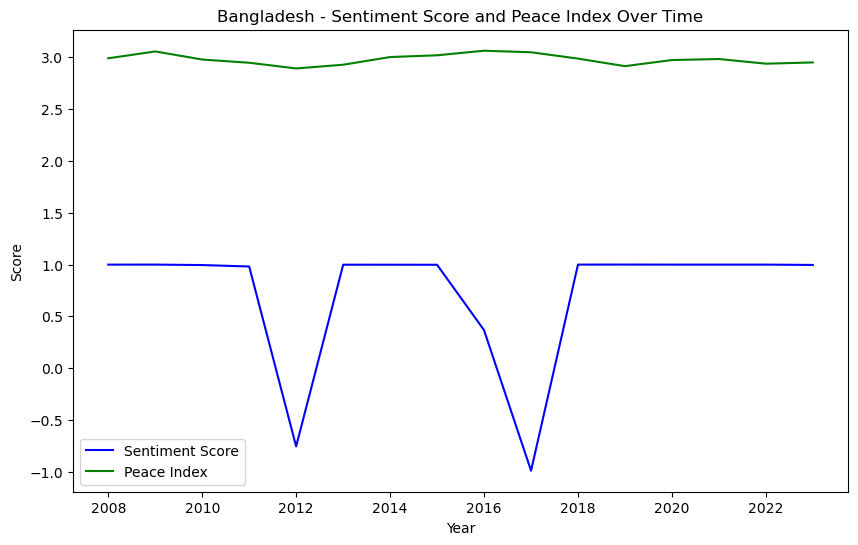

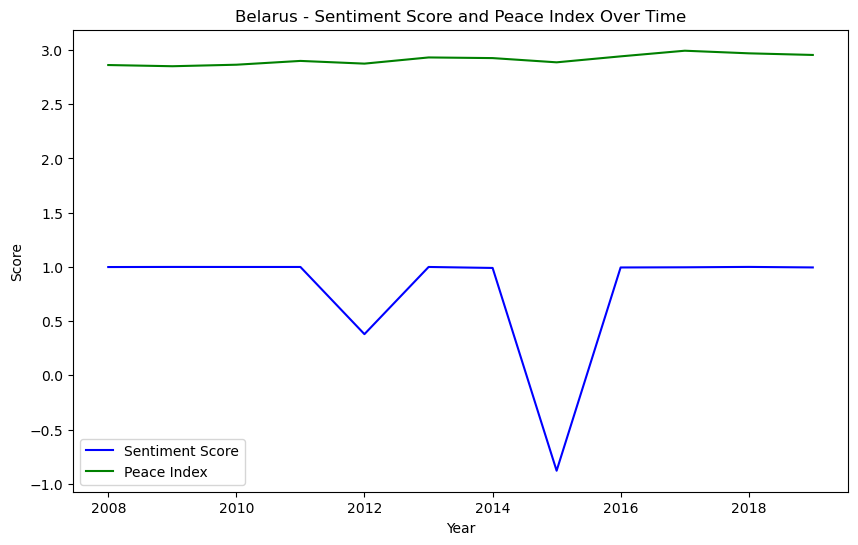

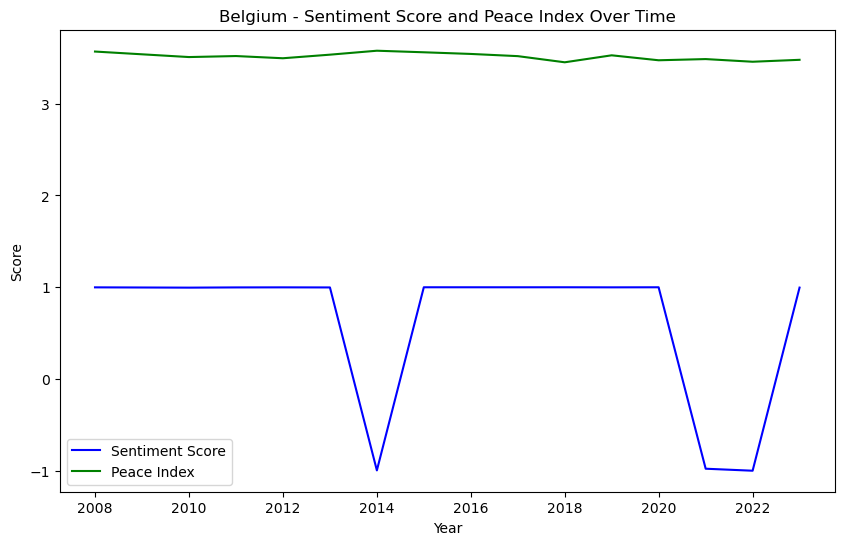

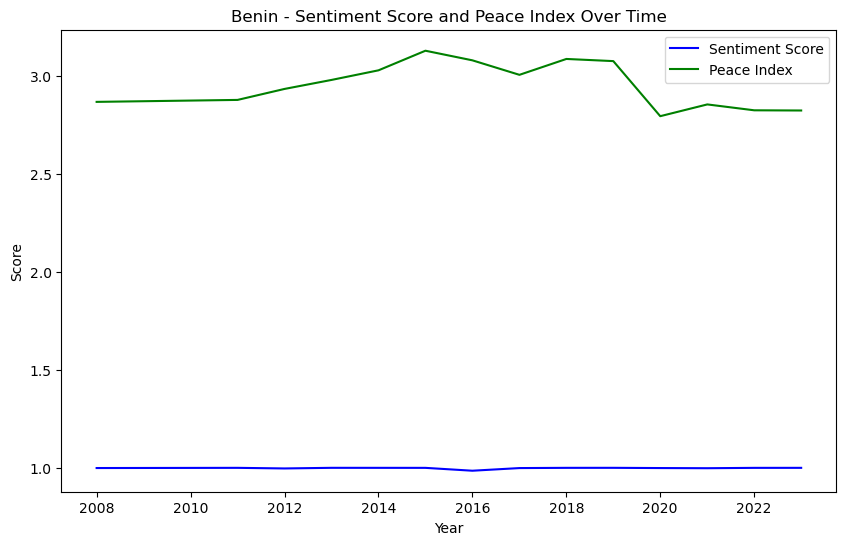

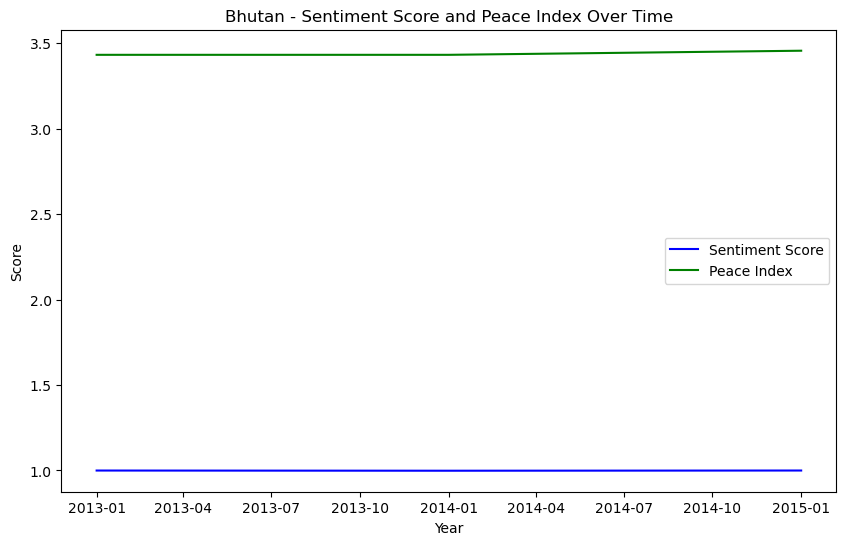

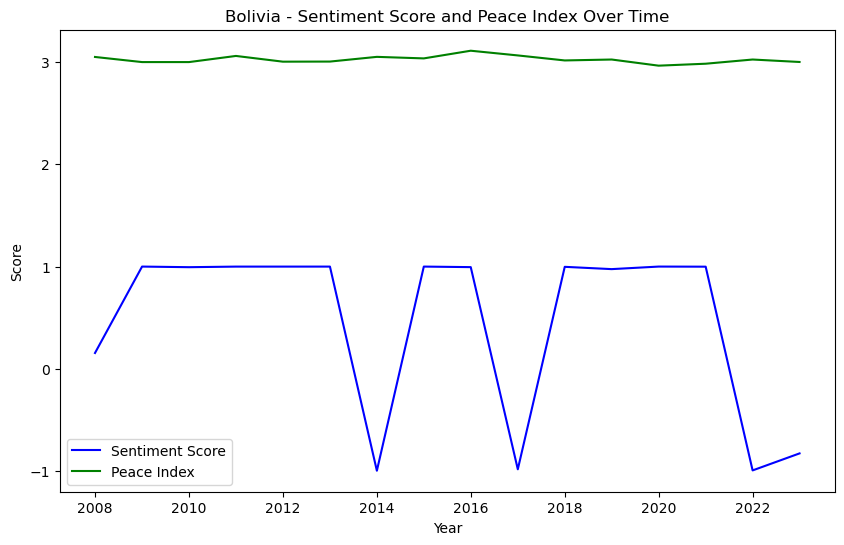

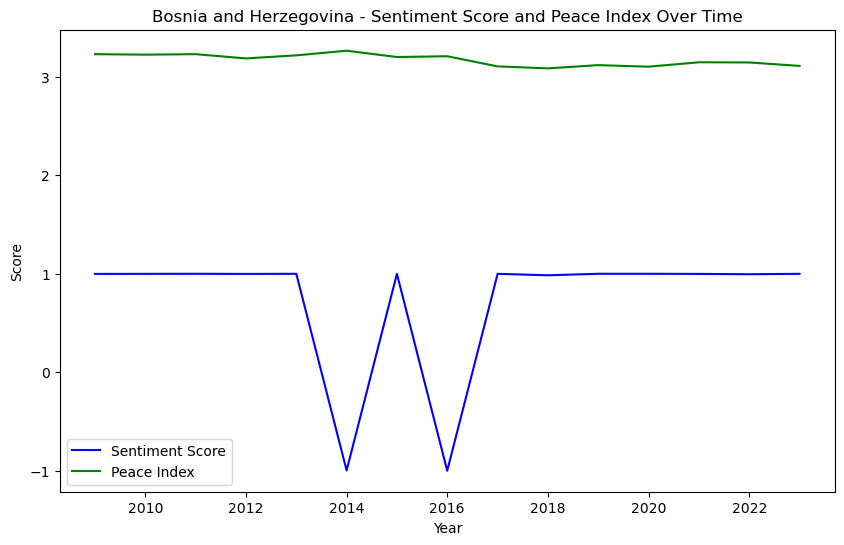

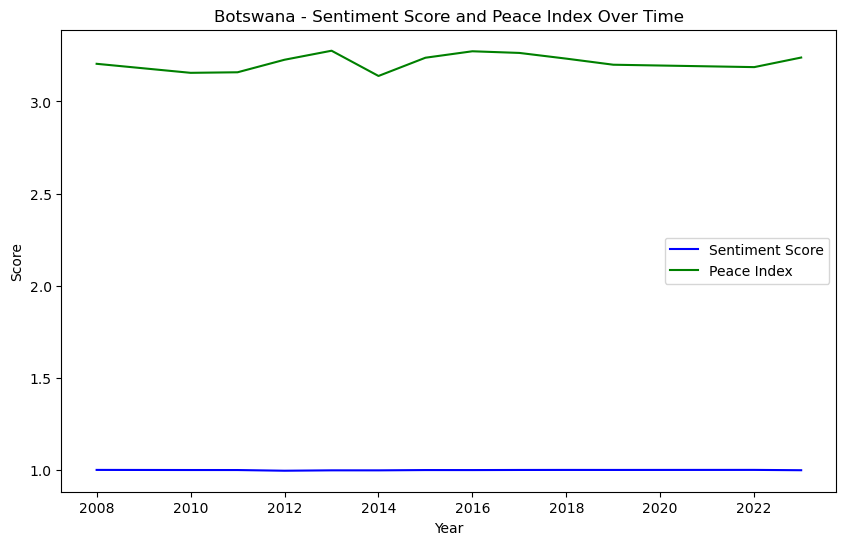

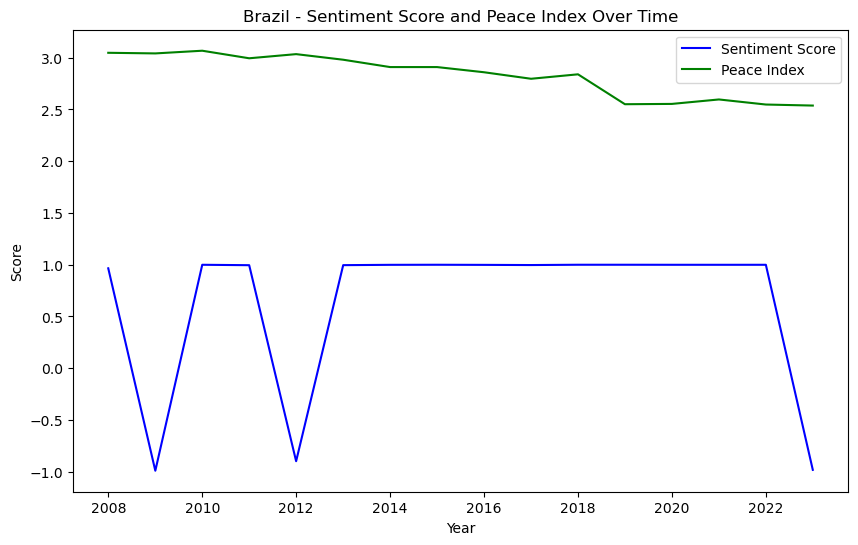

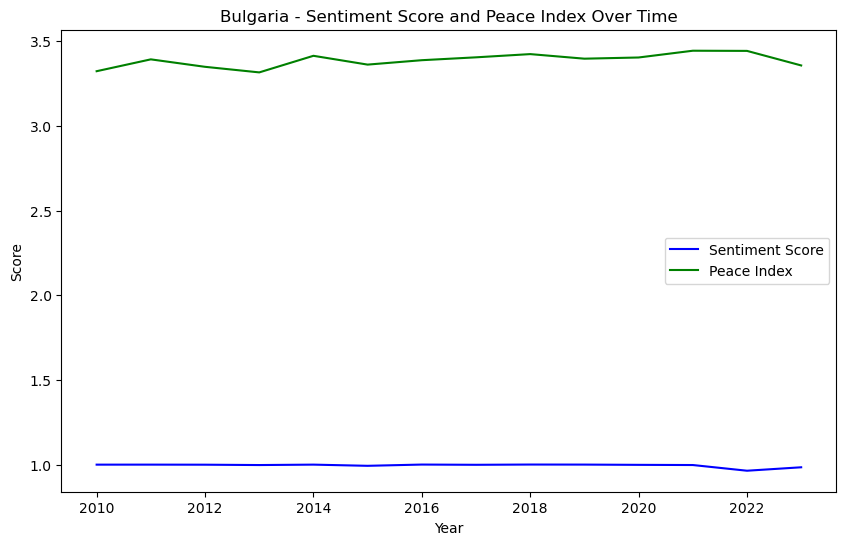

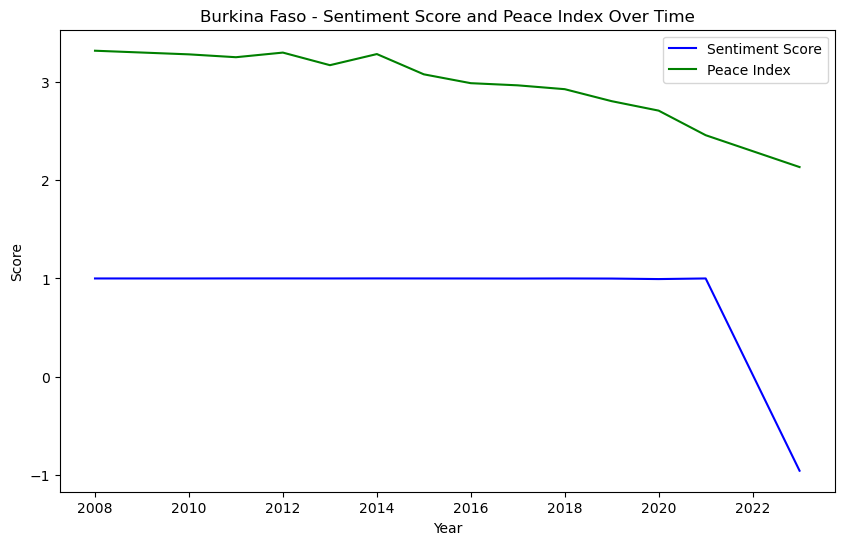

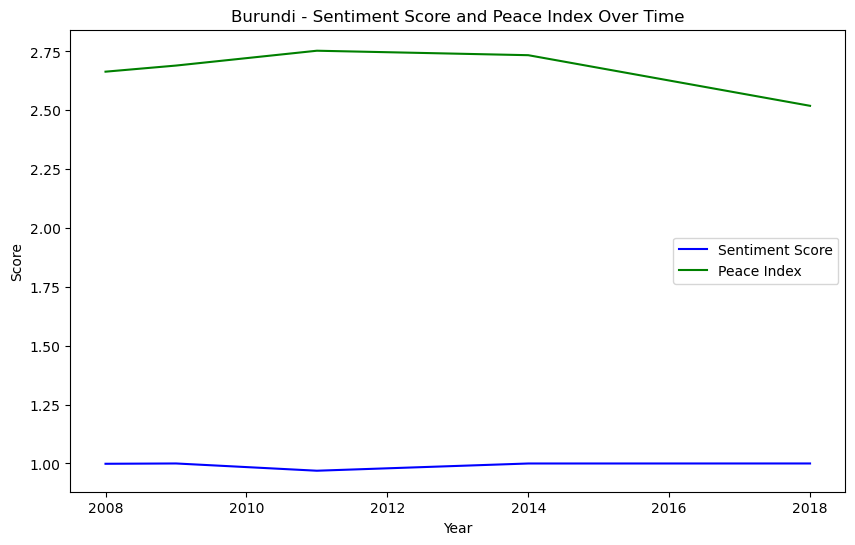

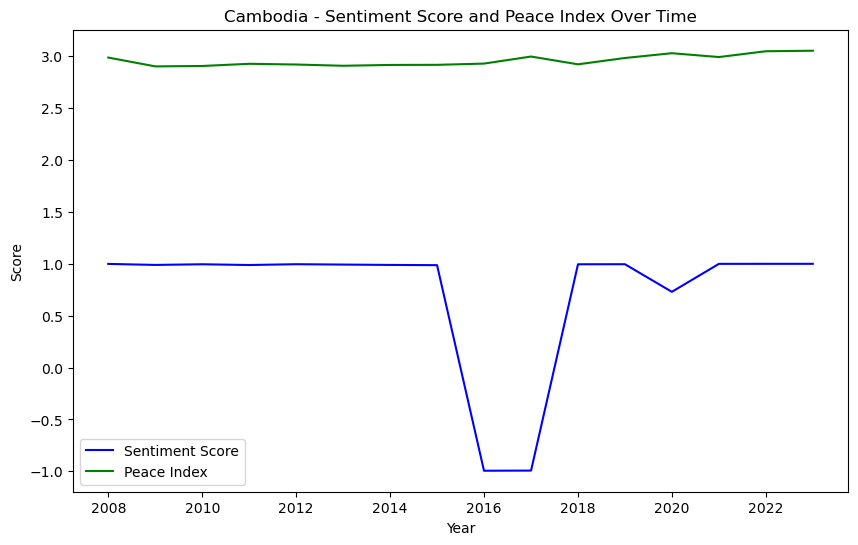

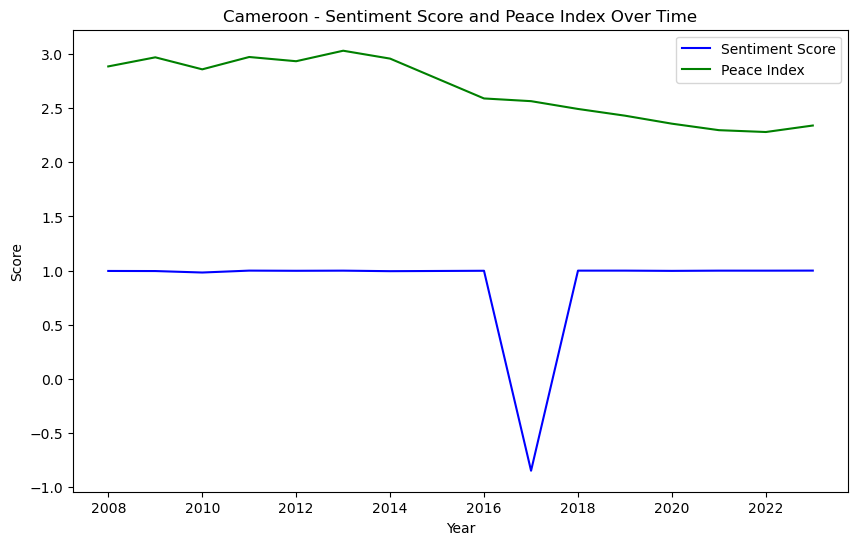

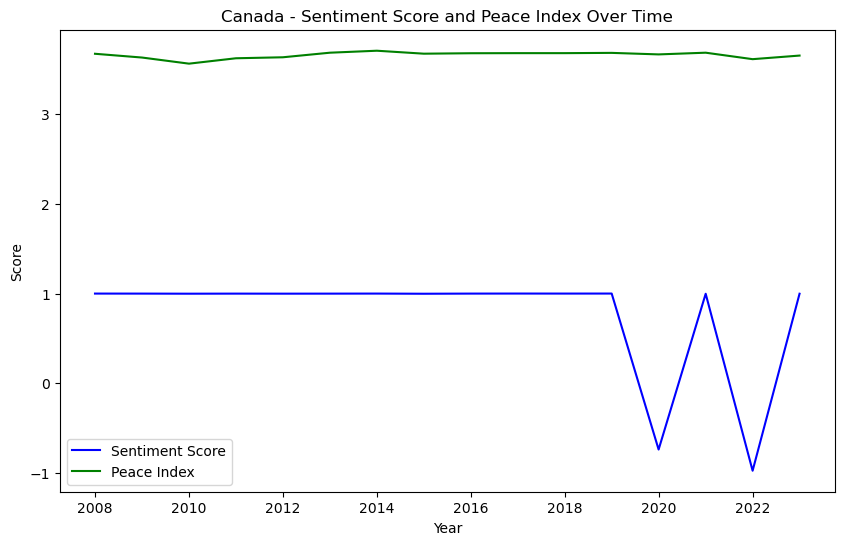

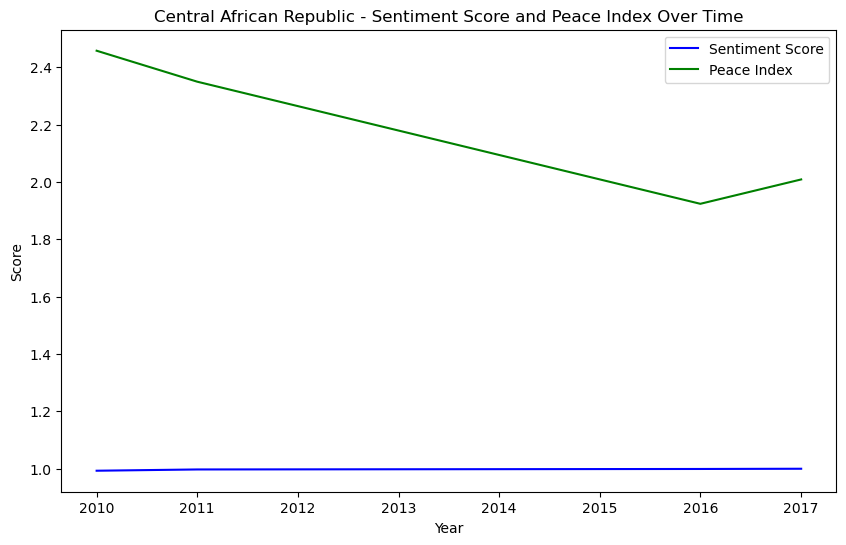

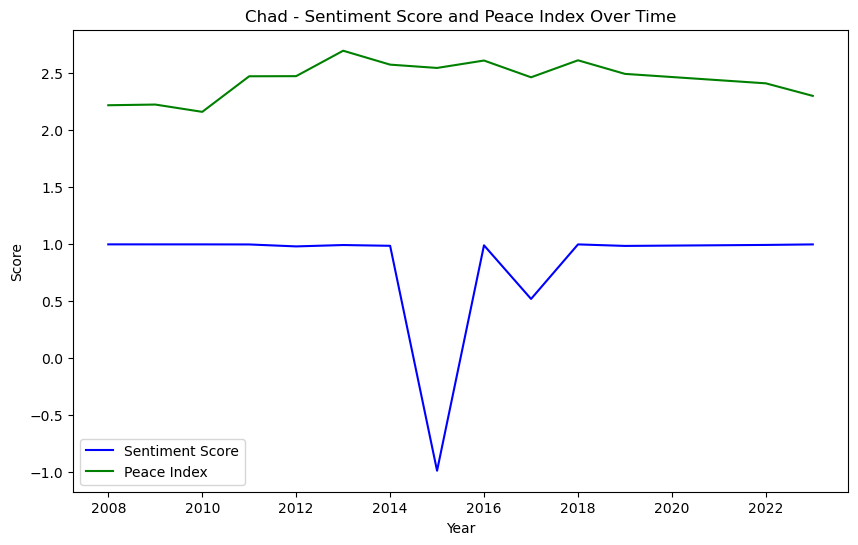

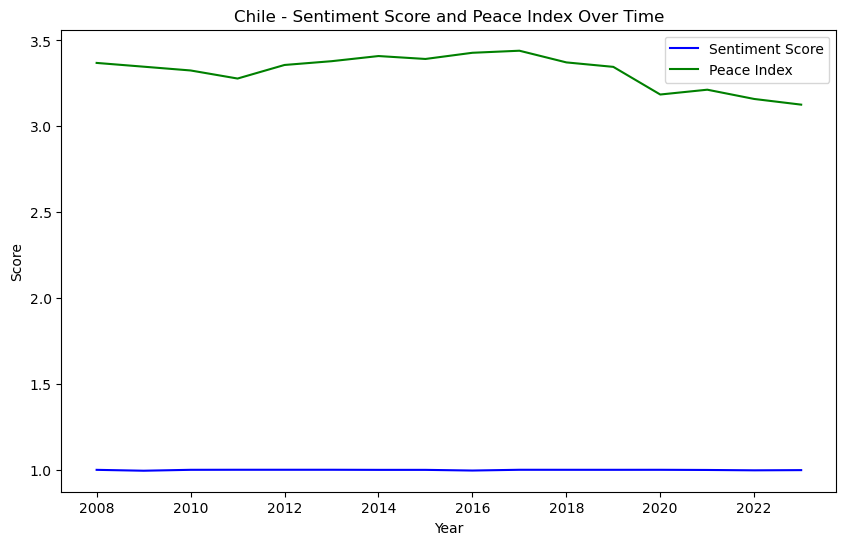

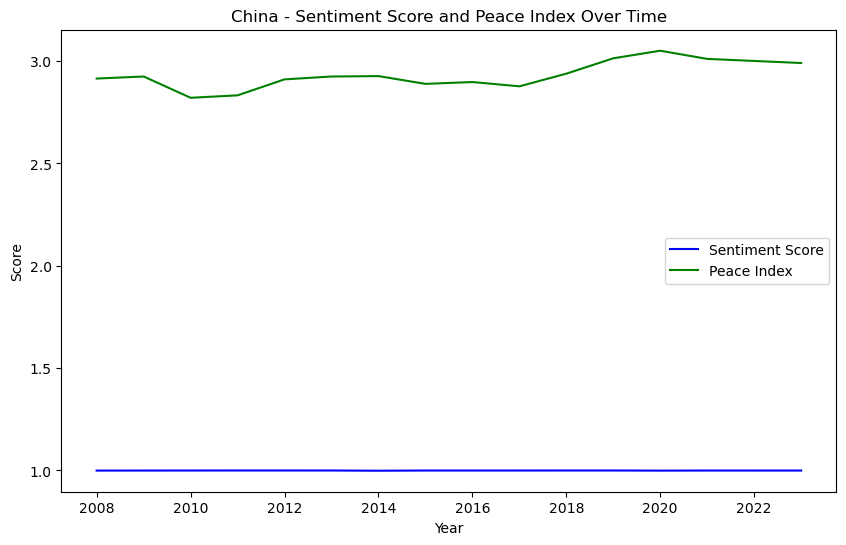

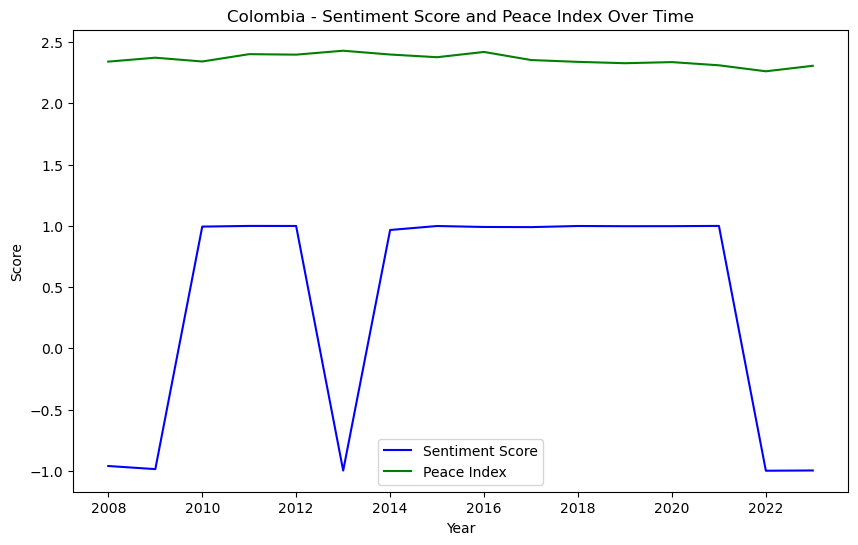

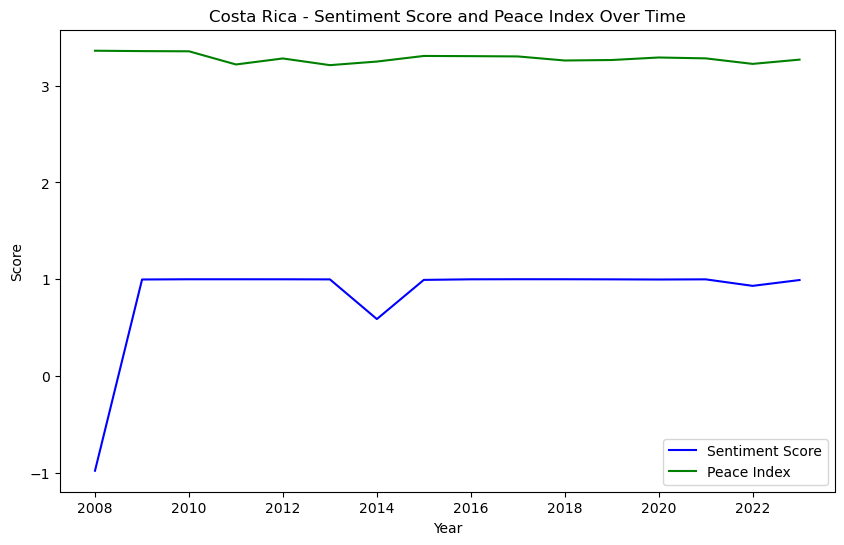

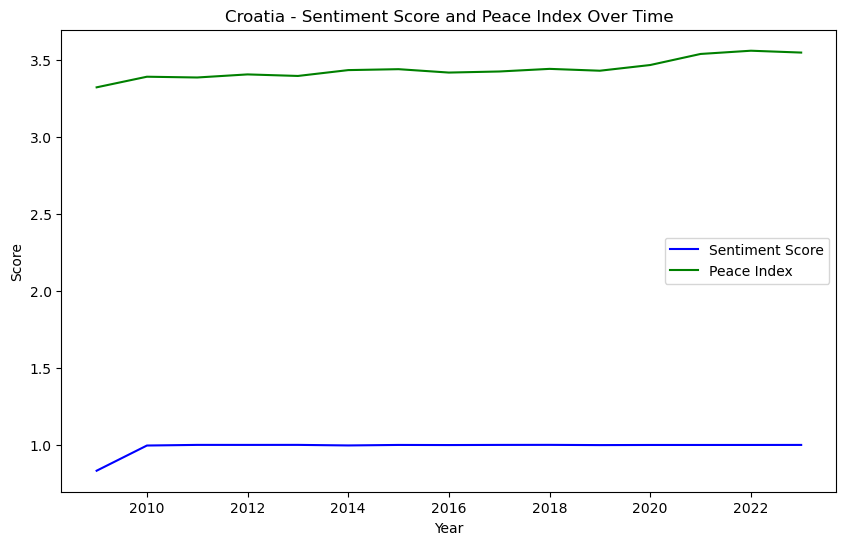

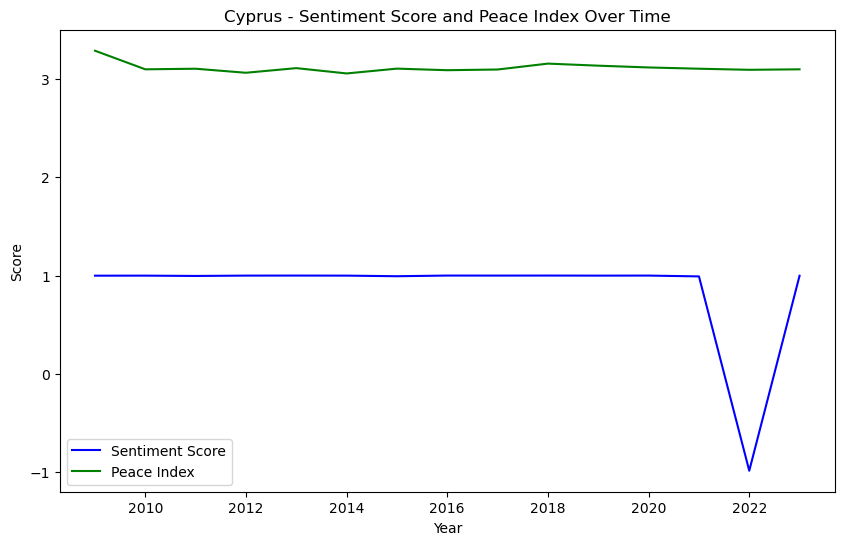

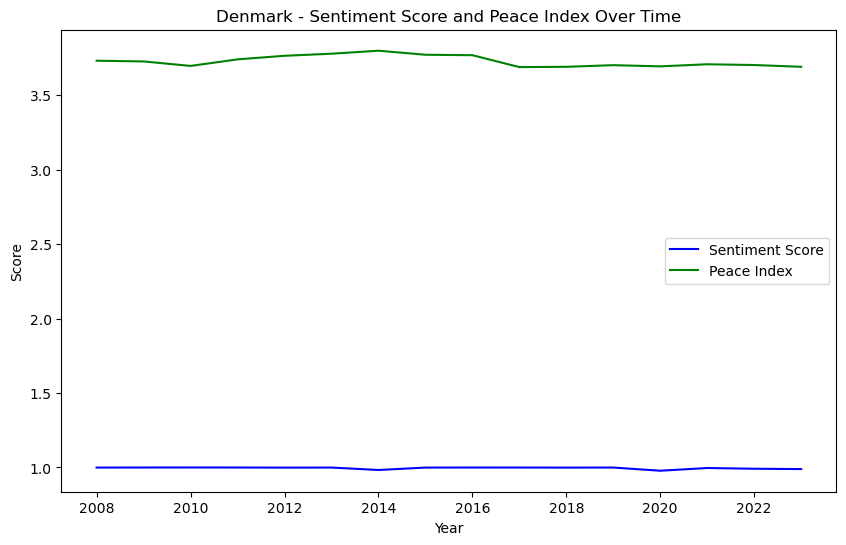

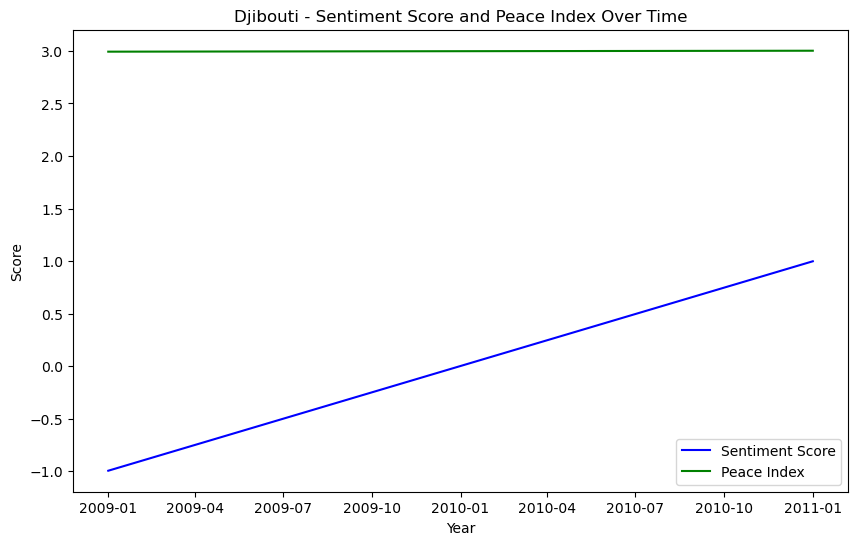

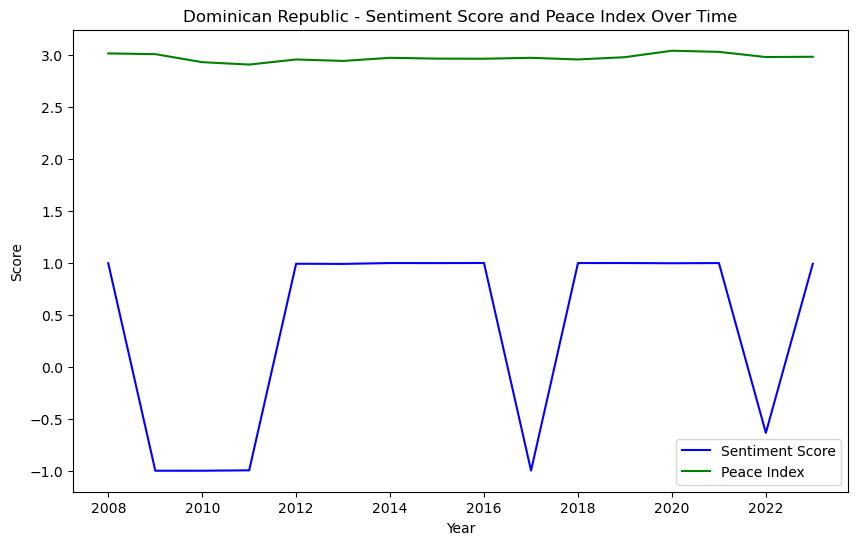

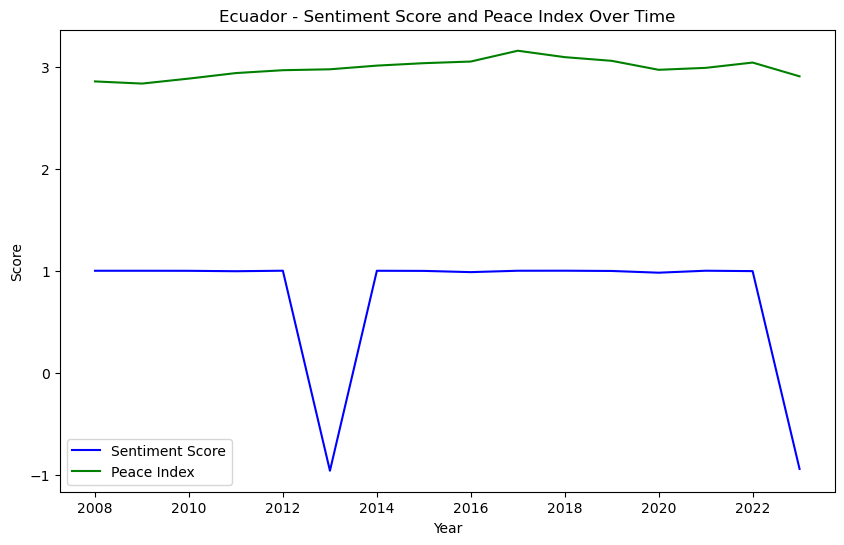

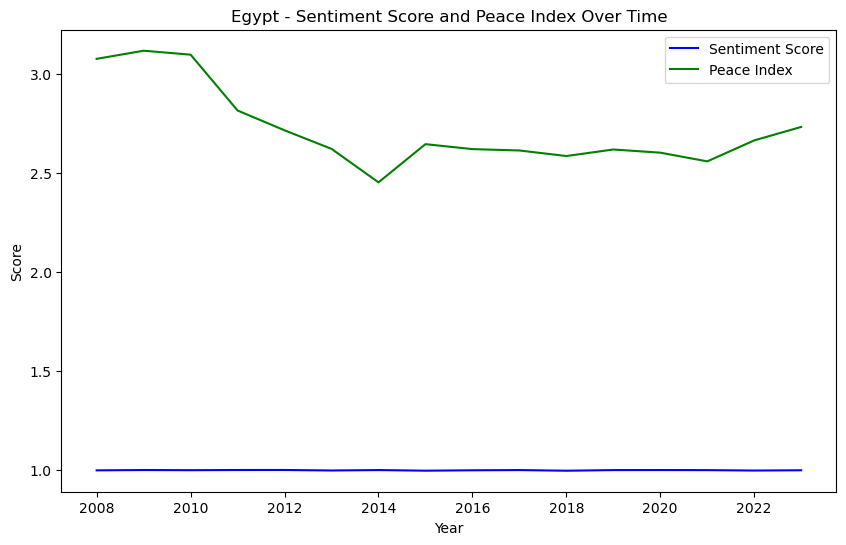

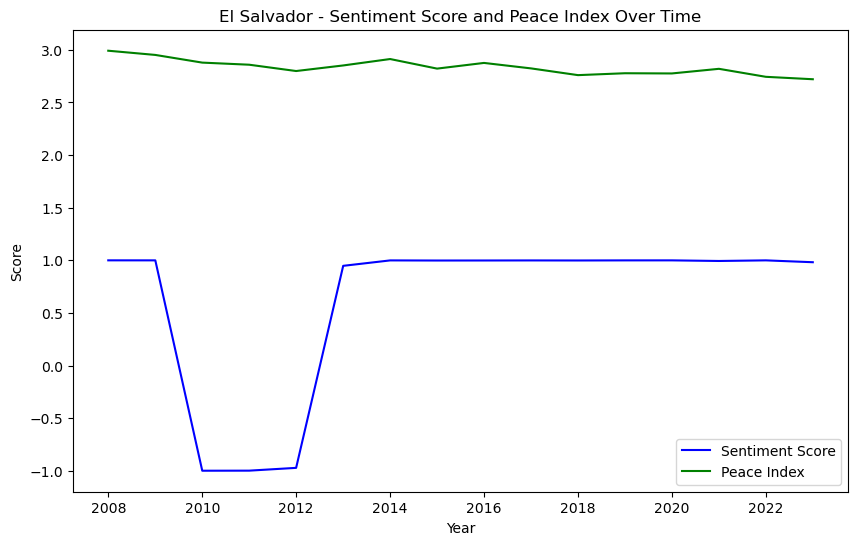

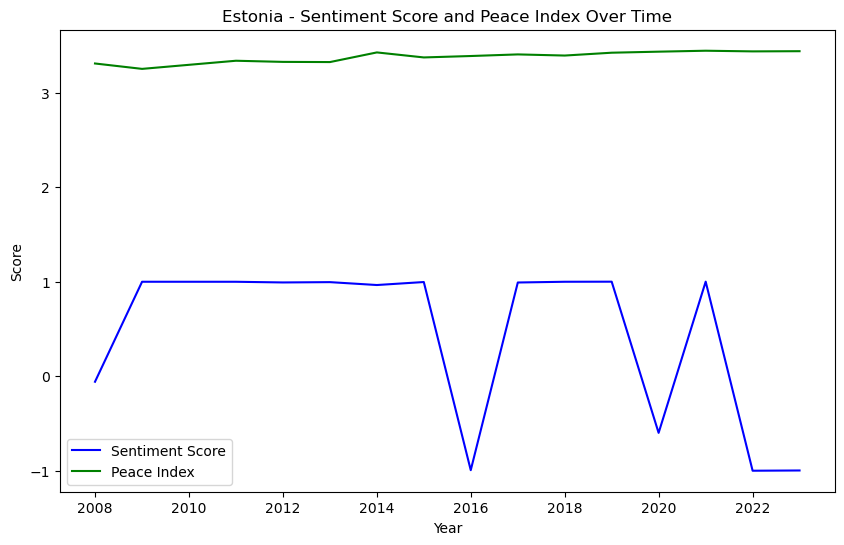

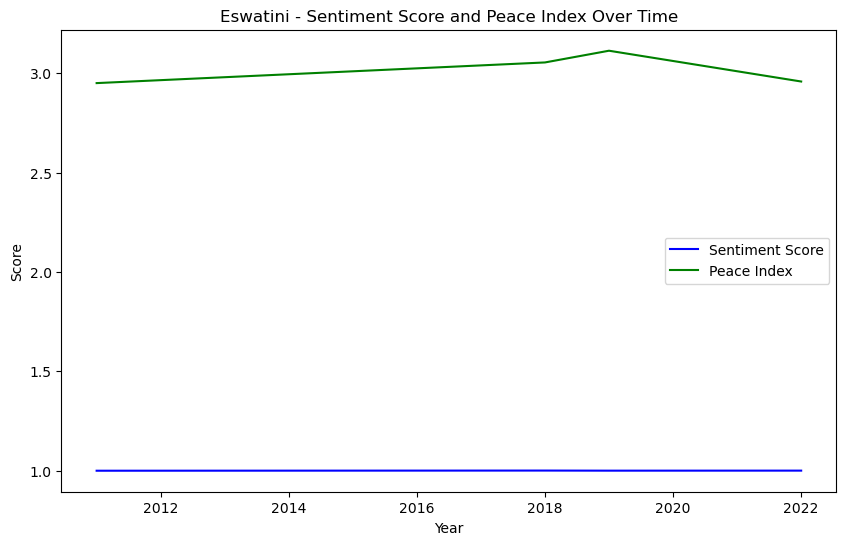

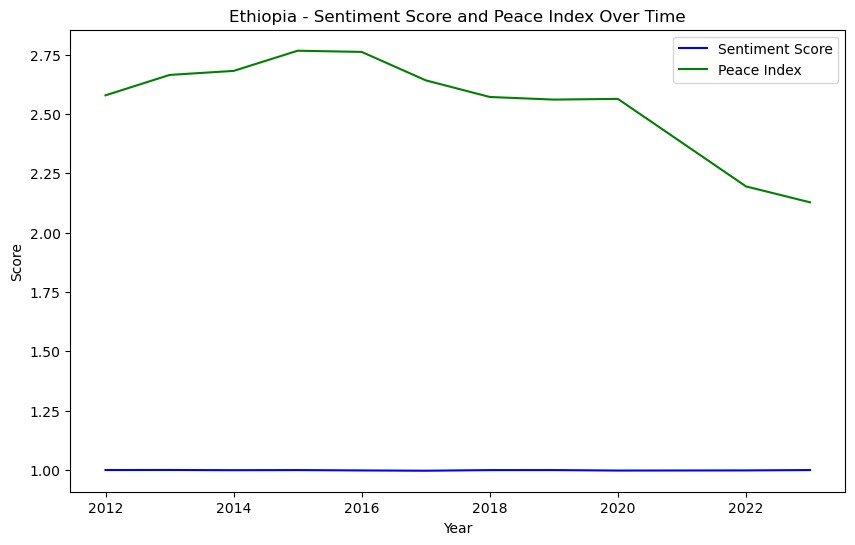

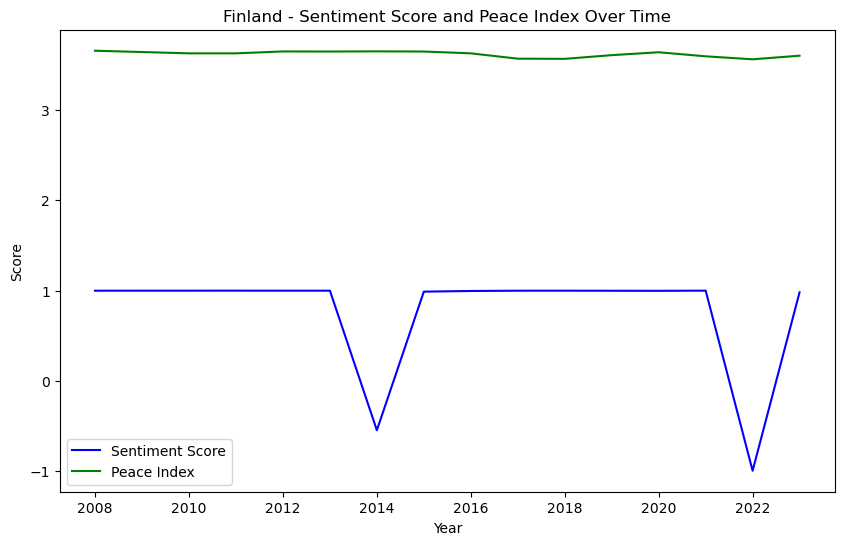

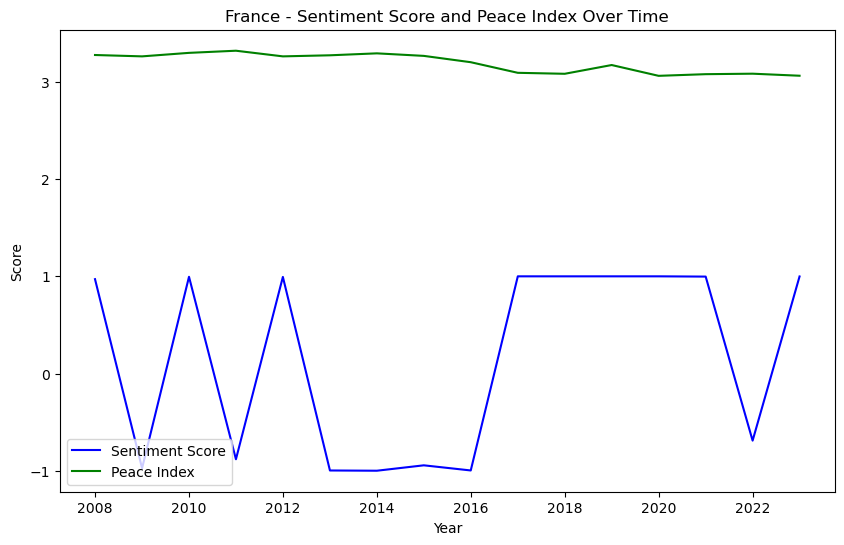

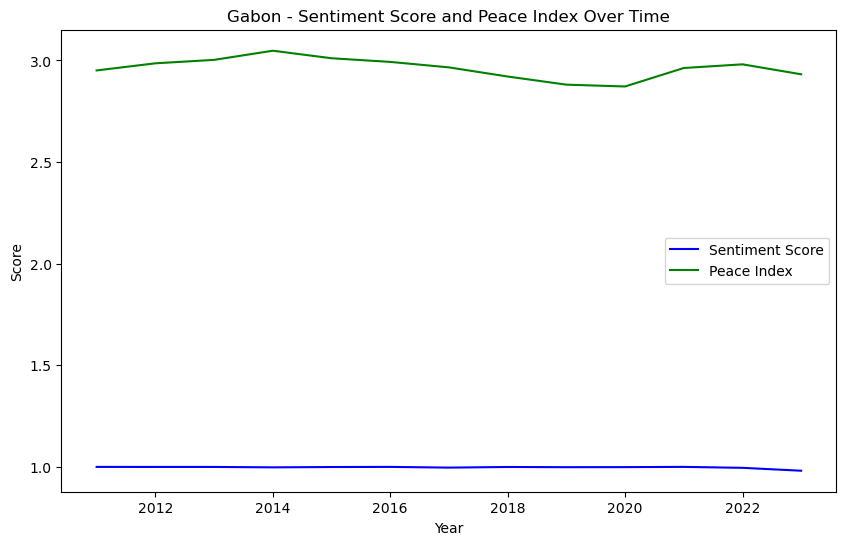

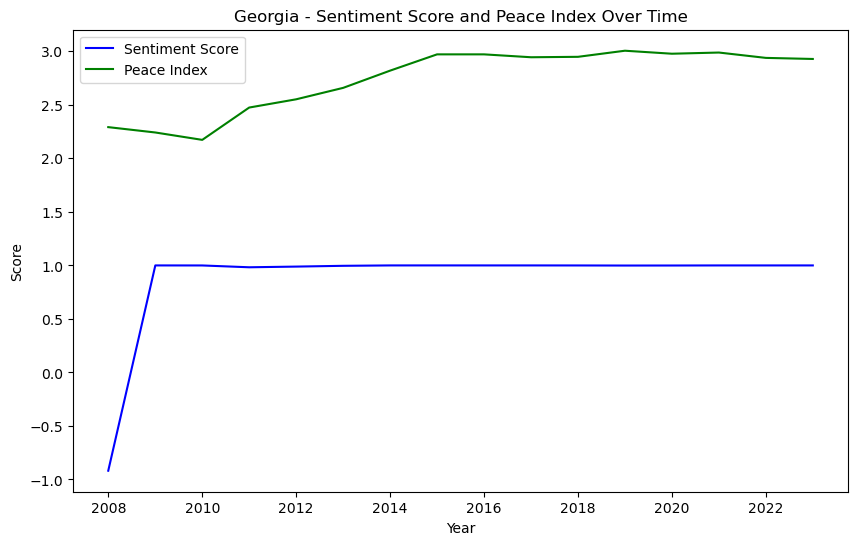

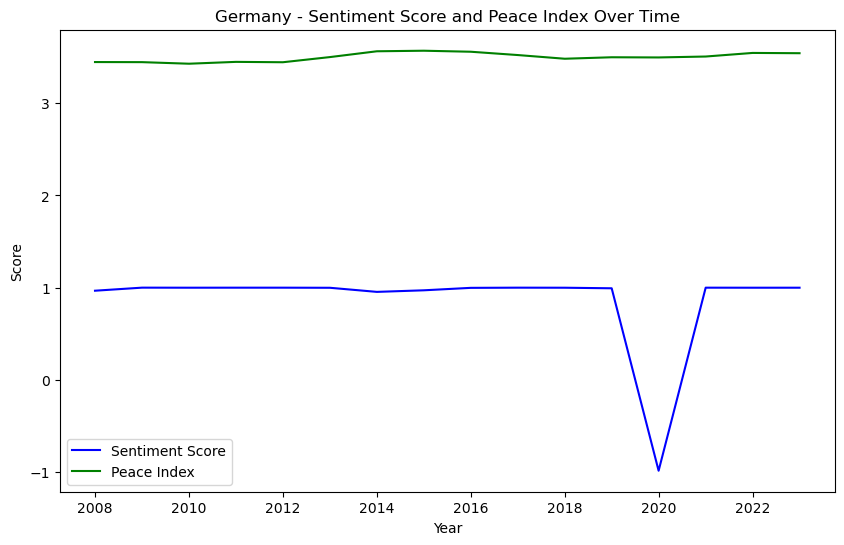

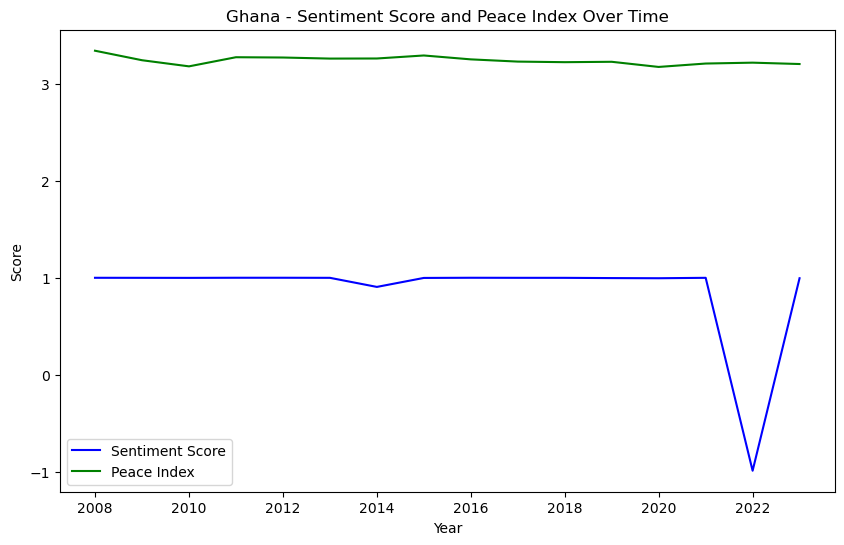

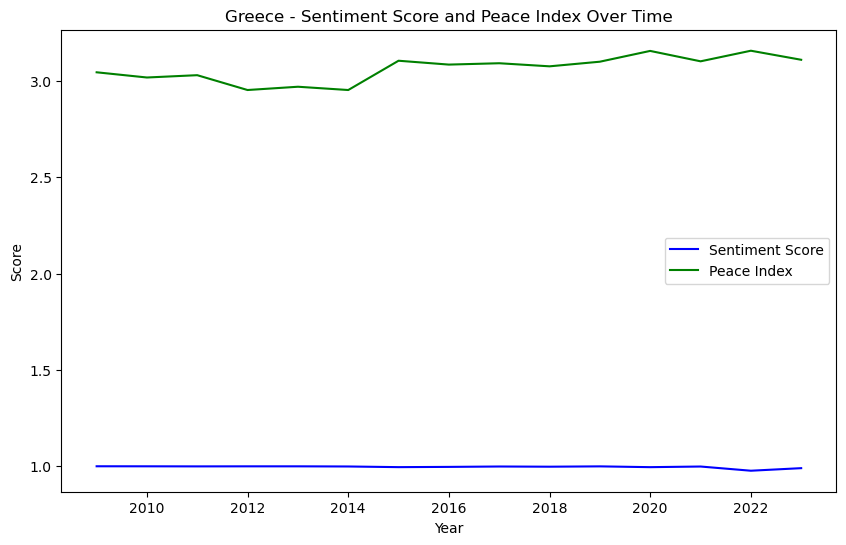

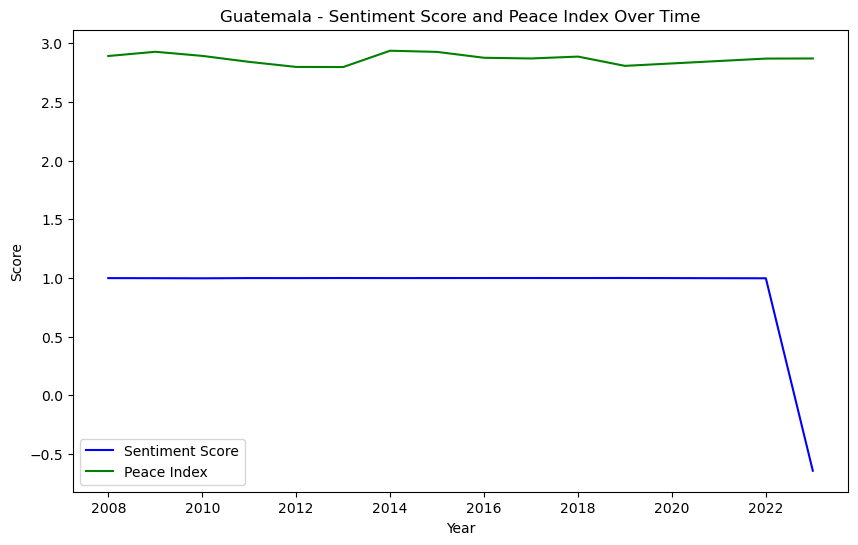

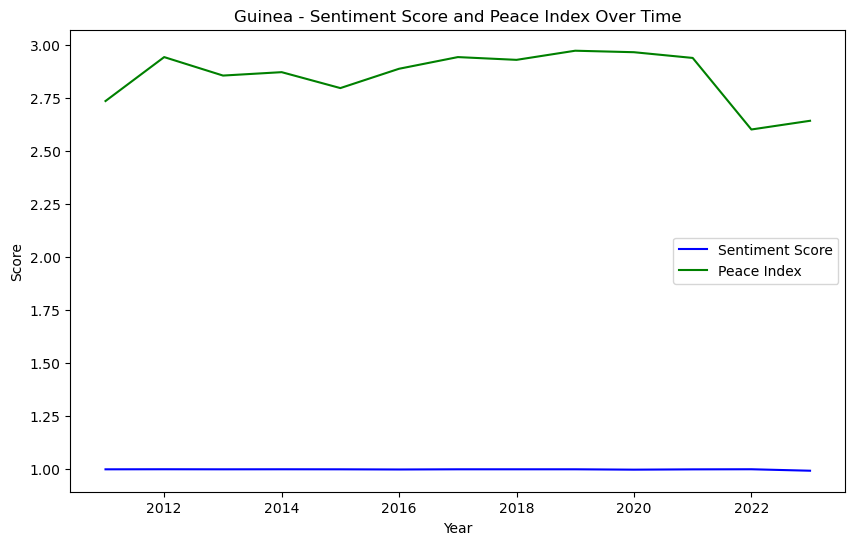

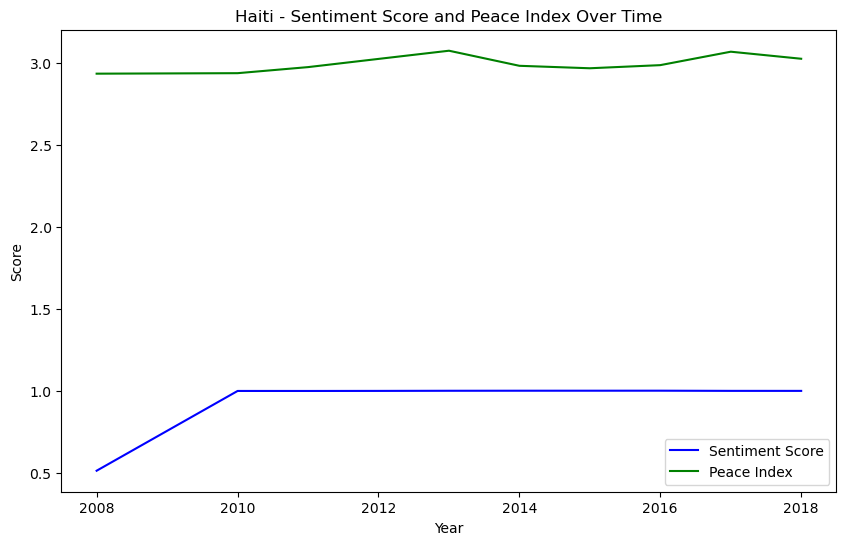

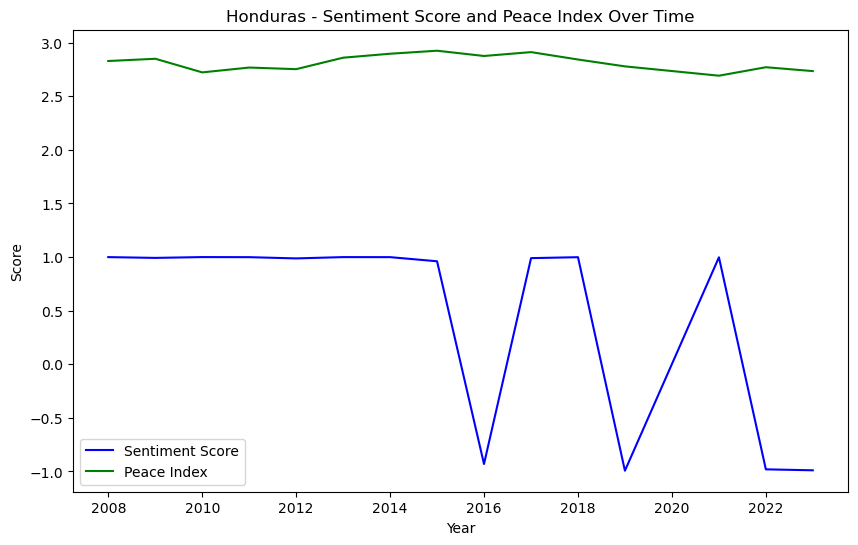

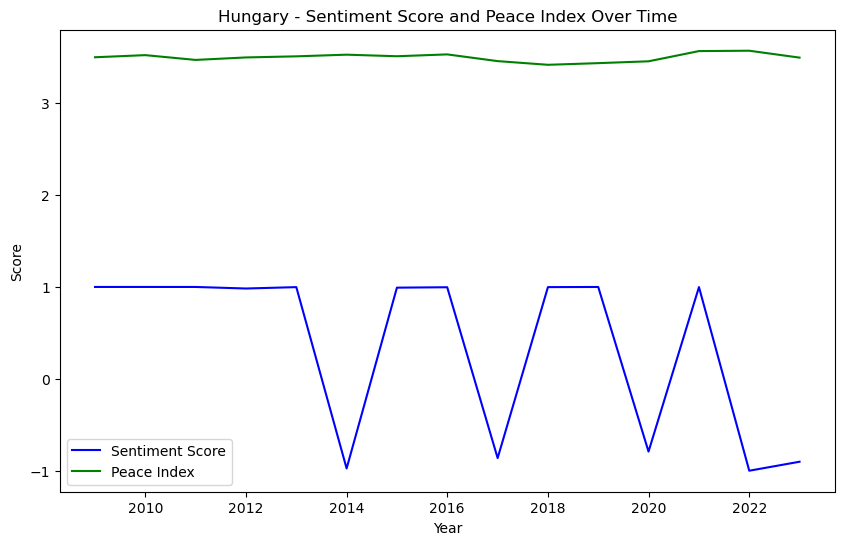

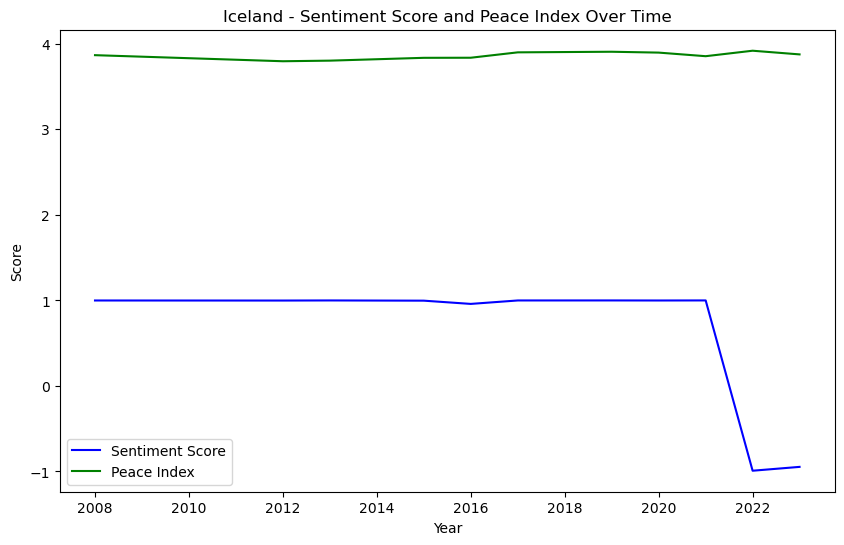

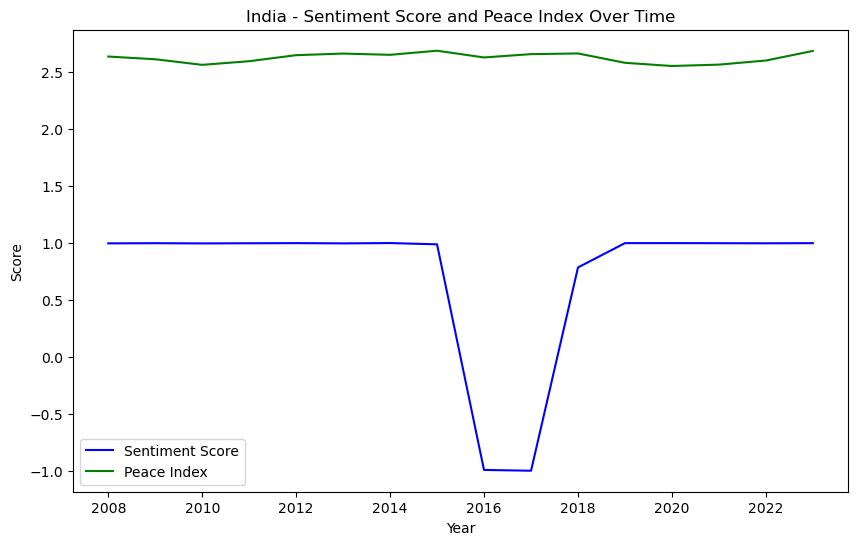

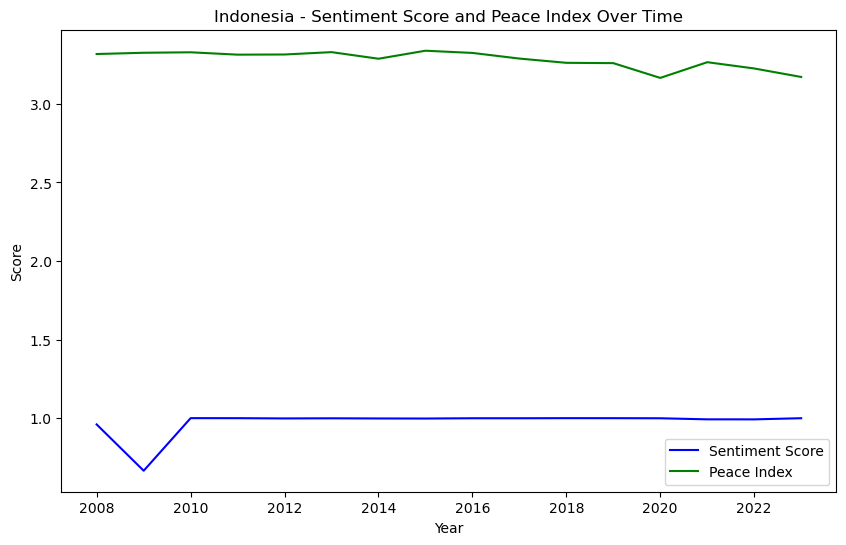

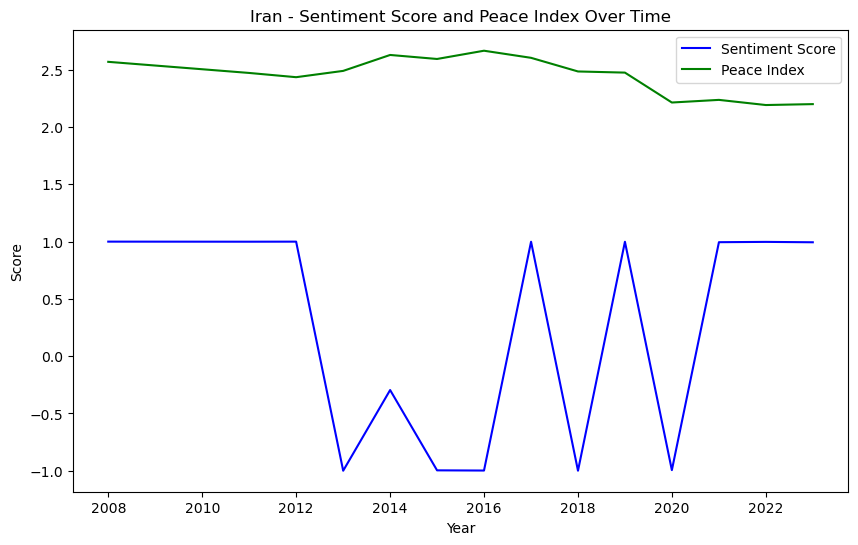

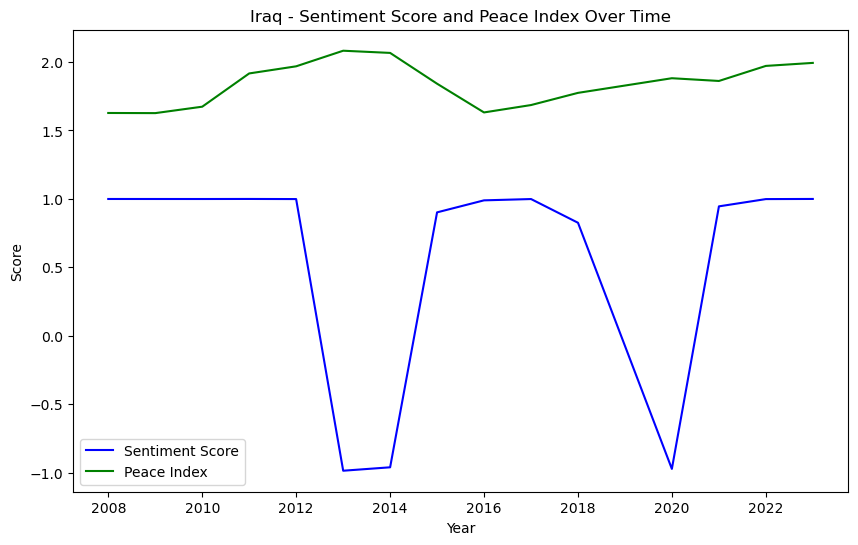

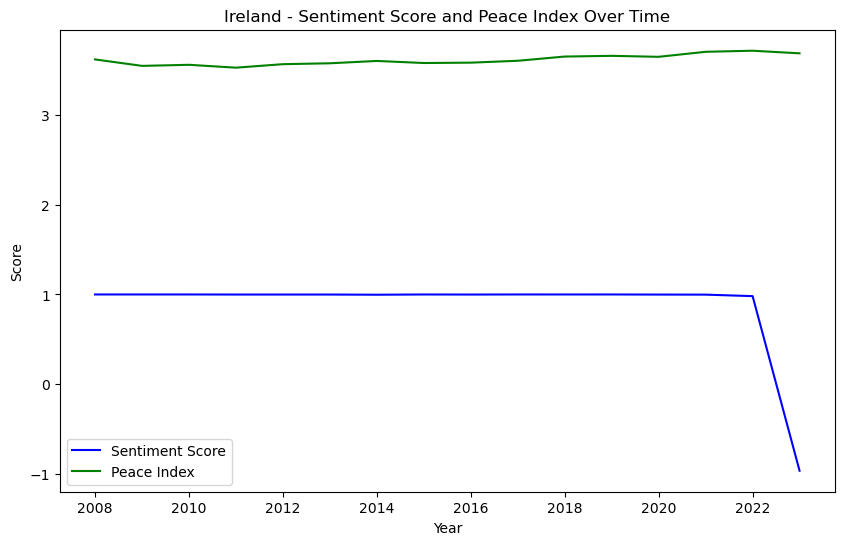

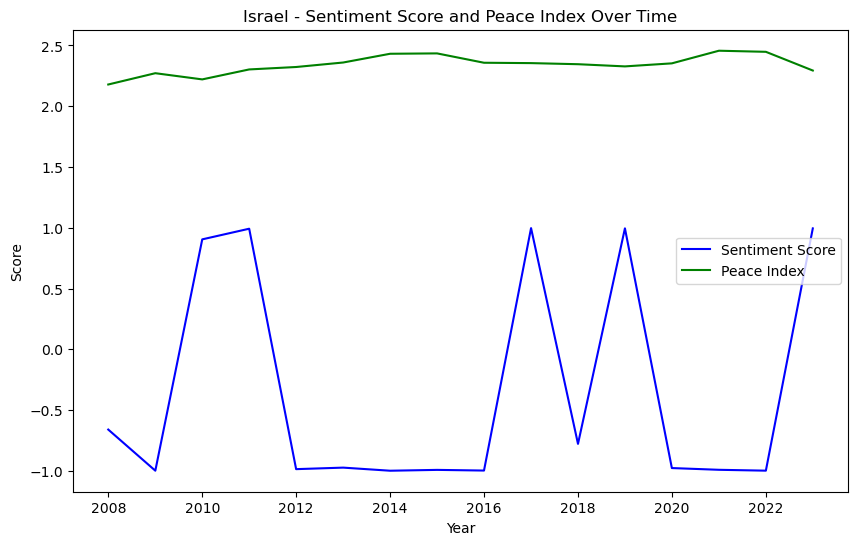

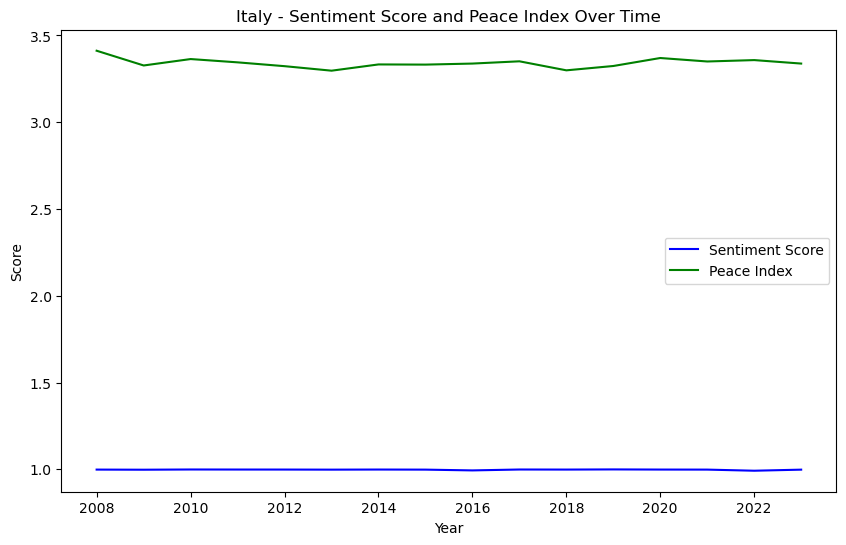

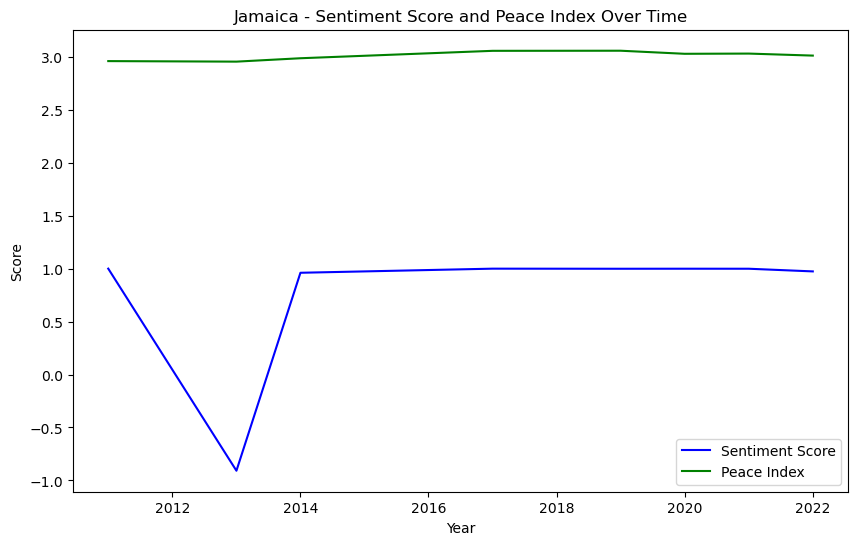

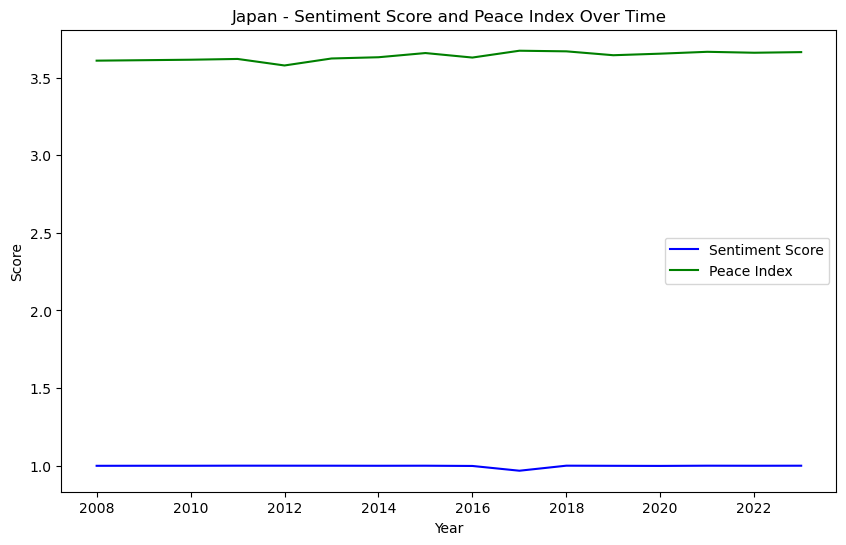

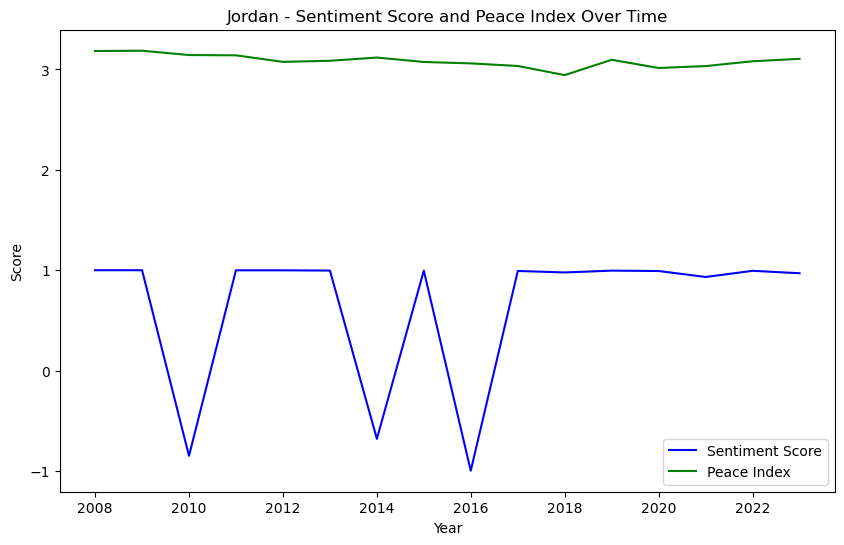

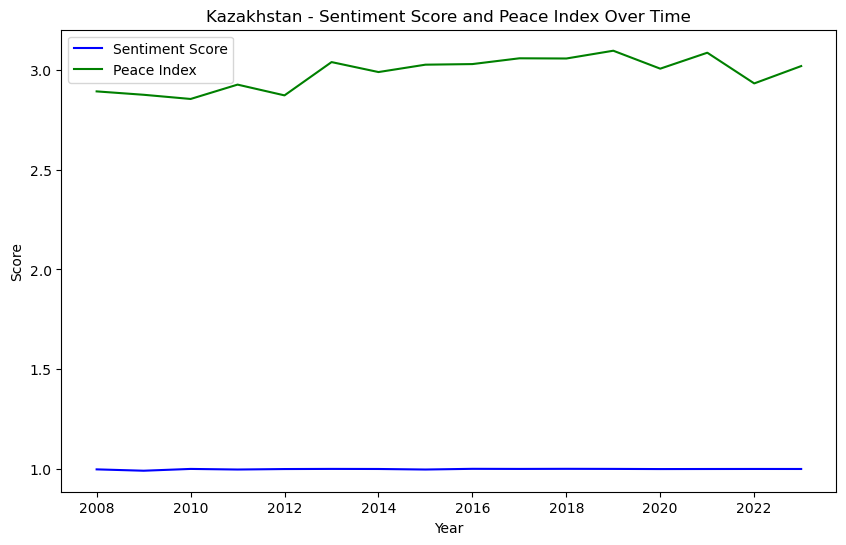

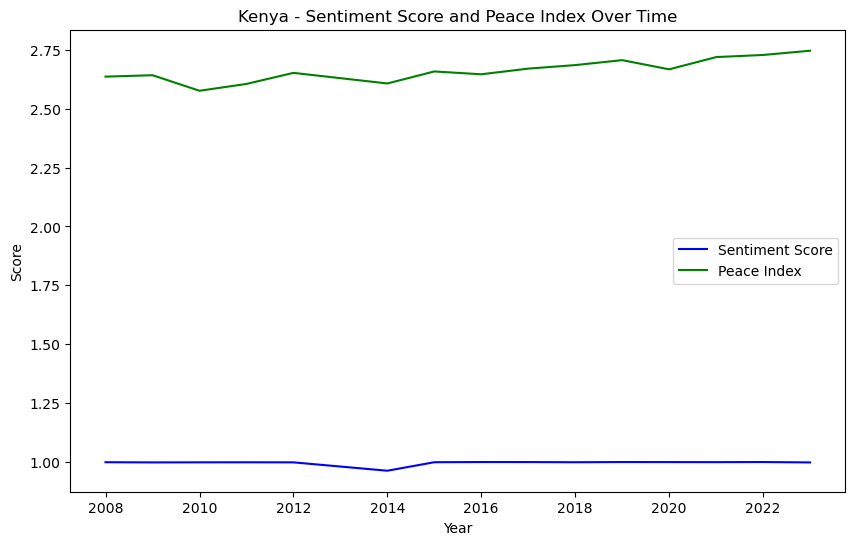

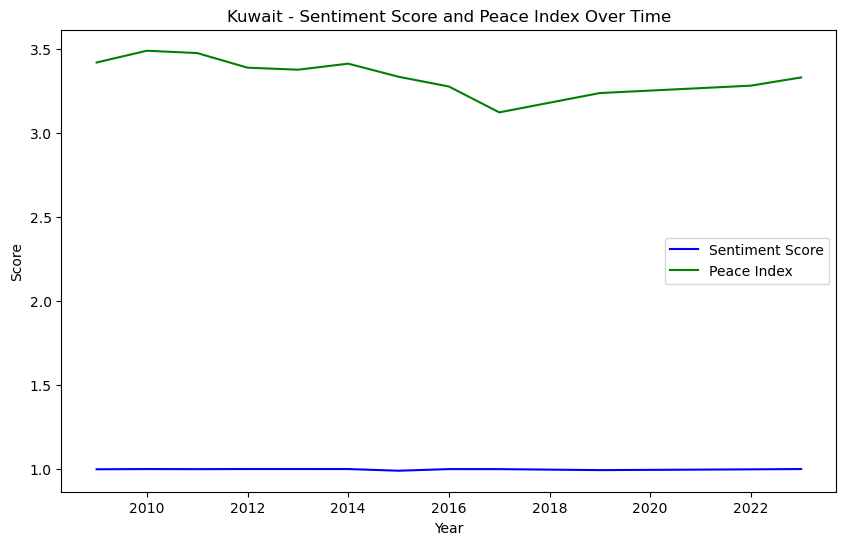

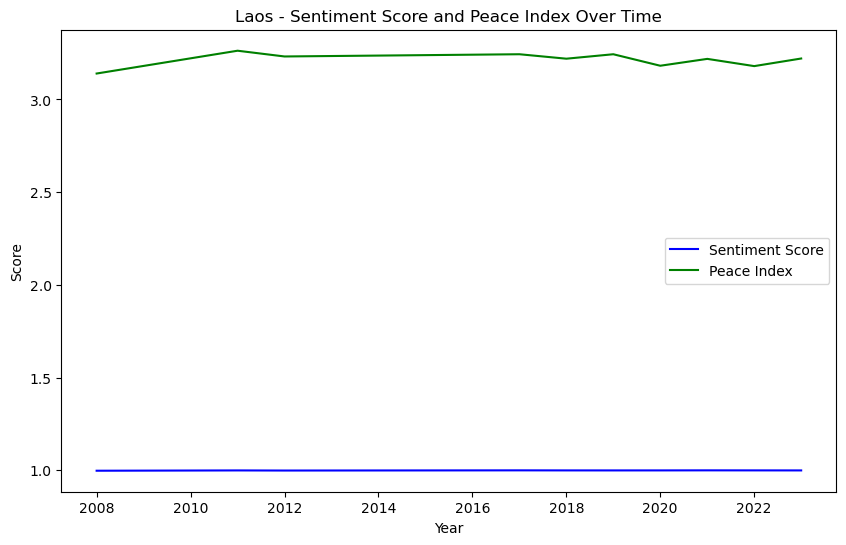

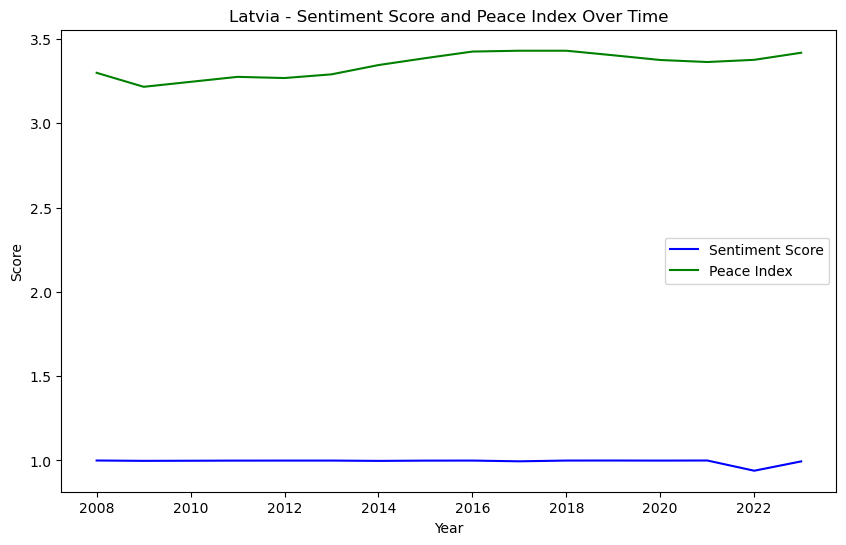

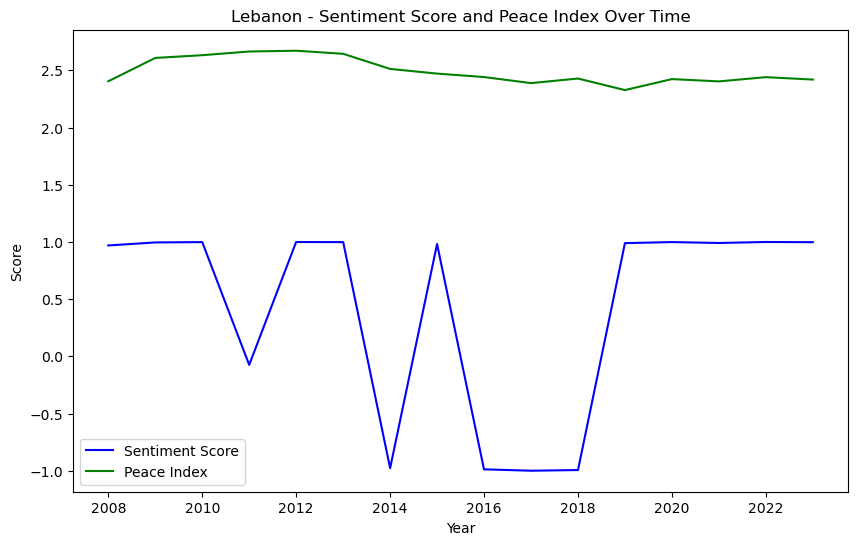

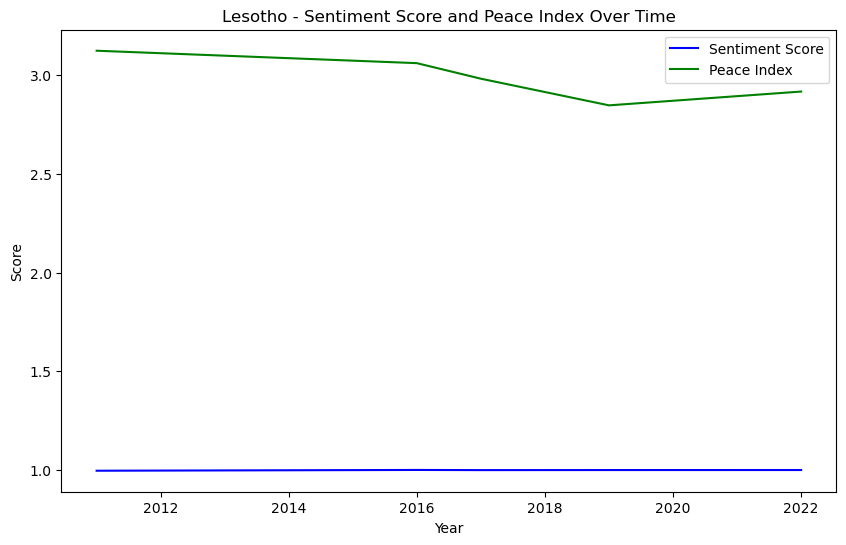

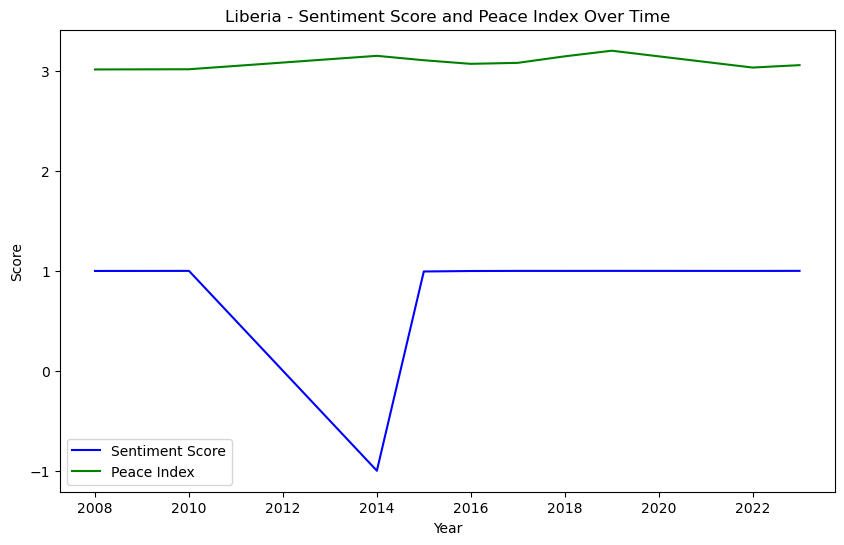

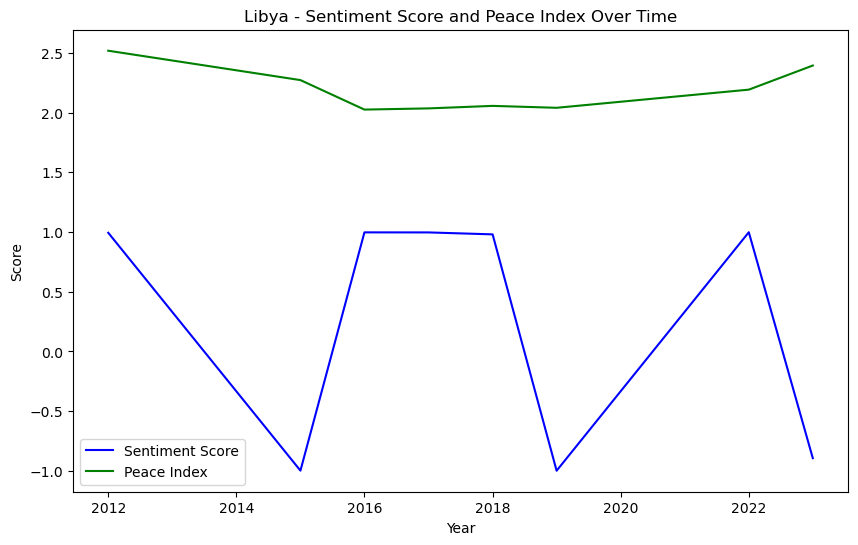

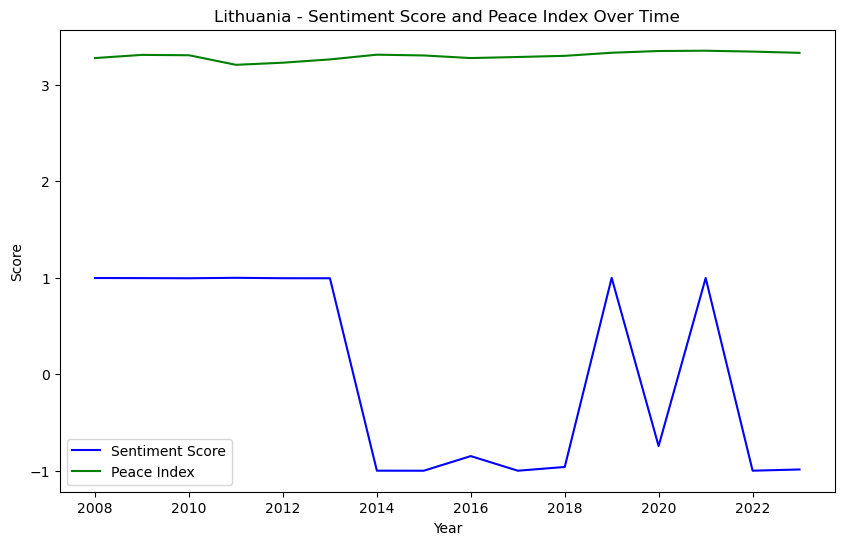

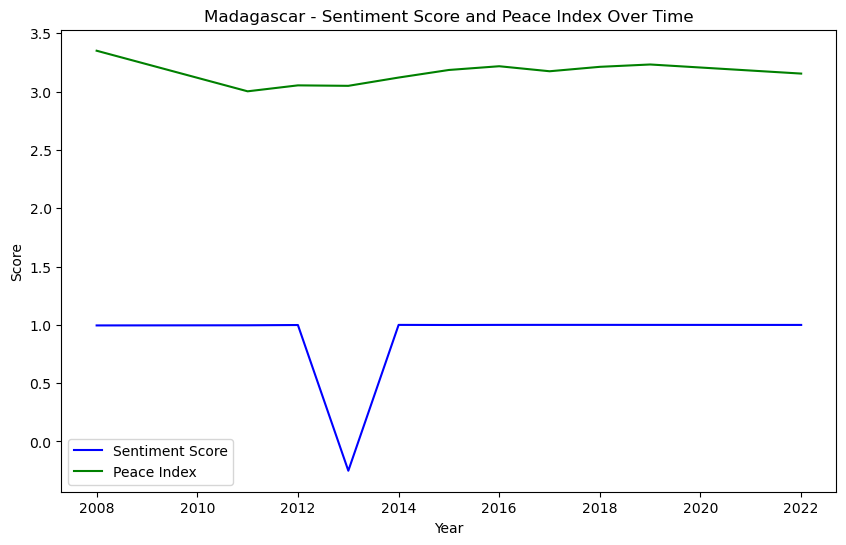

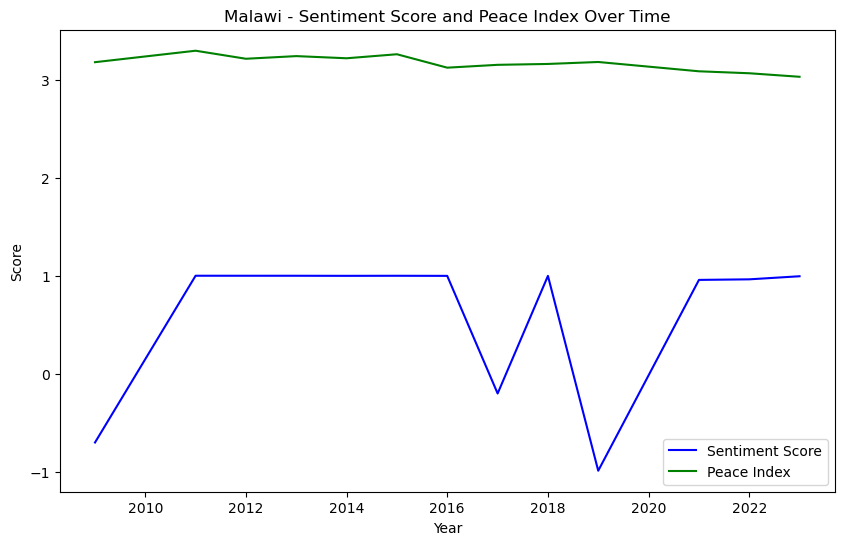

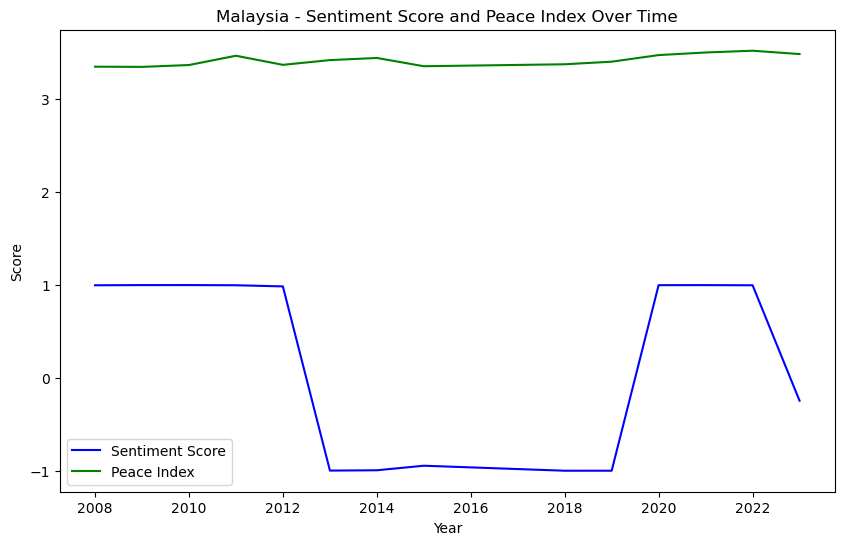

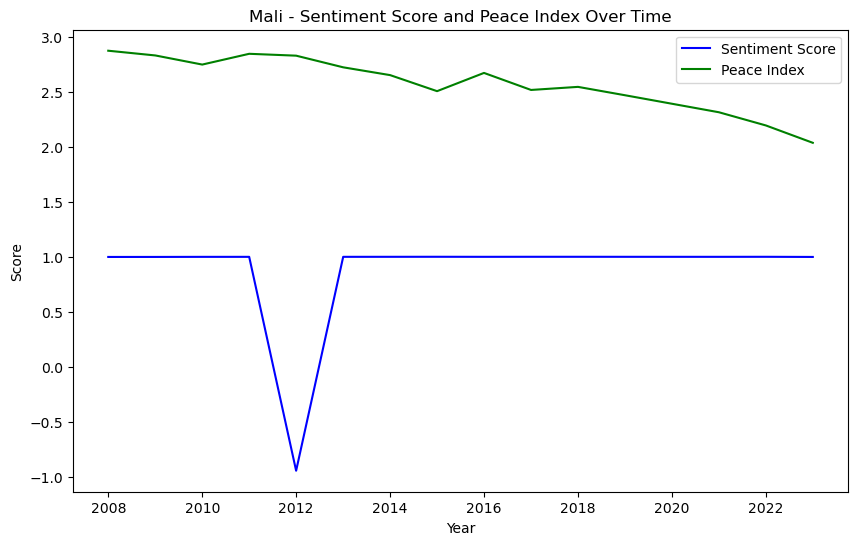

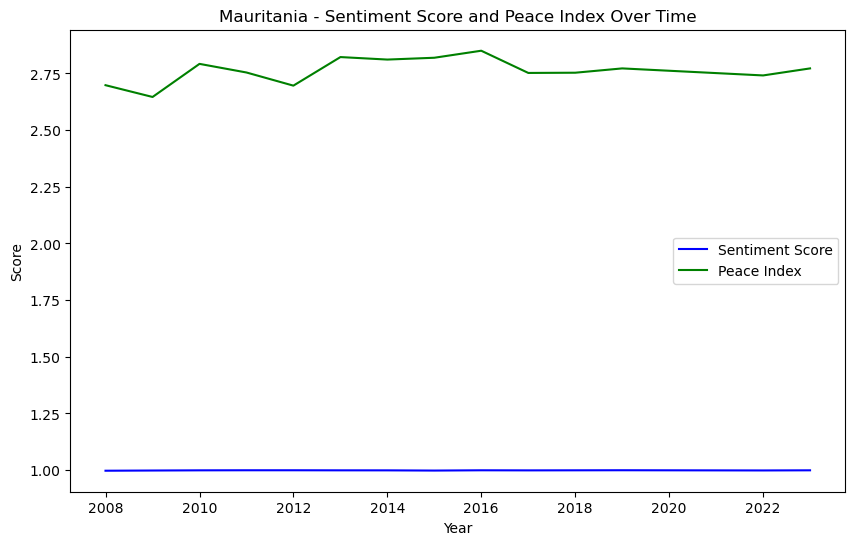

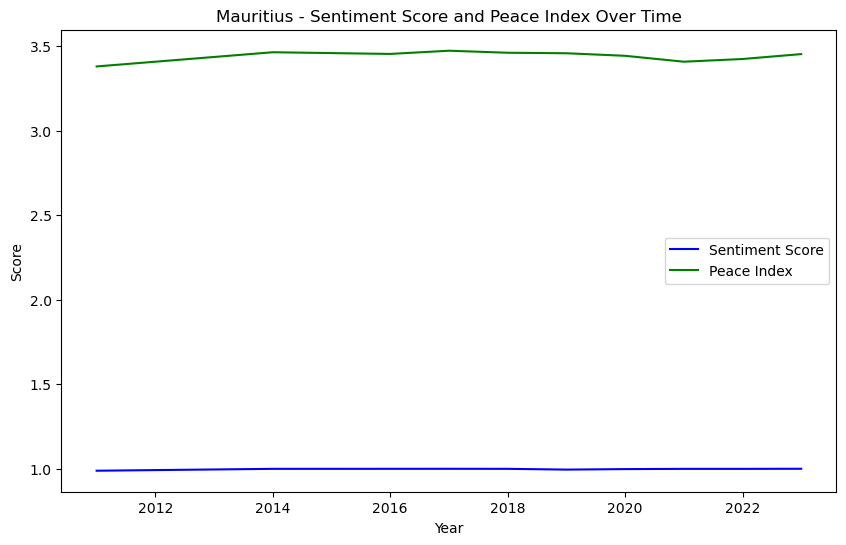

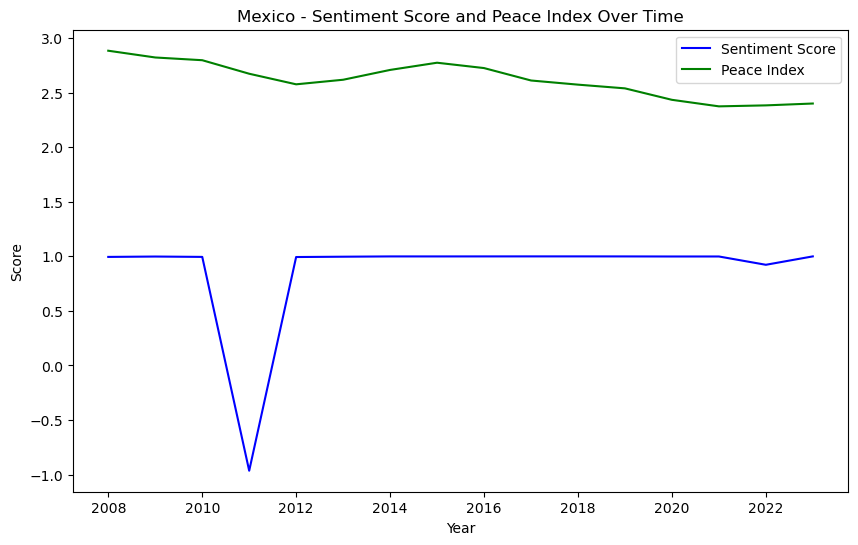

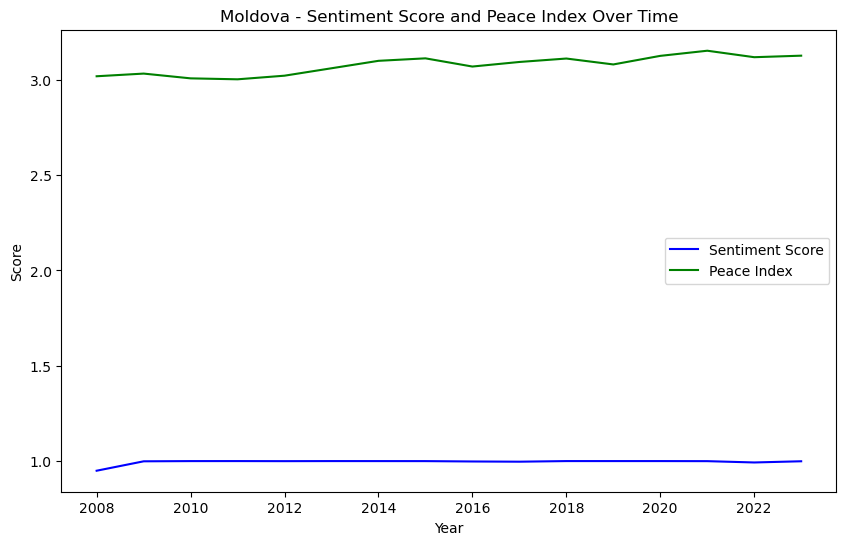

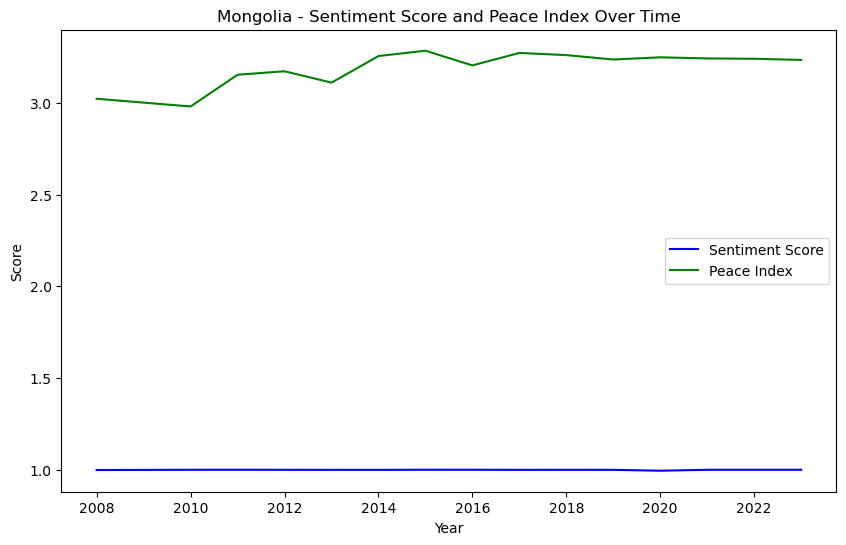

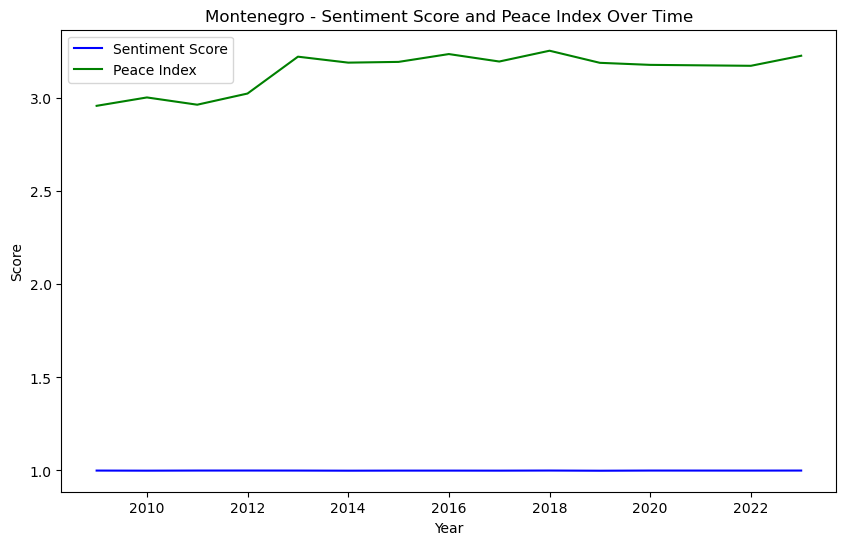

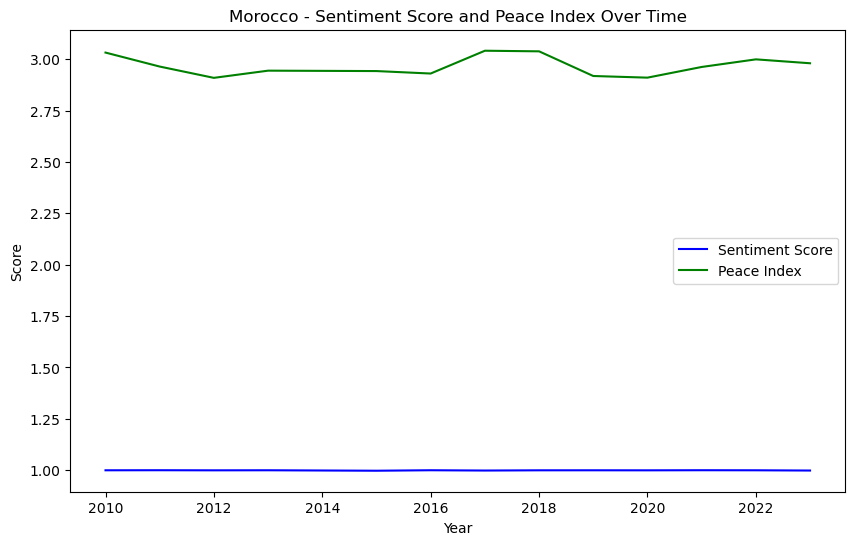

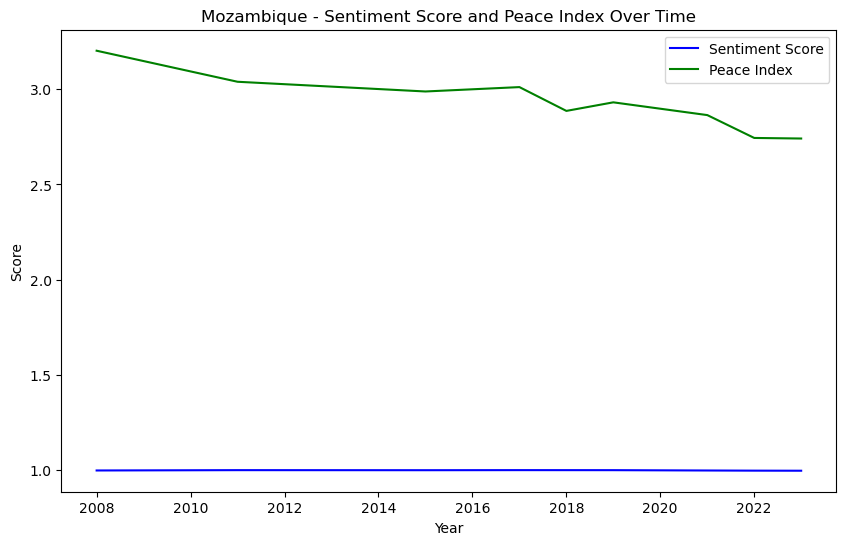

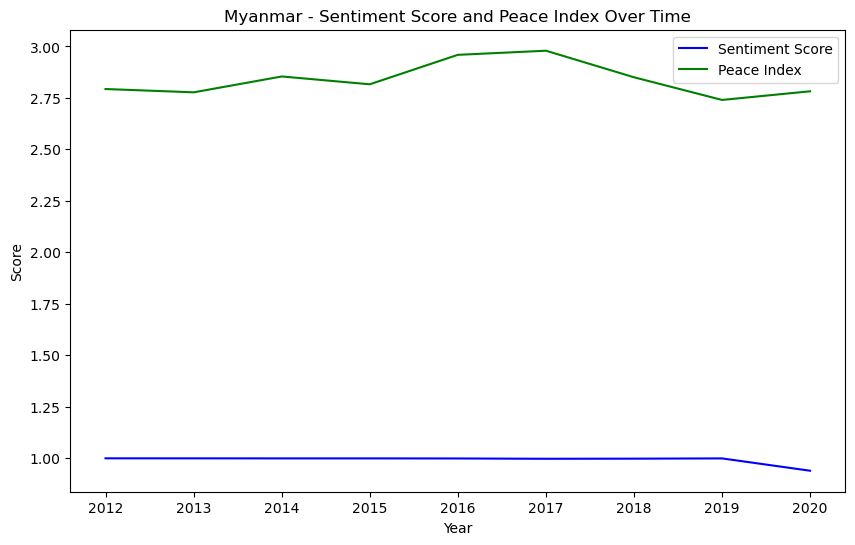

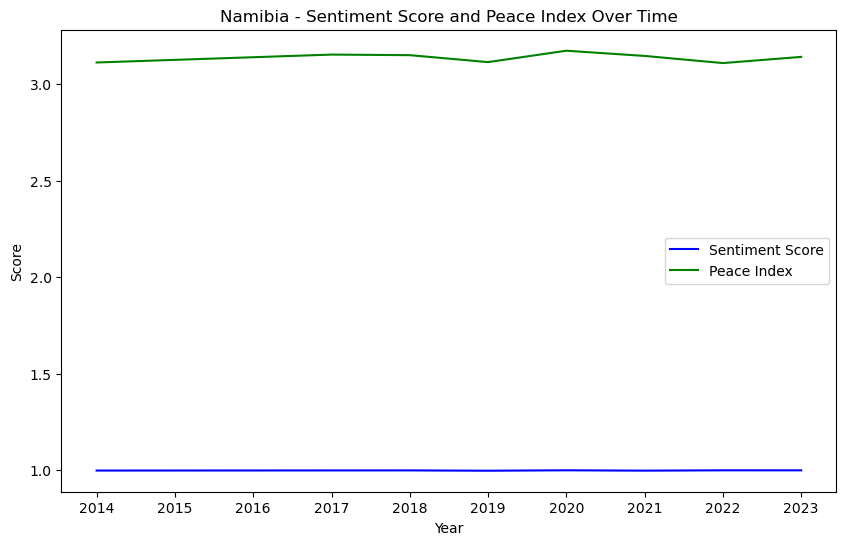

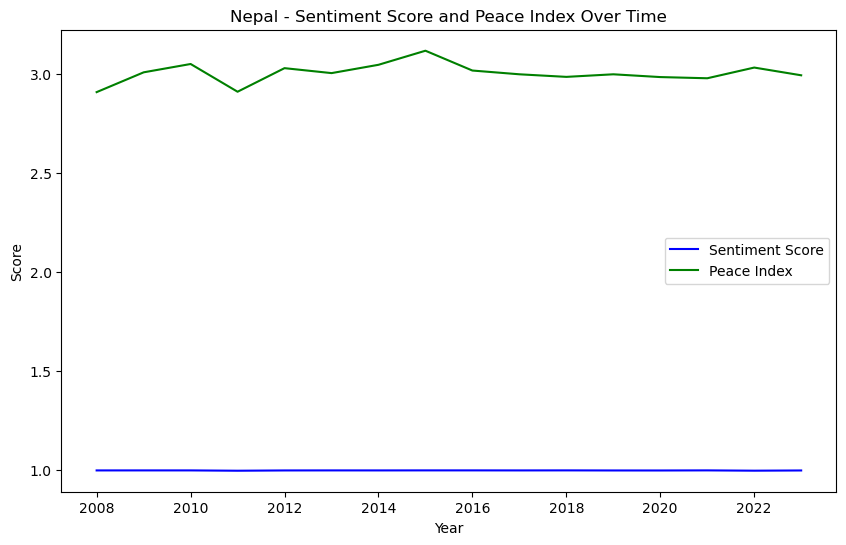

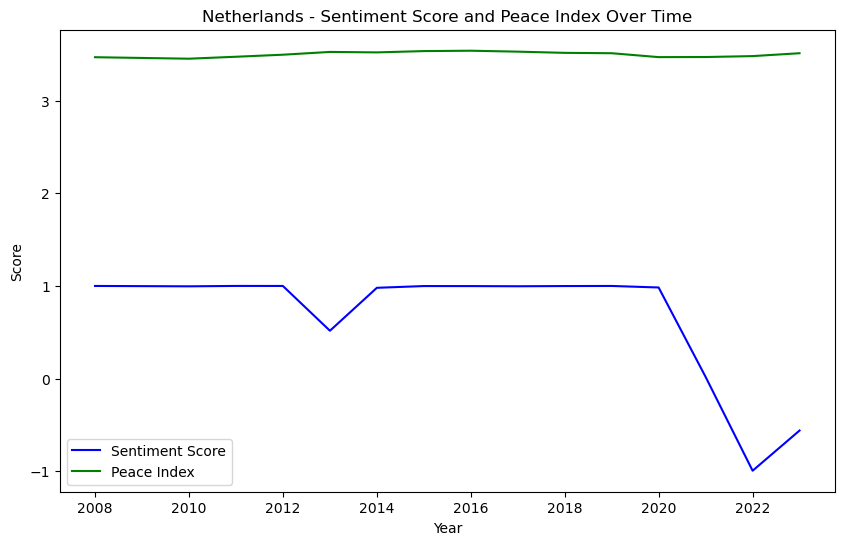

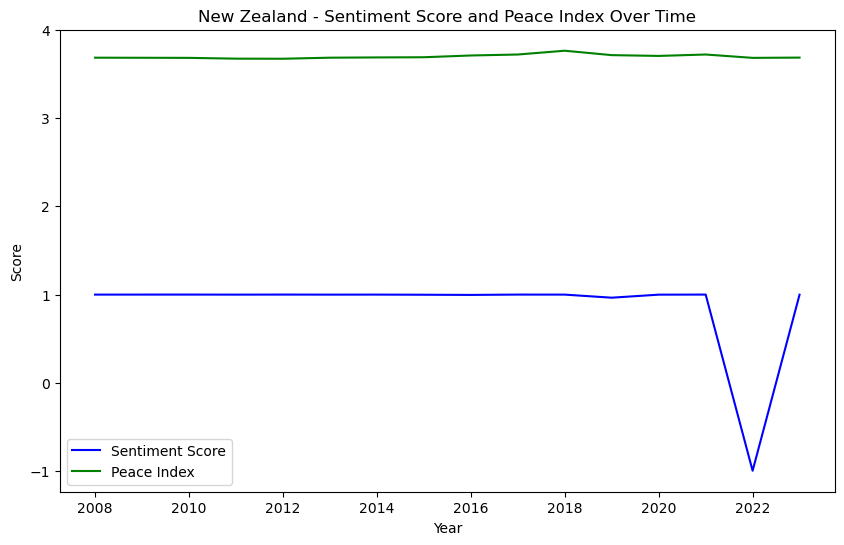

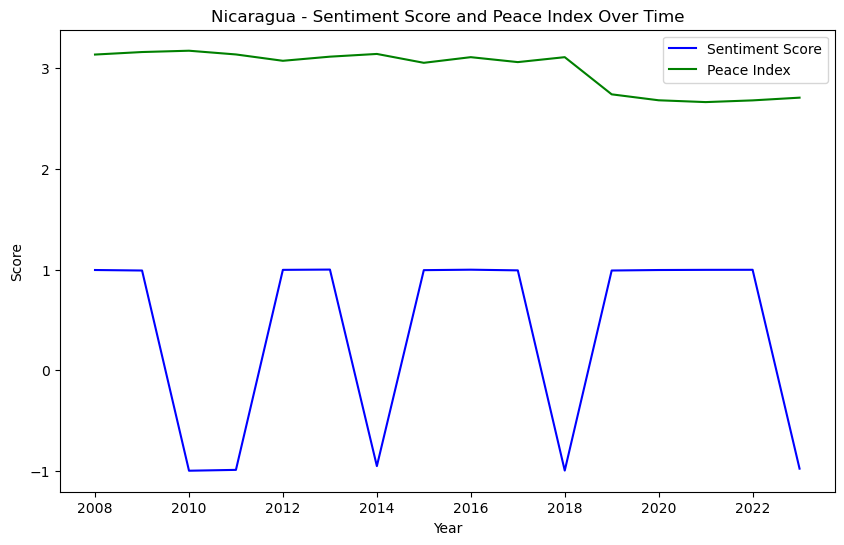

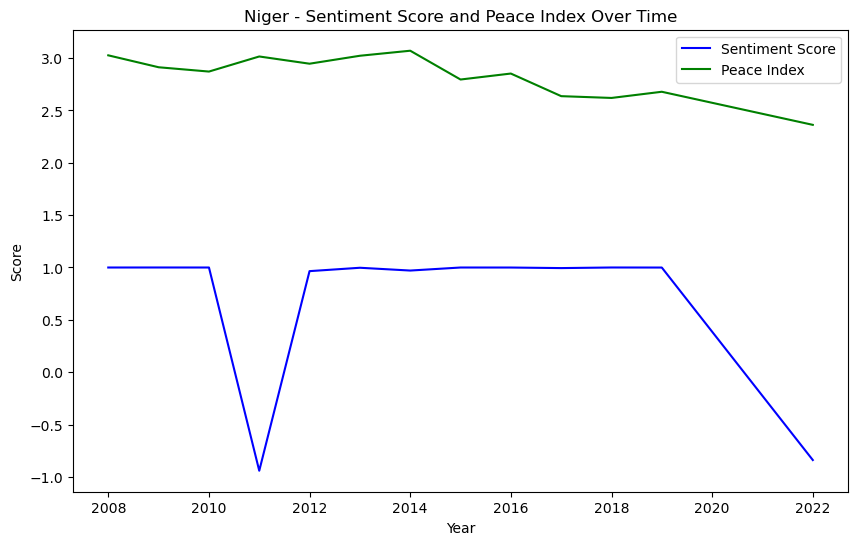

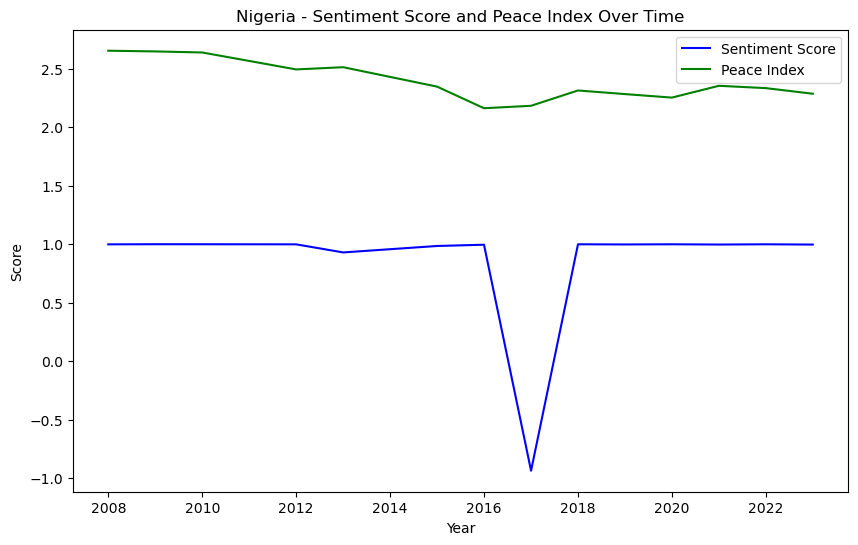

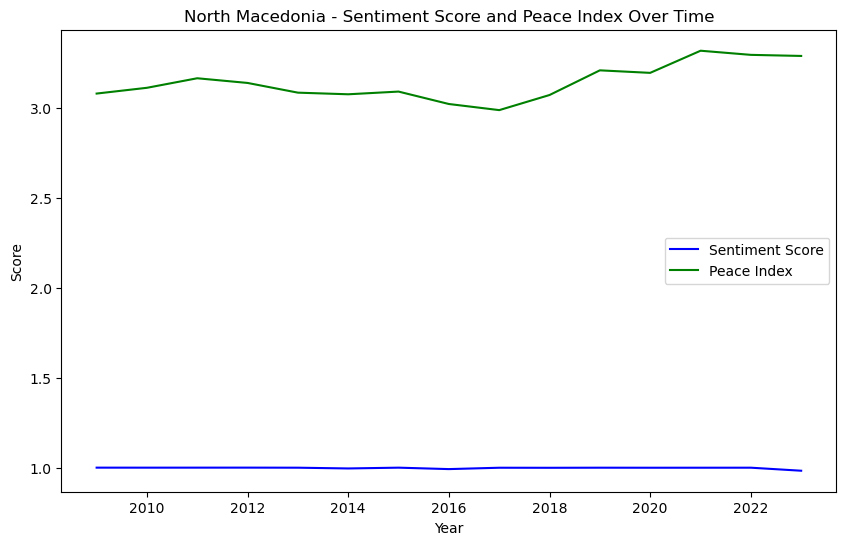

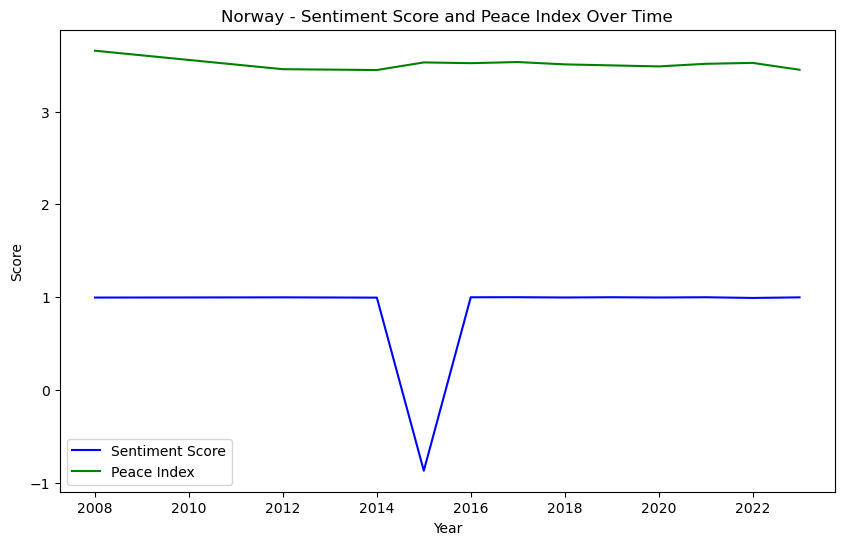

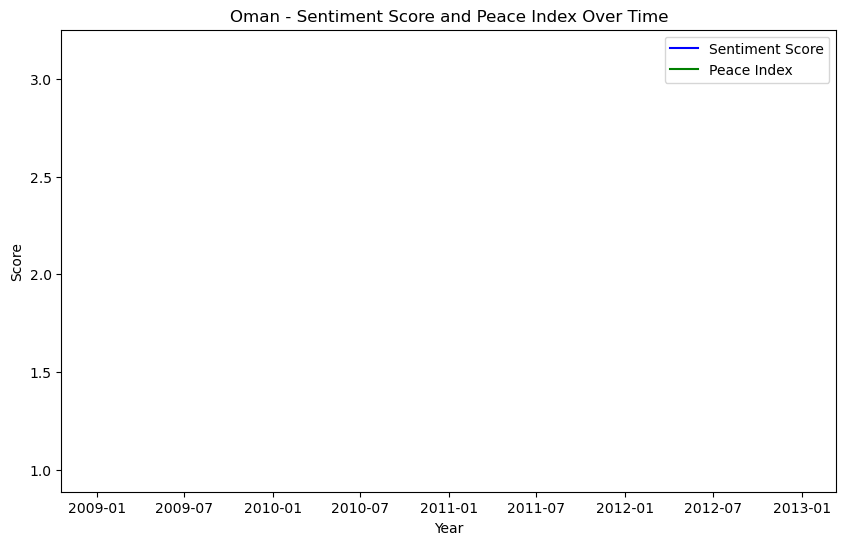

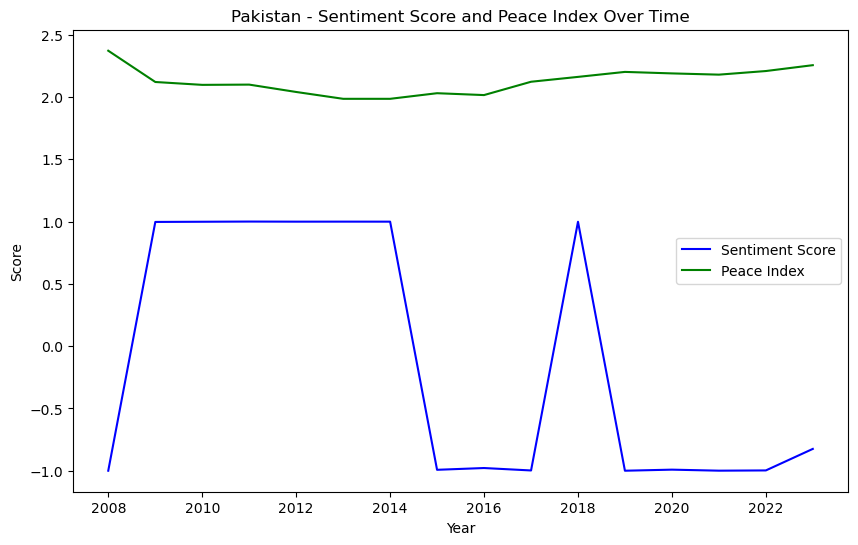

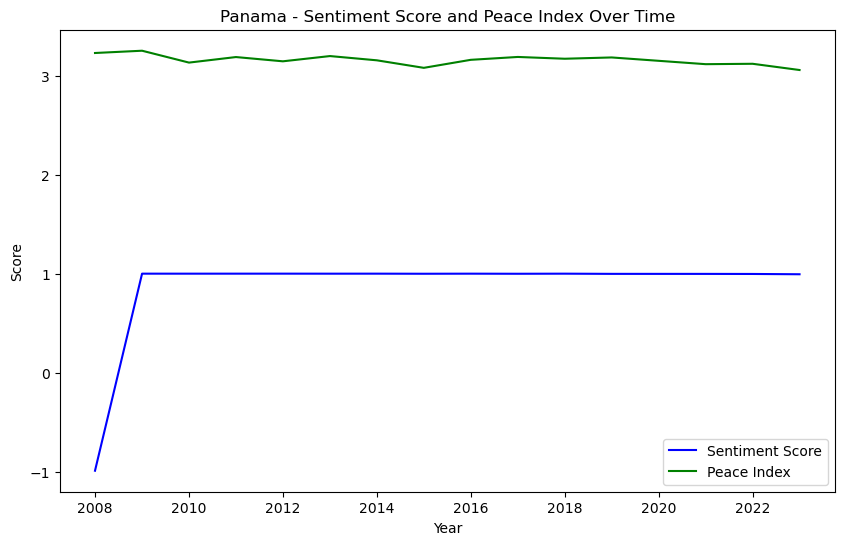

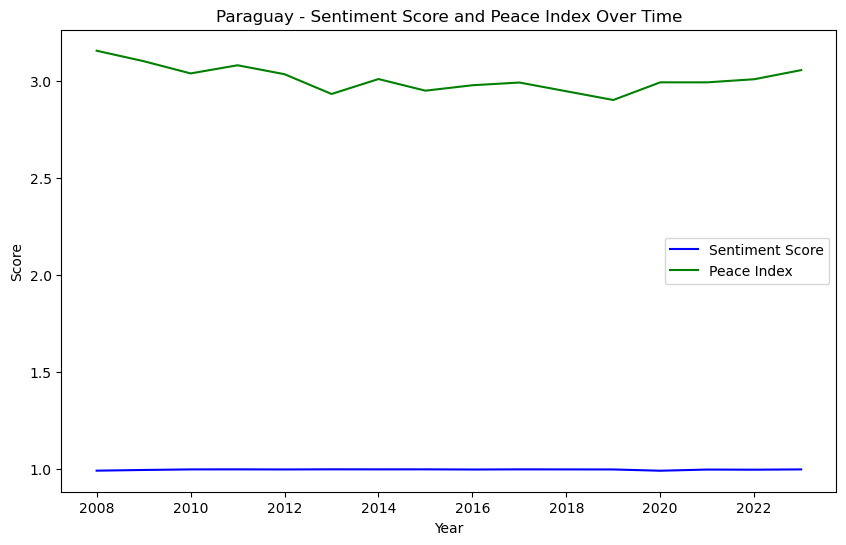

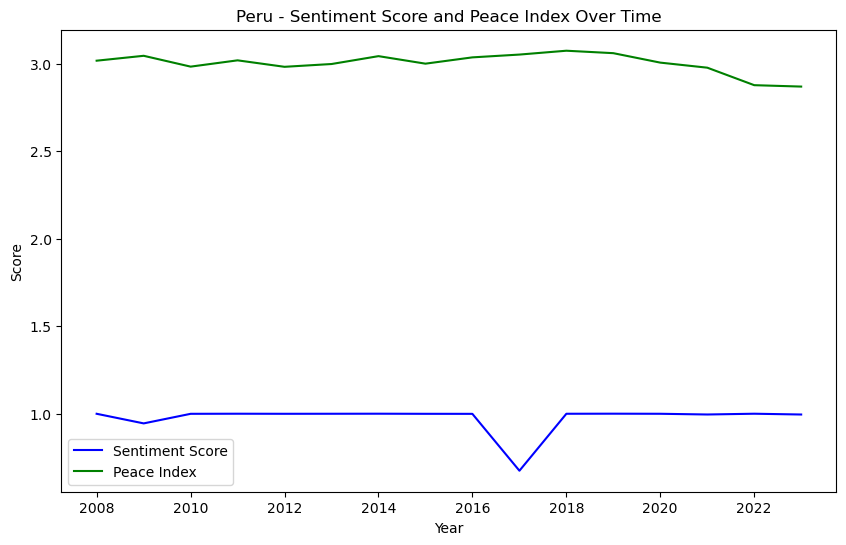

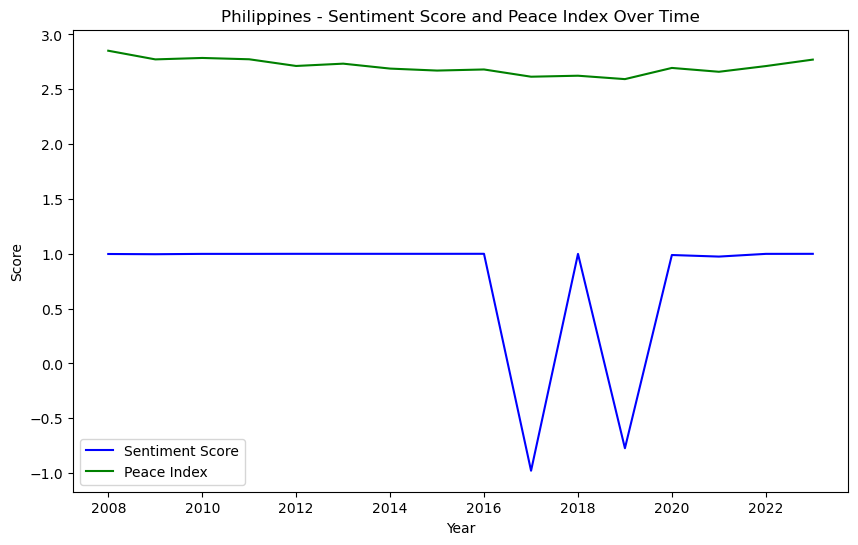

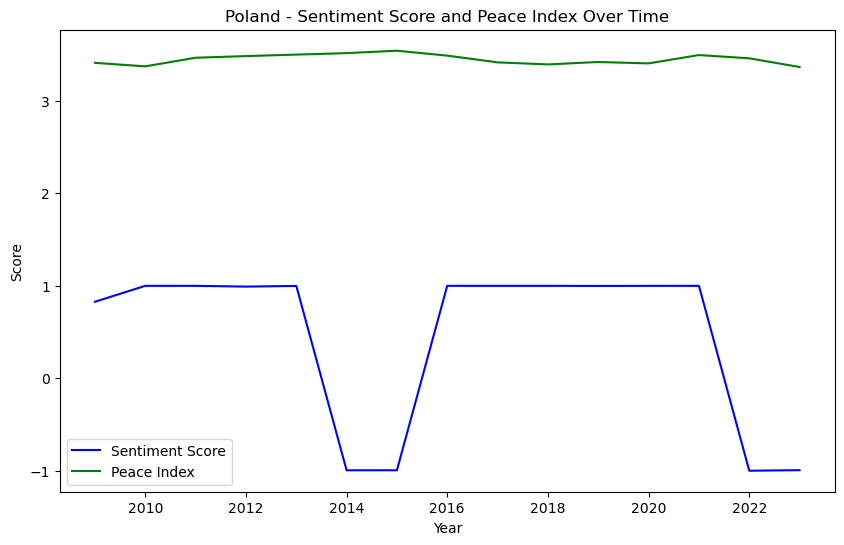

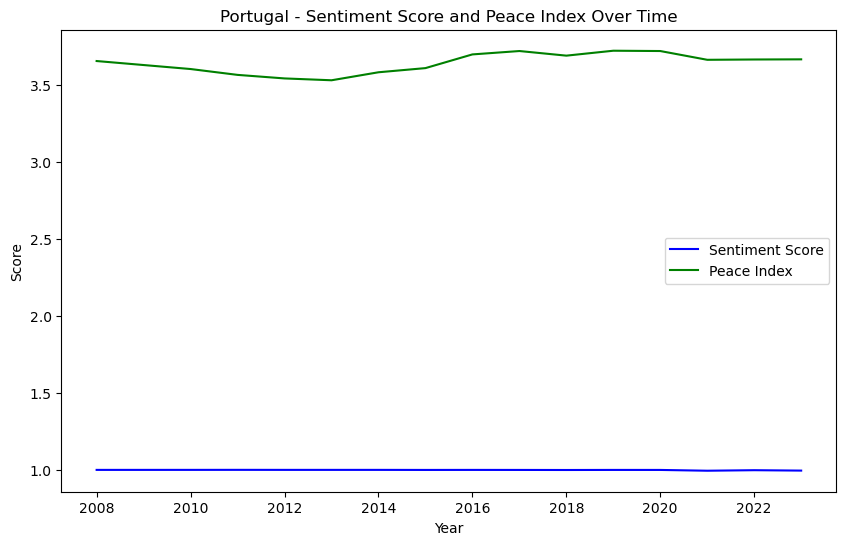

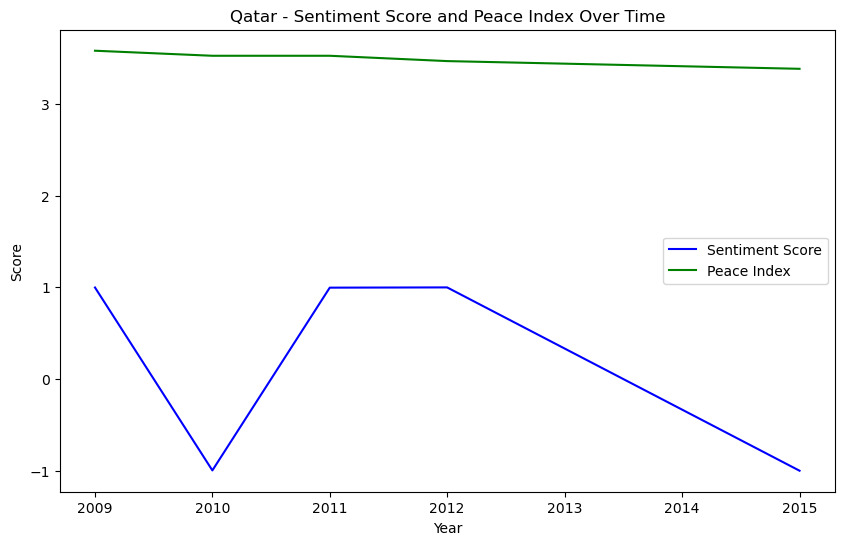

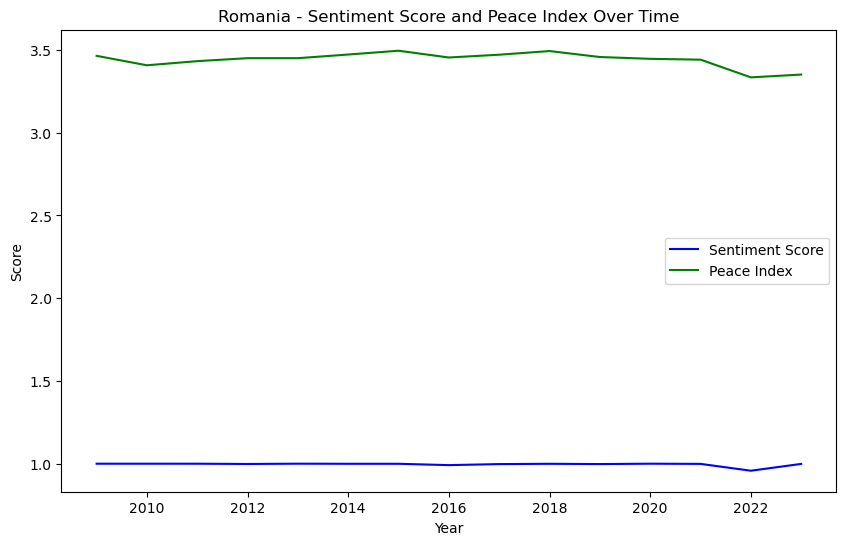

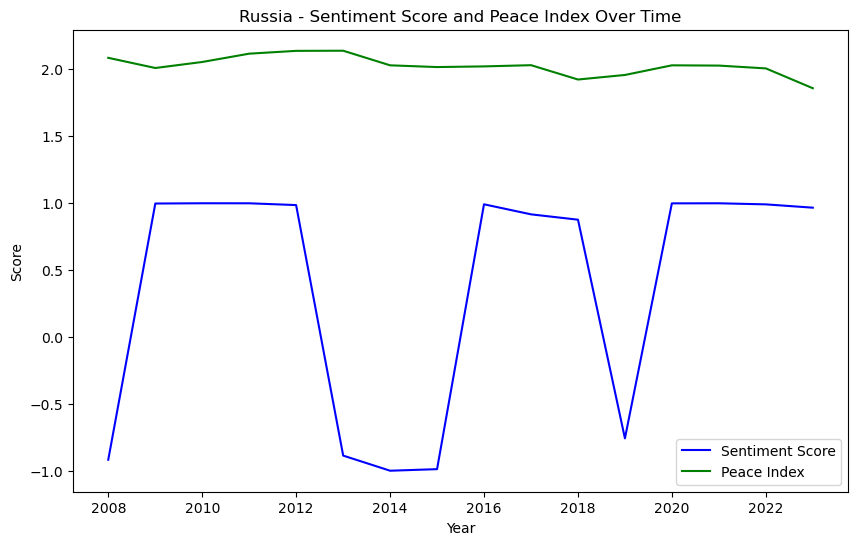

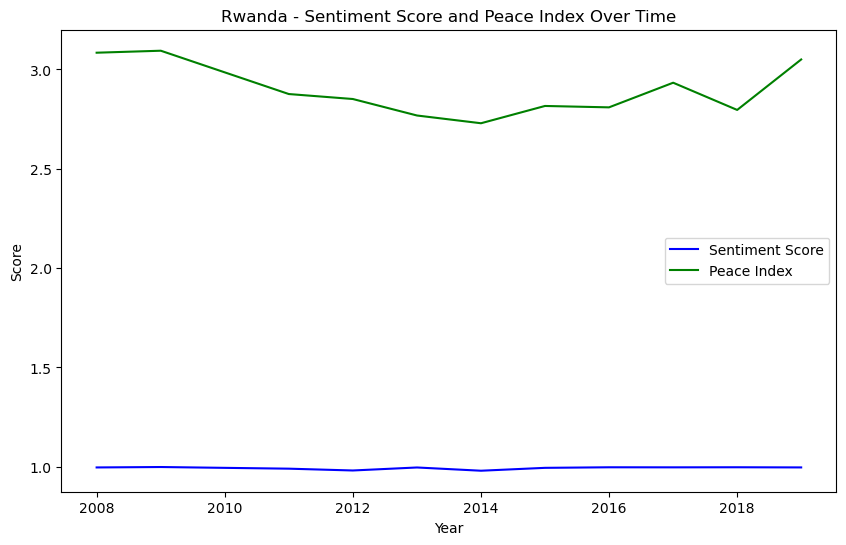

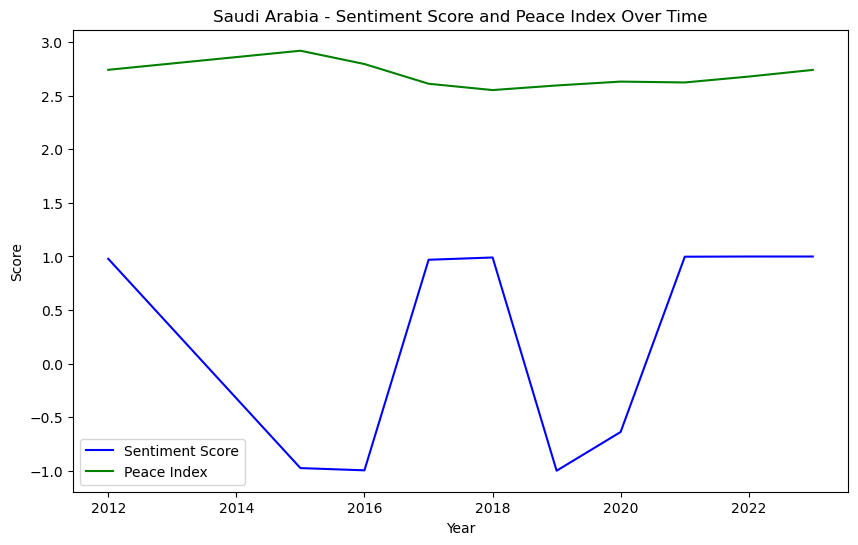

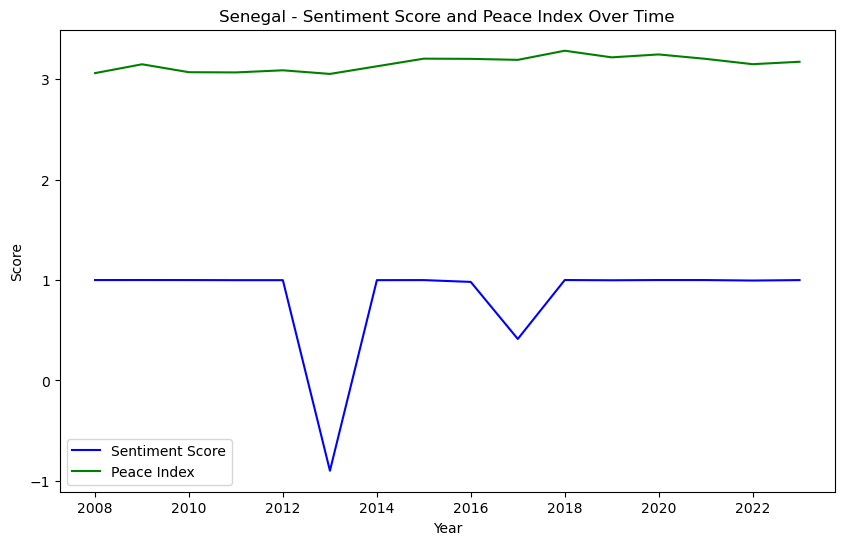

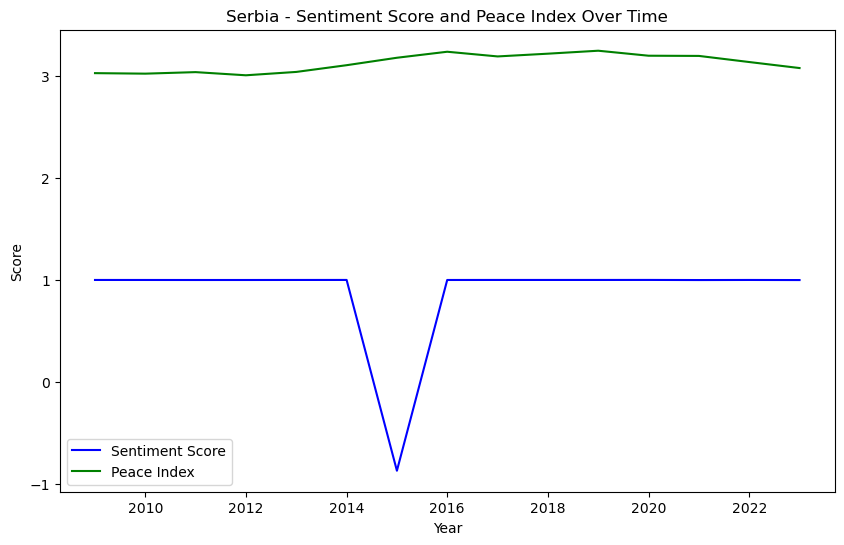

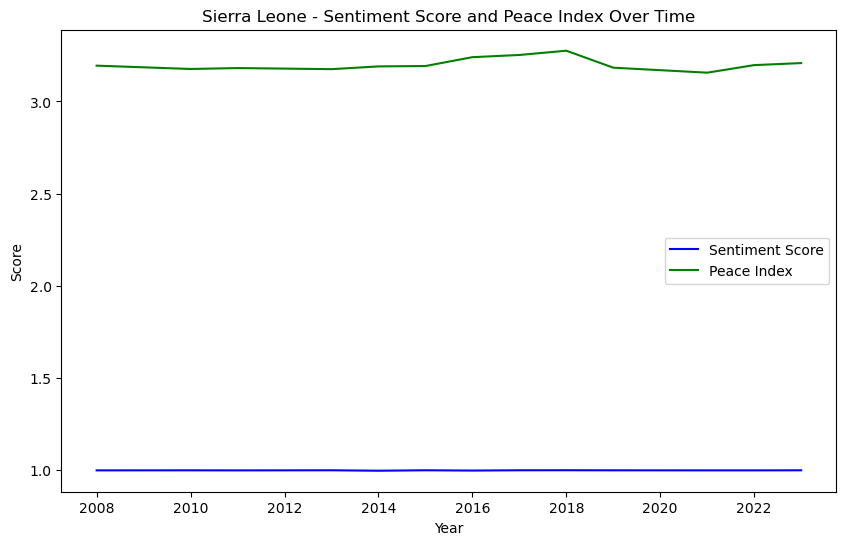

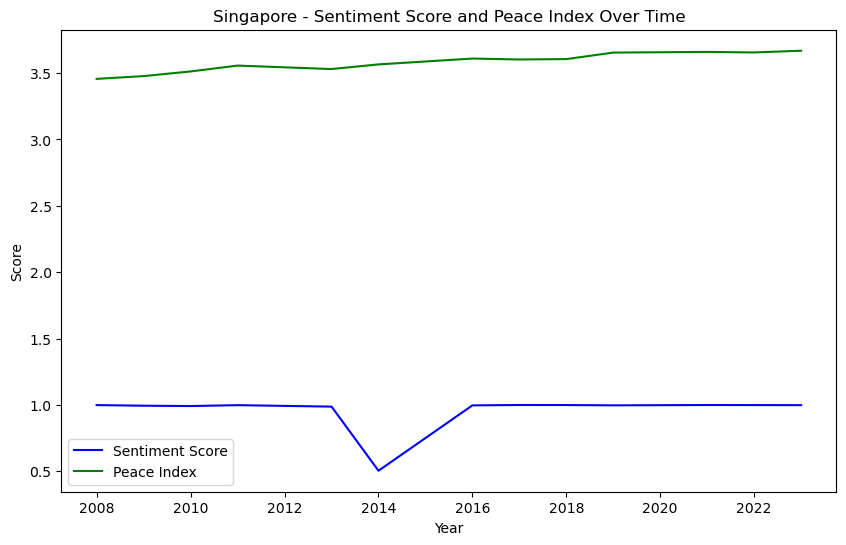

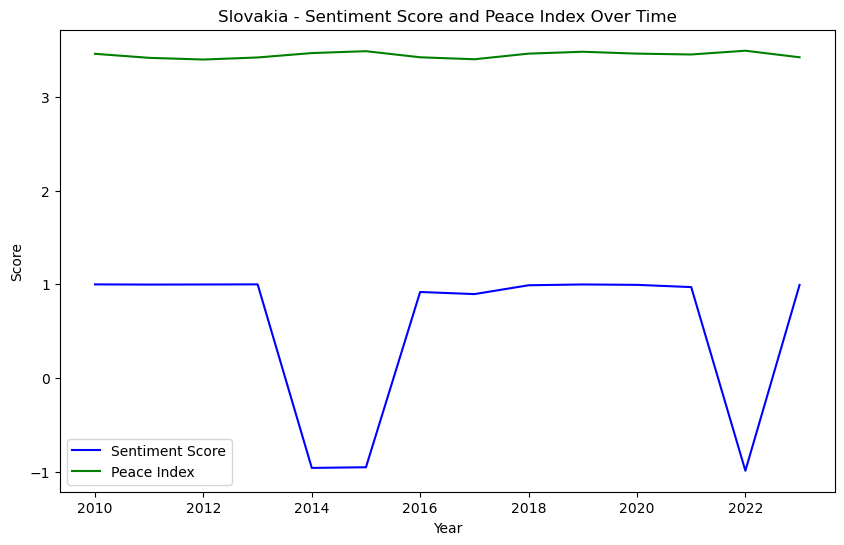

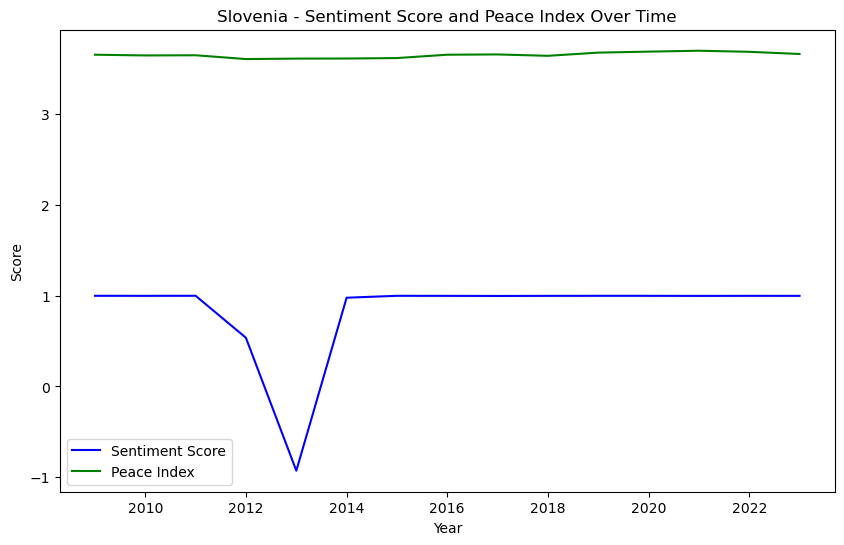

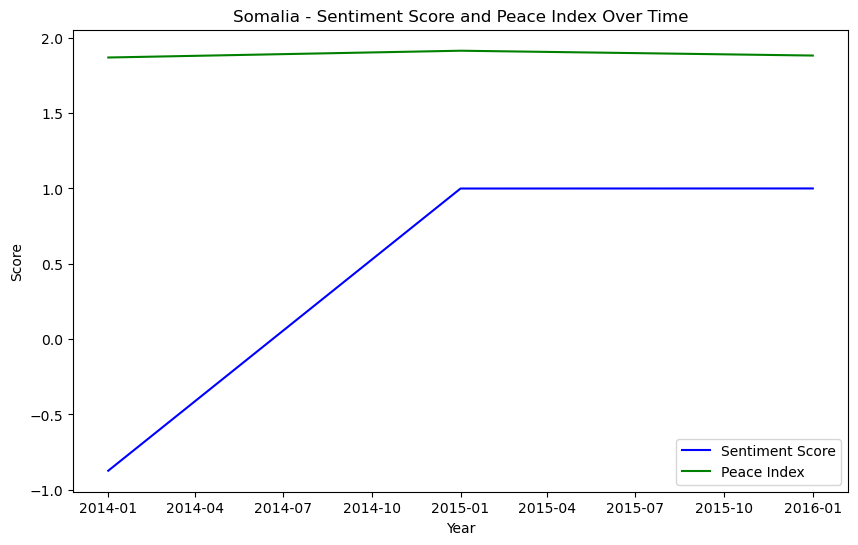

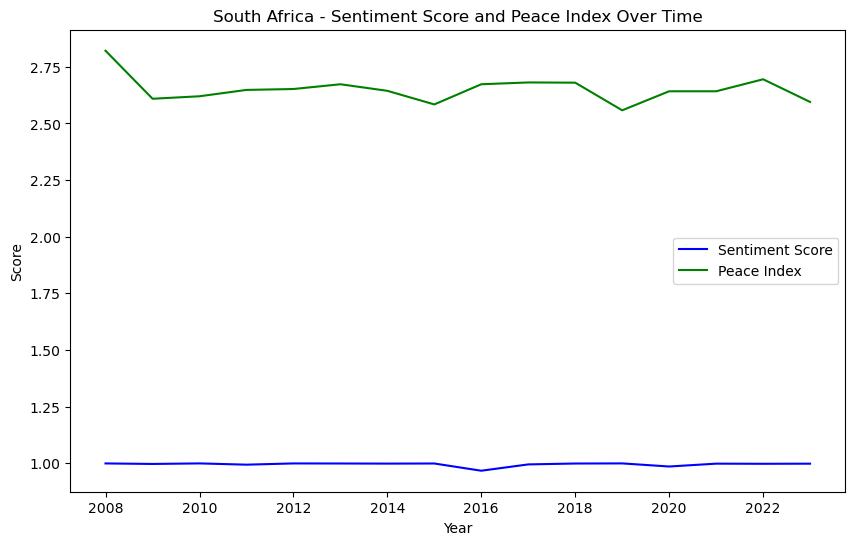

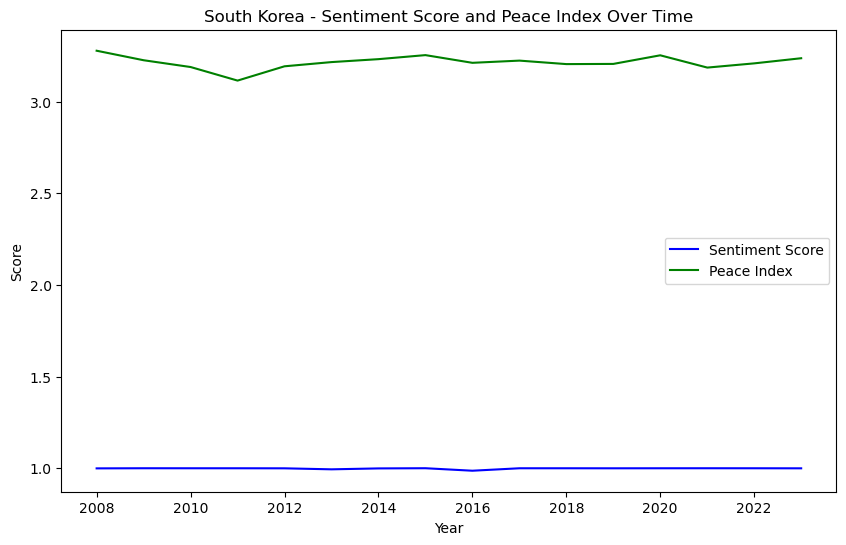

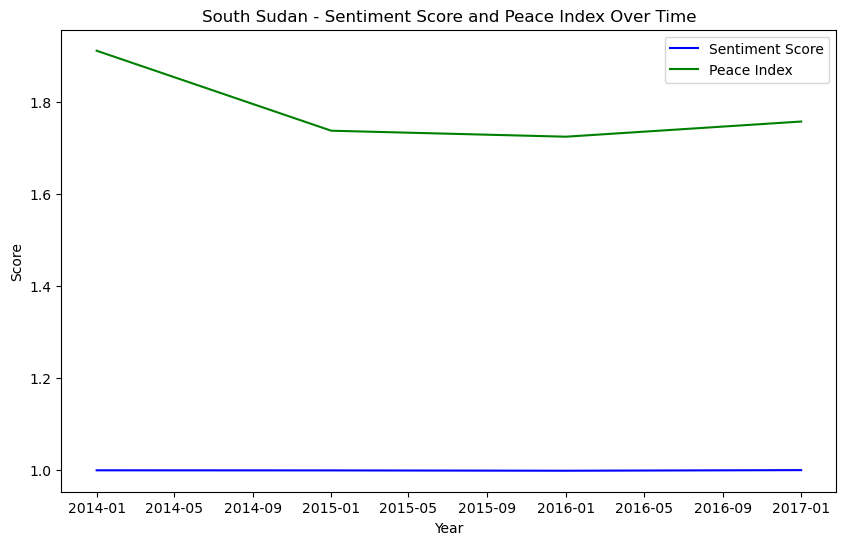

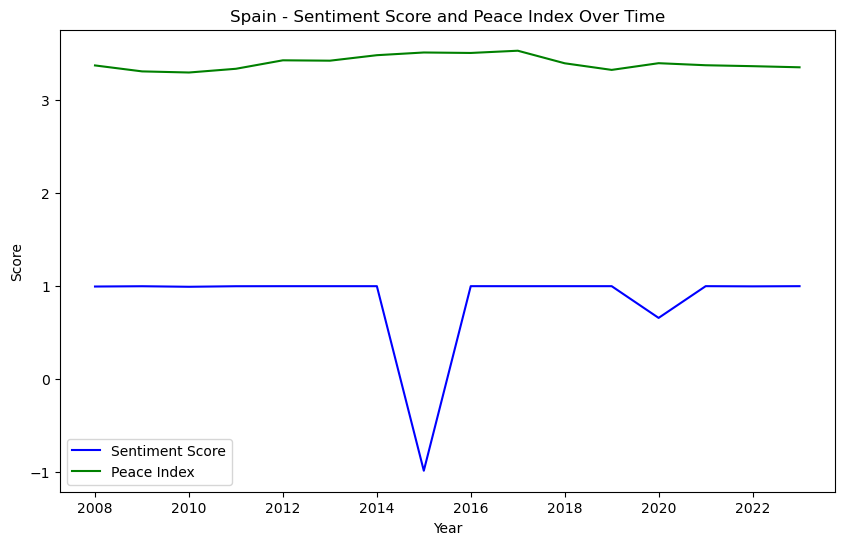

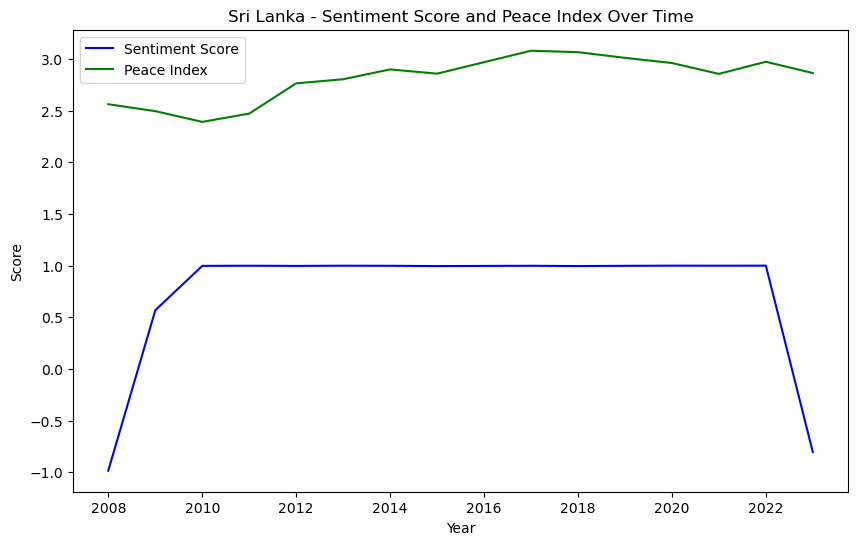

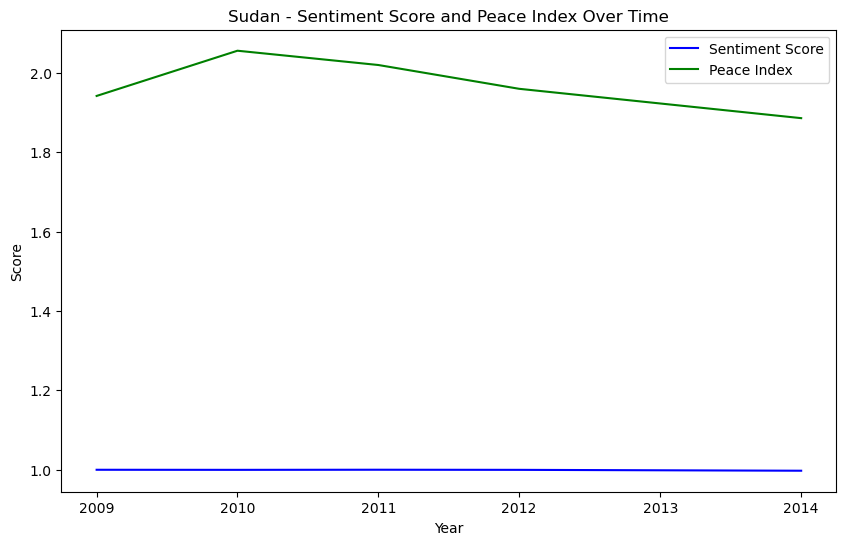

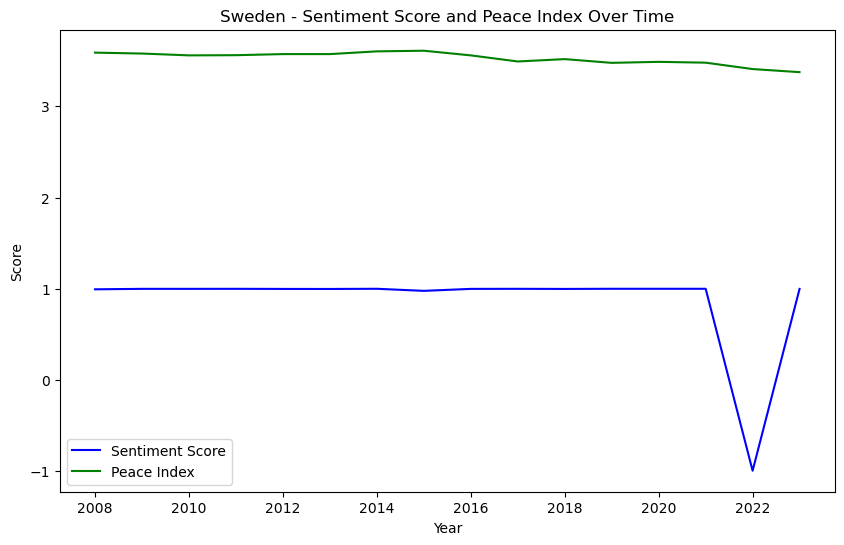

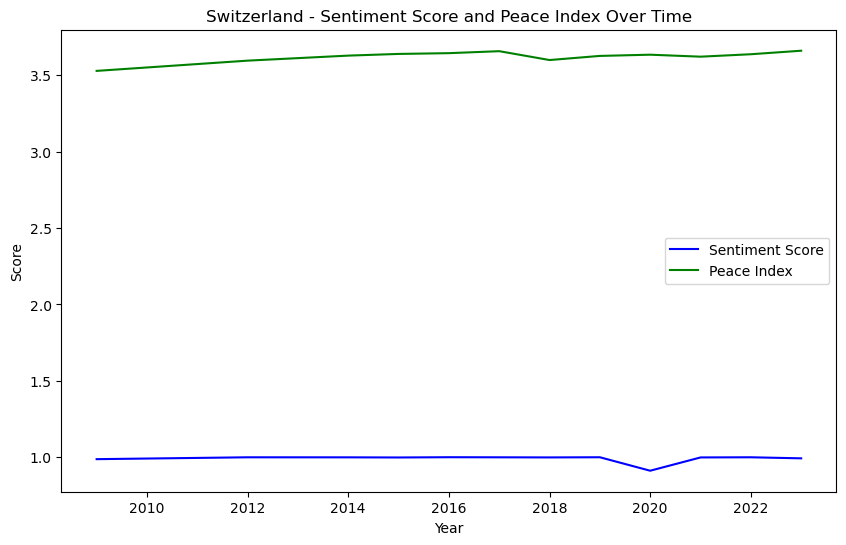

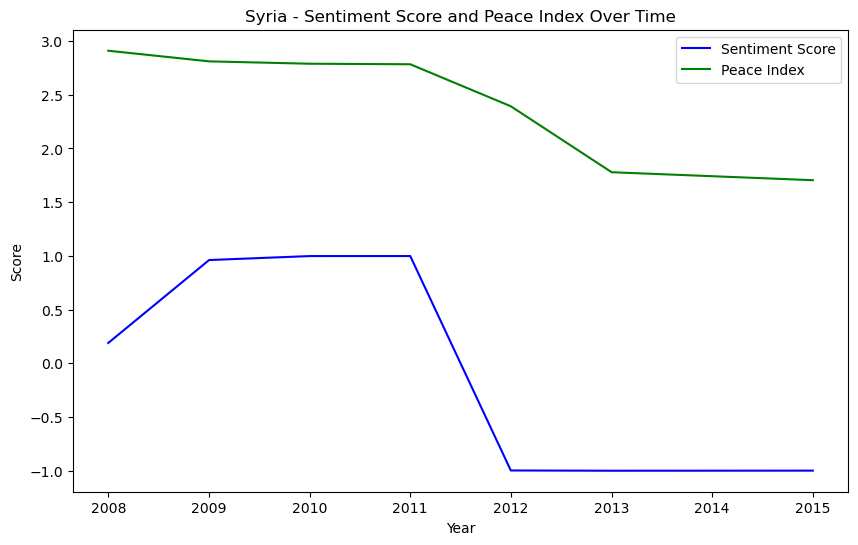

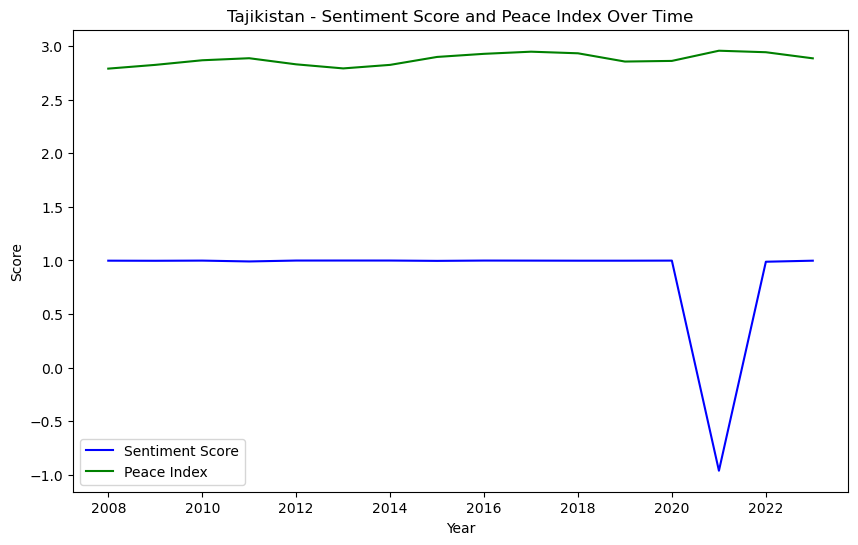

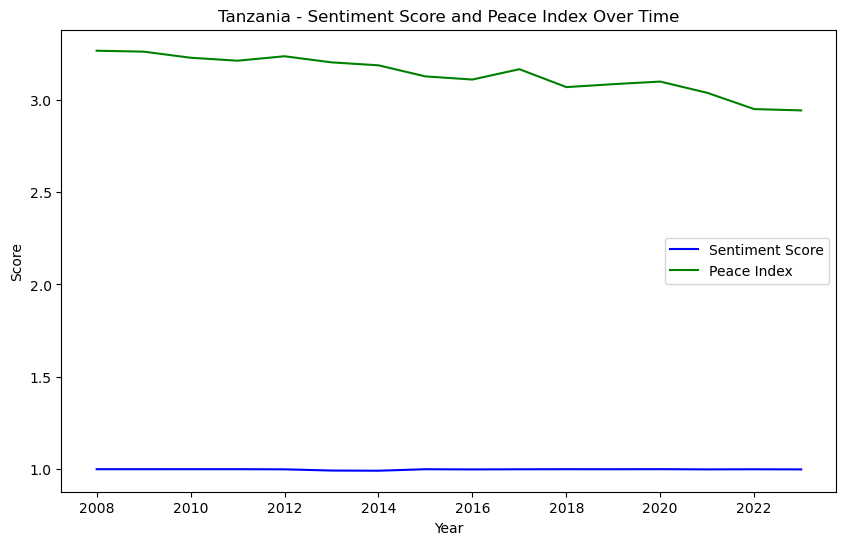

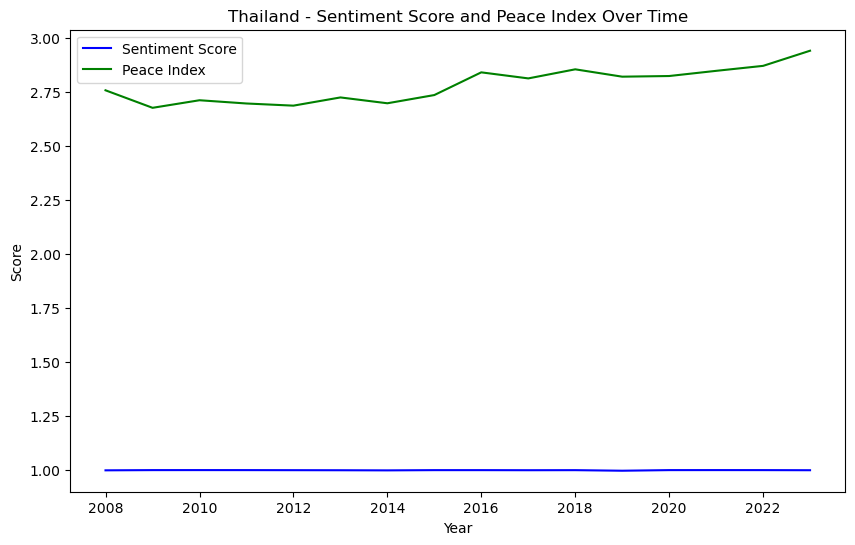

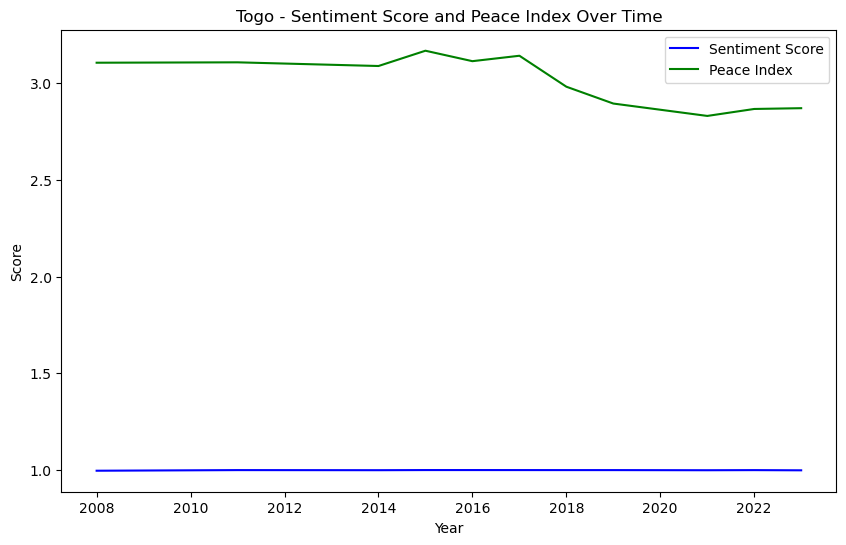

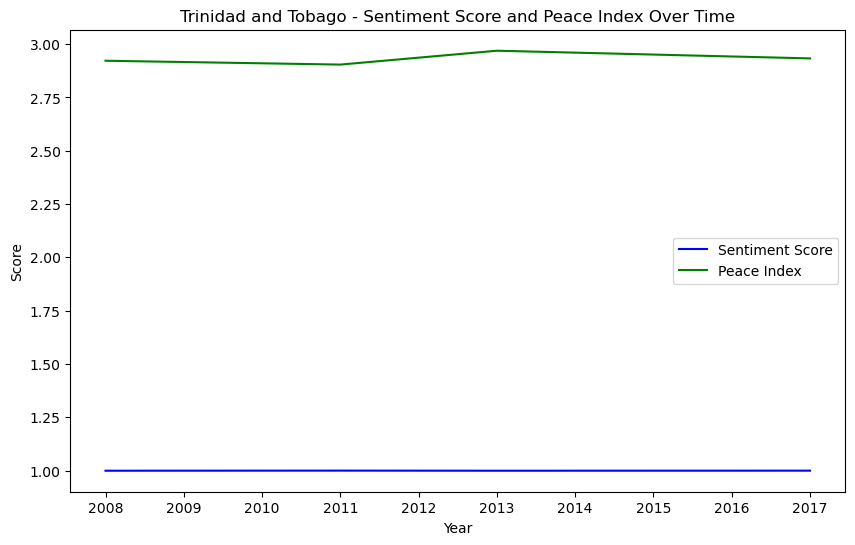

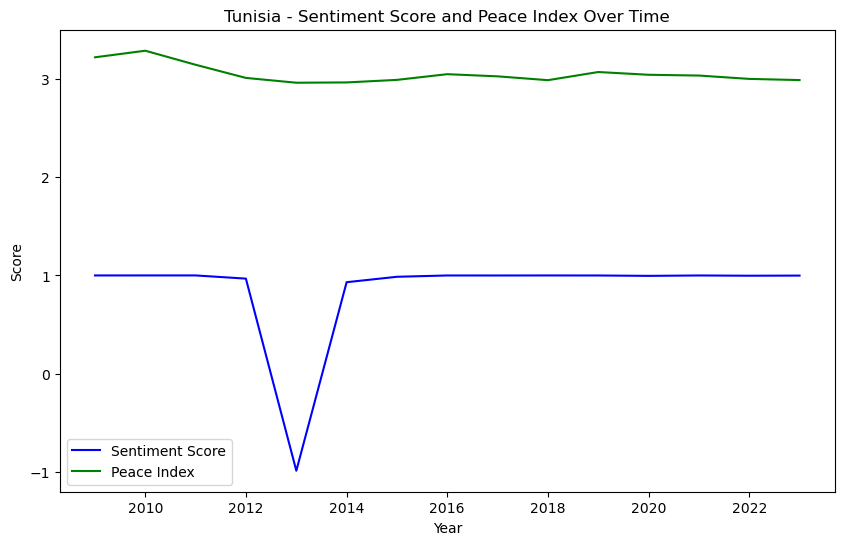

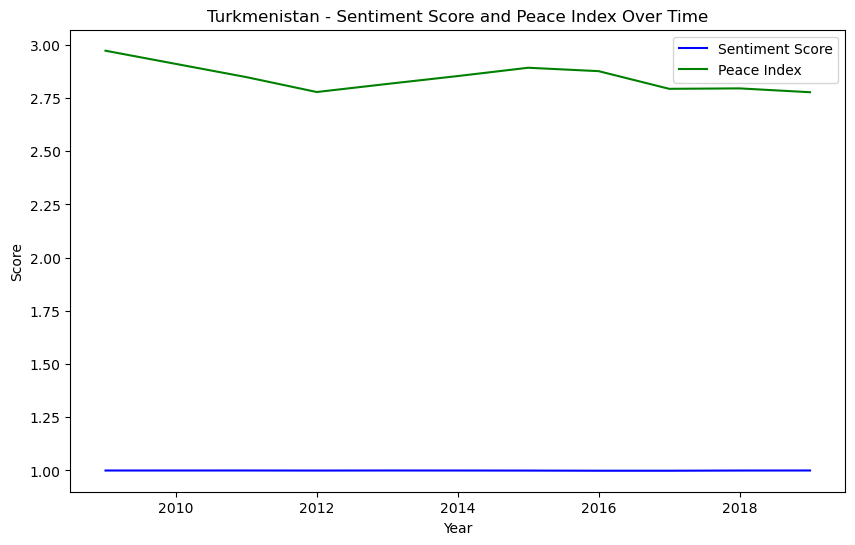

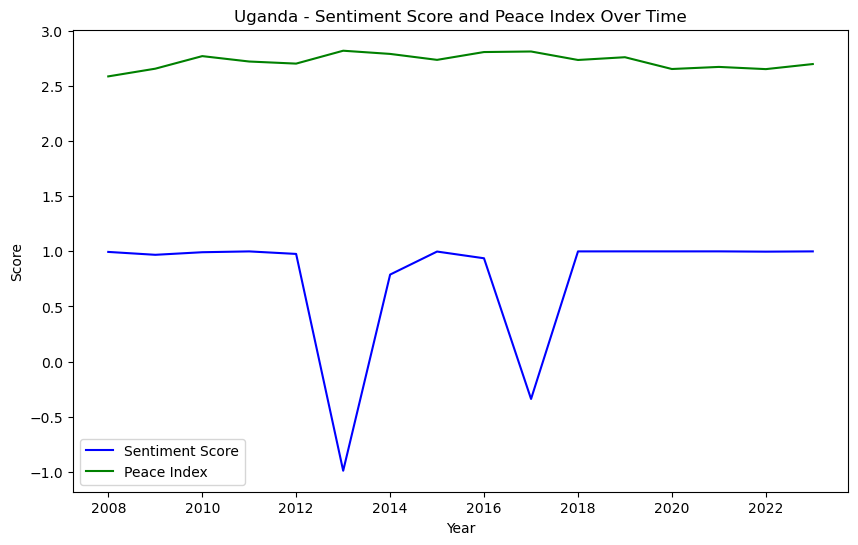

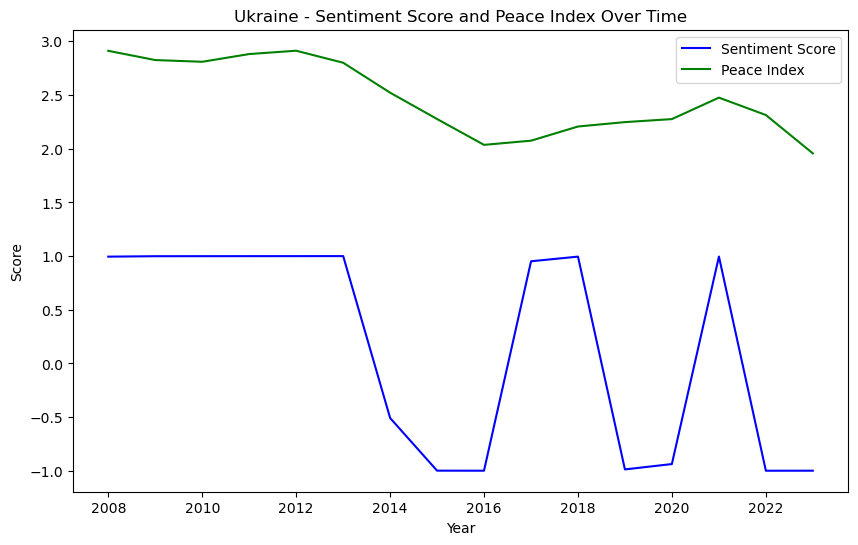

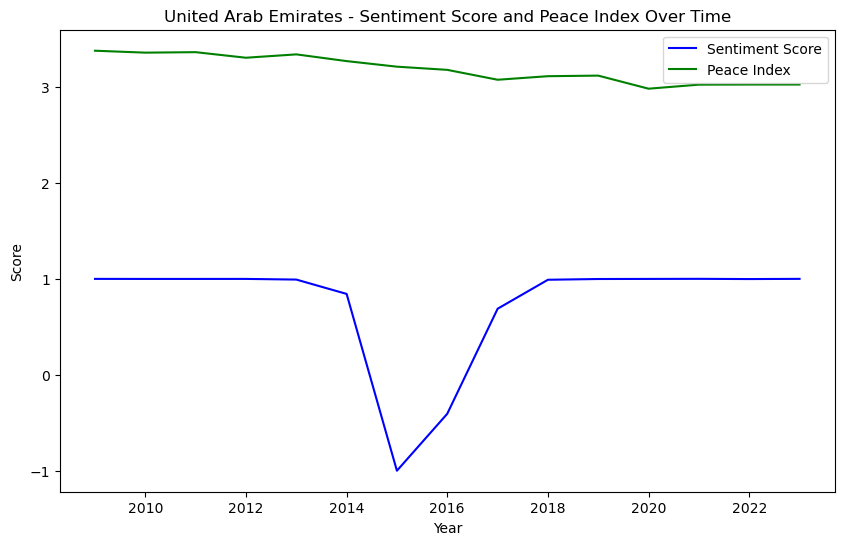

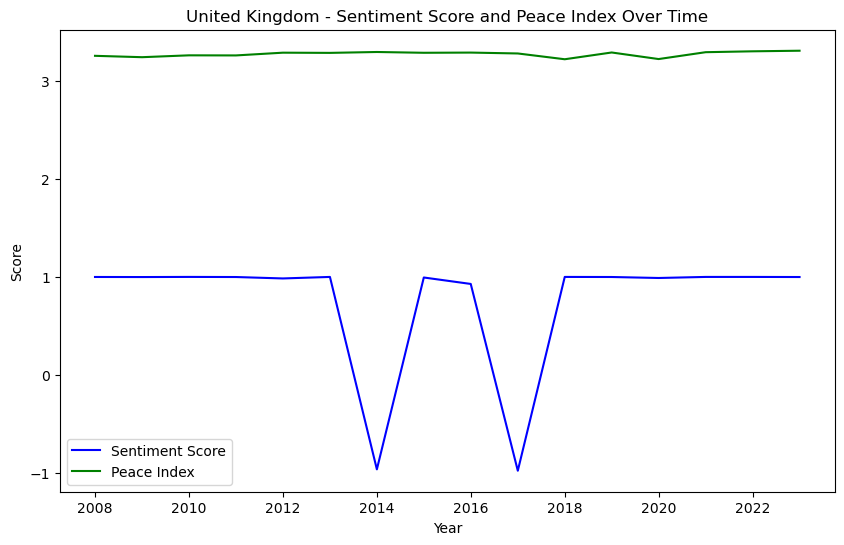

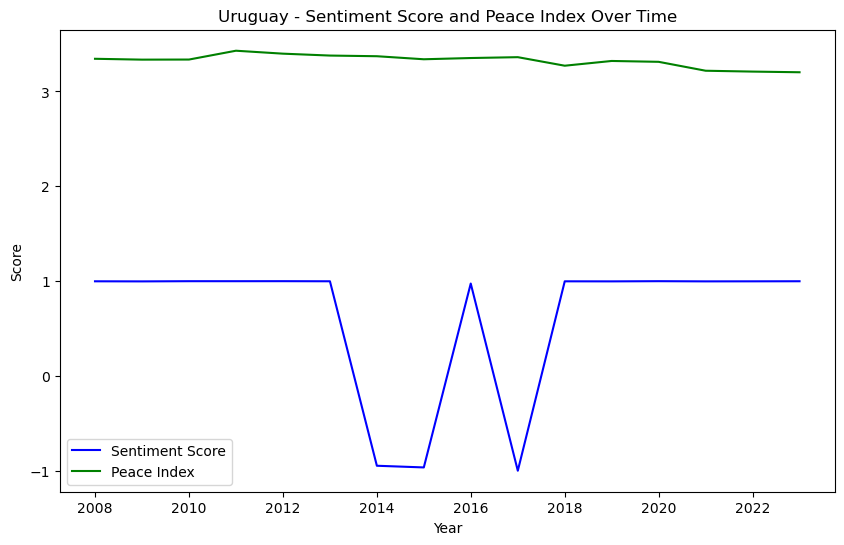

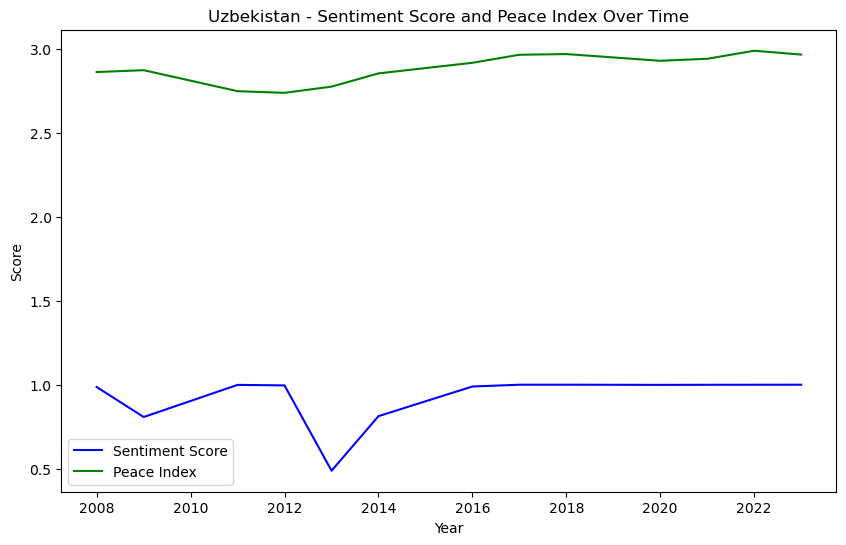

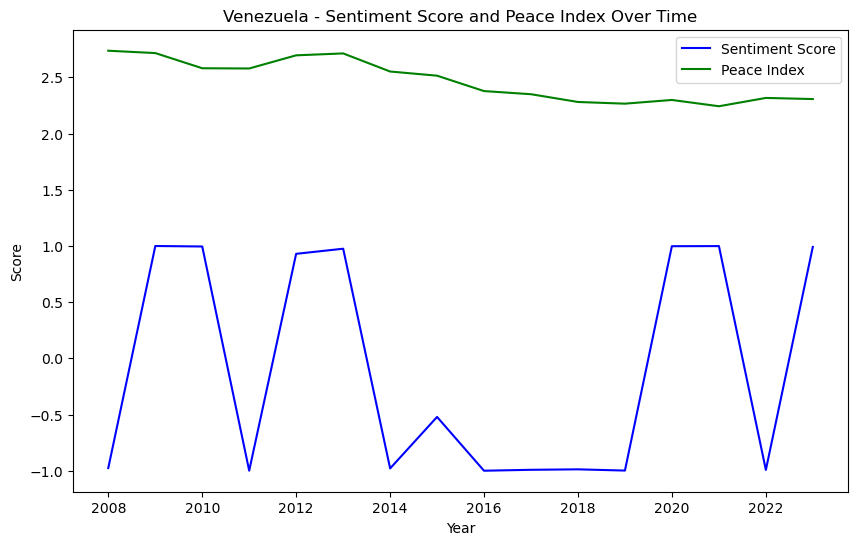

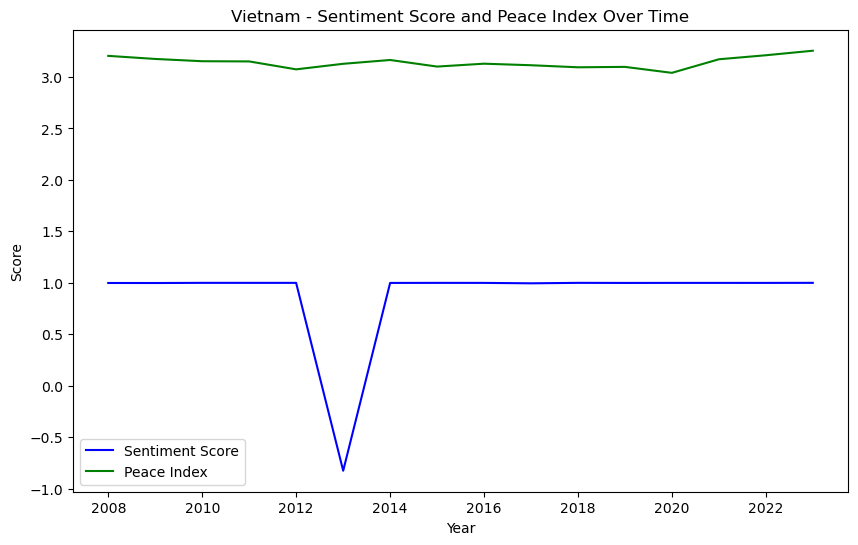

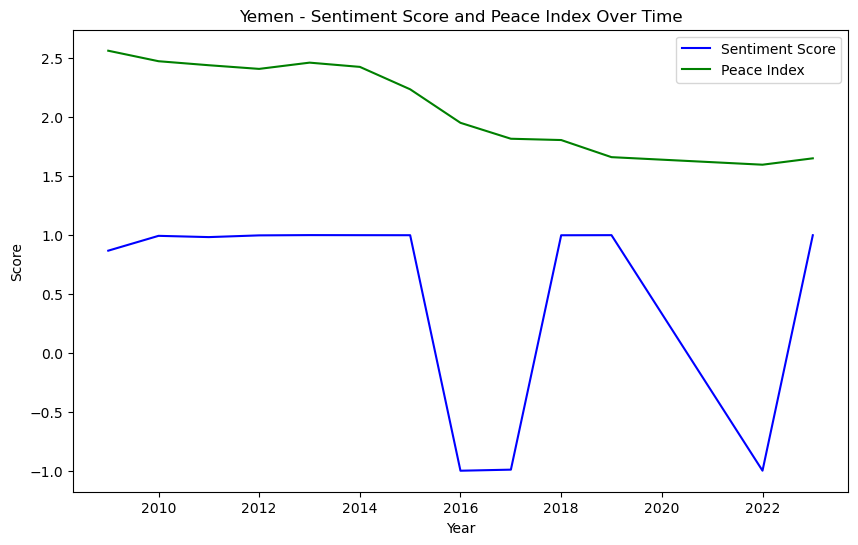

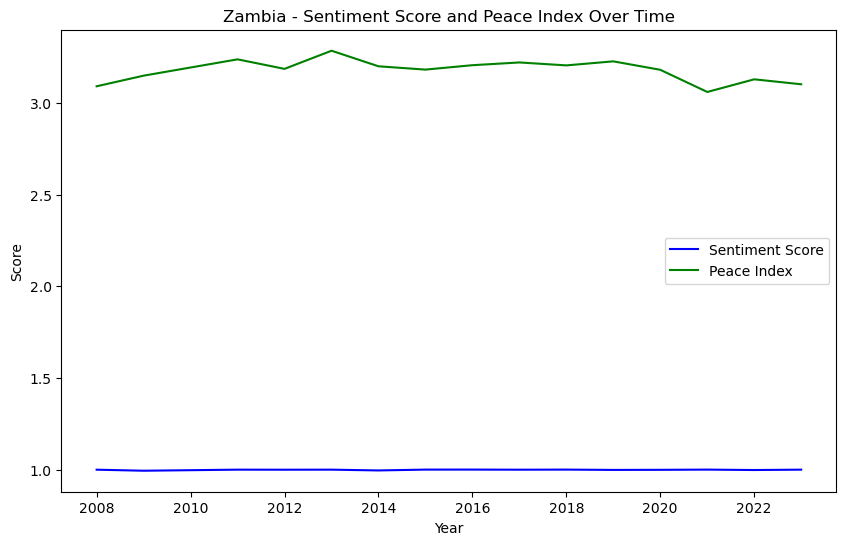

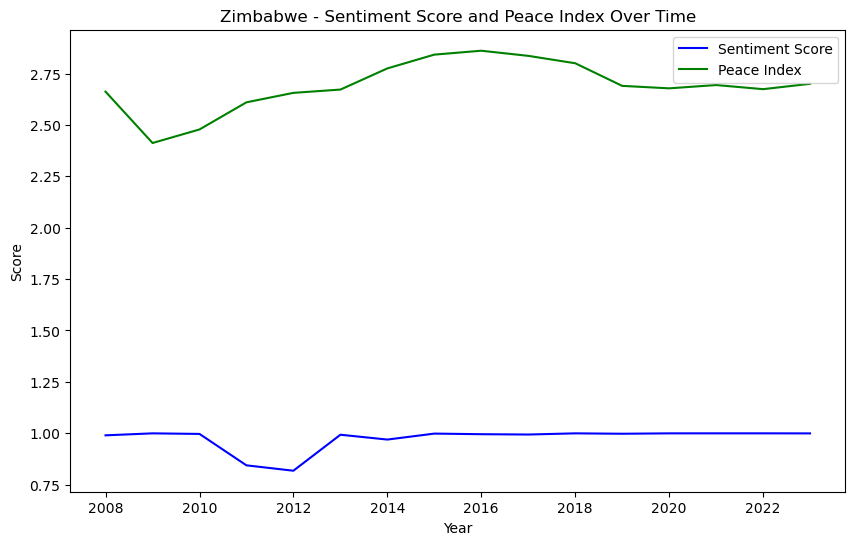

In [9]:
# EDA 4: Changes in speech tone over time relative to peace index
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.sort_values(by=['Country name', 'year'], inplace=True)

# Group by country to observe changes in sentiment over time
country_groups = df.groupby('Country name')

for name, group in country_groups:
    plt.figure(figsize=(10, 6))
    plt.plot(group['year'], group['sentiment_score'], label='Sentiment Score', color='blue')
    plt.plot(group['year'], group['Overall Scores'], label='Peace Index', color='green')
    plt.title(f'{name} - Sentiment Score and Peace Index Over Time')
    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

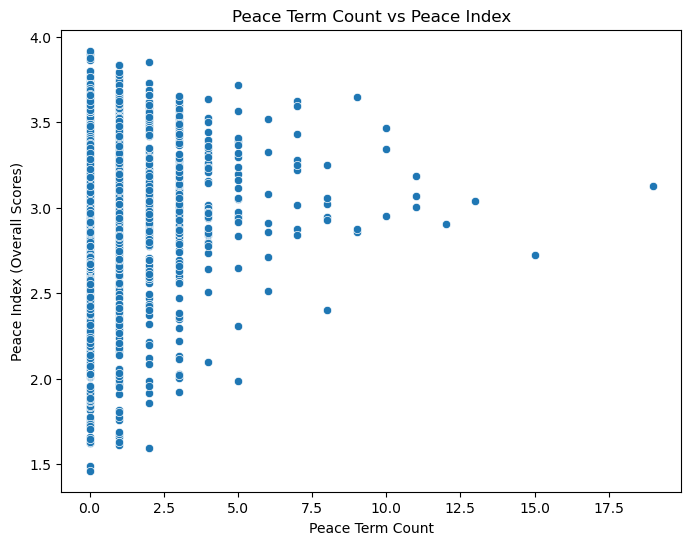

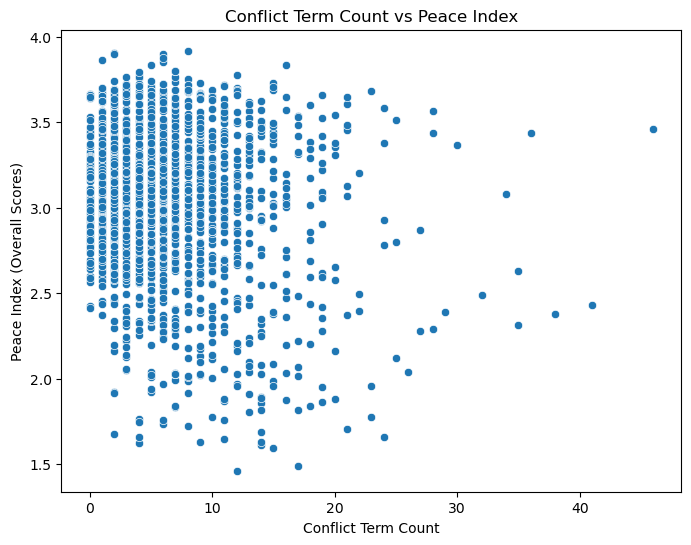

In [10]:
# EDA 5: Mentions of peace/conflict-related terms vs. Peace Index

# Define lists of peace- and conflict-related terms
peace_terms = ['peace', 'harmony', 'cooperation', 'dialogue', 'negotiation', 'mediation', 'diplomacy']
conflict_terms = ['war', 'conflict', 'violence', 'aggression', 'hostility', 'terrorism', 'casualities']

# Function to count term frequency in speech
def count_terms(speech, term_list):
    speech_words = speech.split()
    term_counts = sum([1 for word in speech_words if word in term_list])
    return term_counts

df['peace_term_count'] = df['cleaned_speech'].apply(lambda x: count_terms(x, peace_terms))
df['conflict_term_count'] = df['cleaned_speech'].apply(lambda x: count_terms(x, conflict_terms))

# Plot peace term count vs. peace index
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='peace_term_count', y='Overall Scores')
plt.title('Peace Term Count vs Peace Index')
plt.xlabel('Peace Term Count')
plt.ylabel('Peace Index (Overall Scores)')
plt.show()

# Plot conflict term count vs. peace index
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='conflict_term_count', y='Overall Scores')
plt.title('Conflict Term Count vs Peace Index')
plt.xlabel('Conflict Term Count')
plt.ylabel('Peace Index (Overall Scores)')
plt.show()


Top 10 words for Africa:
african: 2279
support: 2005
efforts: 1961
economic: 1688
sustainable: 1687
community: 1609
states: 1600
general: 1555
climate: 1478
national: 1469

Top 10 words for Asia:
human: 1306
economic: 1249
sustainable: 1230
efforts: 1217
community: 1206
climate: 1131
new: 1129
change: 1067
states: 1060
support: 1023

Top 10 words for Europe:
human: 3064
states: 2557
new: 2285
council: 2202
support: 2039
need: 1974
sustainable: 1918
efforts: 1911
climate: 1847
years: 1841

Top 10 words for Middle East:
region: 788
efforts: 758
arab: 752
israel: 723
state: 721
states: 703
iran: 647
support: 635
political: 593
iraq: 544

Top 10 words for North America:
canada: 312
mexico: 281
human: 195
change: 139
support: 126
work: 123
states: 122
today: 121
council: 114
climate: 113

Top 10 words for Oceania:
new: 369
australia: 300
zealand: 209
council: 198
pacific: 183
states: 158
climate: 147
change: 146
work: 145
region: 135

Top 10 words for Other:
human: 725
states: 621
economic

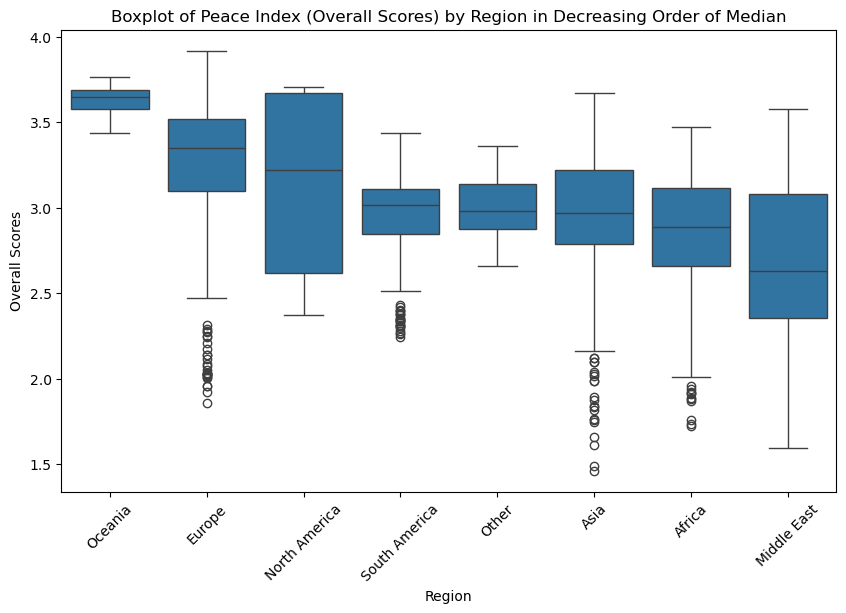

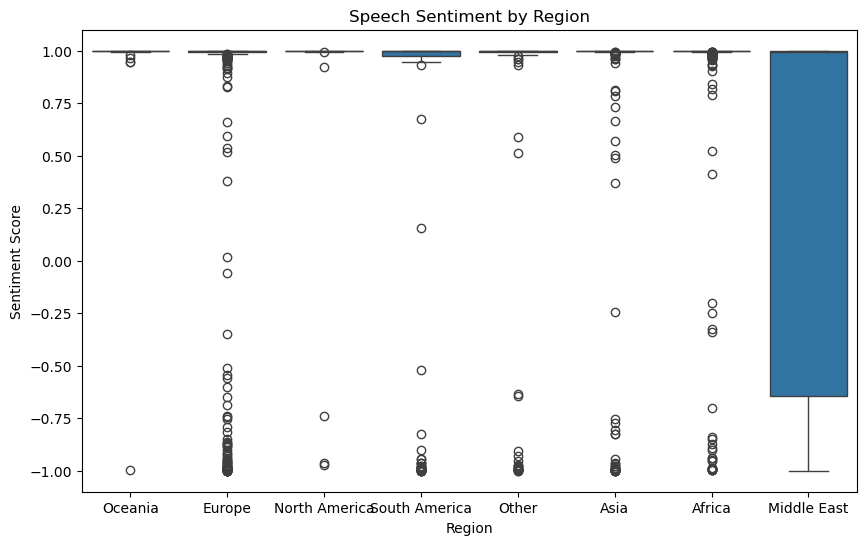

In [11]:
# EDA 6: Geopolitical regions, peace index, and speech content
# Define regions (for the sake of simplicity, group countries into regions manually or use an external dataset)
# Example region grouping (a more detailed region classification could be used)
from regions import regions

# Add region information to dataframe
def get_region(country_name):
    for region, countries in regions.items():
        if country_name in countries:
            return region
    return 'Other'

df['Region'] = df['Country name'].apply(get_region)

# Group by region and analyze speech content
region_groups = df.groupby('Region')

# Function to print the top N words for each region
def print_top_words(region, text_data, n=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=n)
    X = vectorizer.fit_transform(text_data)
    word_counts = X.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    word_freq = dict(zip(words, word_counts))
    
    # Sort words by frequency and print the top N
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop {n} words for {region}:")
    for word, count in sorted_words:
        print(f"{word}: {count}")

# Loop over each region and print the top words
for region, group in region_groups:
    text_data = group['cleaned_speech'].values
    print_top_words(region, text_data)

# Calculate median peace index for each region
median_peace_by_region = df.groupby('Region')['Overall Scores'].median().sort_values(ascending=False)

# Reorder the DataFrame based on the sorted region order
df['Region'] = pd.Categorical(df['Region'], categories=median_peace_by_region.index, ordered=True)

# Plot boxplots in the decreasing order of median peace index
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Overall Scores', data=df, order=median_peace_by_region.index)
plt.title('Boxplot of Peace Index (Overall Scores) by Region in Decreasing Order of Median')
plt.xticks(rotation=45)
plt.show()

# Explore regional differences in speech tone (sentiment)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='sentiment_score', data=df)
plt.title('Speech Sentiment by Region')
plt.xlabel('Region')
plt.ylabel('Sentiment Score')
plt.show()

In [23]:
df.to_pickle("df_complete_extra")  

In [25]:
df.shape

(1920, 23)

In [27]:
df.columns

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Country code', 'Speech', 'Polarity_score', 'Overall Scores',
       'Safety and Security', 'Ongoing Conflict', 'Militarian',
       'cleaned_speech', 'sentiment_score', 'peace_term_count',
       'conflict_term_count', 'Region'],
      dtype='object')